# TESS Atlas fit for TOI 139

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 139.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-139.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-139.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-139.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 139

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 139 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

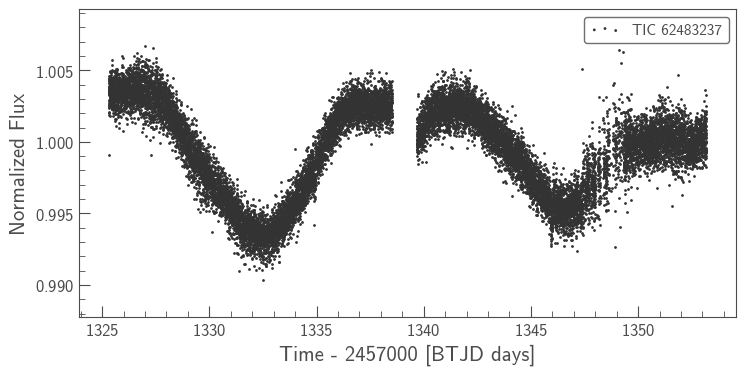

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -28949.58708835355 -> -27045.851878353114


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -24754.032473524385 -> -24334.667296897554


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -24334.667296897554 -> -24276.561941491113


optimizing logp for variables: ['logg_star']


message: Desired error not necessarily achieved due to precision loss.
logp: -24276.561941491113 -> -24276.53153252505


optimizing logp for variables: ['mean', 't0', 'logP']


message: Optimization terminated successfully.
logp: -24276.53153252505 -> -24276.409871928914


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -24276.409871928914 -> -24276.395495541594


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -24276.395495541594 -> -24273.135107914735


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -24273.135107914735 -> -24273.135107914735


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -24273.135107914735 -> -24273.135107914735


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -24273.135107914735 -> -24273.135107914735


optimizing logp for variables: ['mean', 't0', 'logP']


message: Optimization terminated successfully.
logp: -24273.135107914735 -> -24273.135107914724


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -24273.135107914724 -> -24273.135107914724


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Optimization terminated successfully.
logp: -24273.135107914724 -> -24273.135107914724


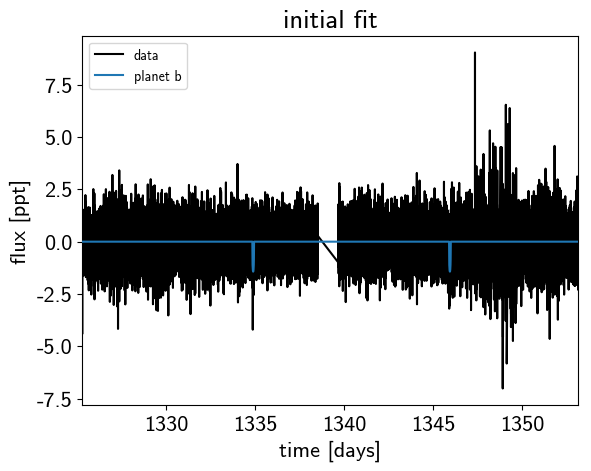

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:06, 15.68draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:11,  7.93draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:15,  5.90draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:18,  4.88draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:19,  4.44draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:20,  4.05draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:21,  3.82draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:22,  3.65draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:22,  3.47draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:23,  3.34draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:22,  3.31draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:07<00:22,  3.31draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:07<00:18,  3.84draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:07<00:23,  3.07draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:07<00:19,  3.52draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:08<00:22,  3.11draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:08<00:19,  3.52draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:08<00:21,  3.18draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:09<00:18,  3.51draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:09<00:20,  3.20draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:09<00:18,  3.51draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:09<00:15,  4.09draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:10<00:14,  4.31draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:10<00:17,  3.56draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:10<00:15,  3.90draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:11<00:18,  3.24draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:11<00:16,  3.46draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:11<00:18,  3.09draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:11<00:15,  3.53draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:12<00:19,  2.88draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:12<00:14,  3.64draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:13<00:19,  2.77draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:13<00:14,  3.43draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:13<00:15,  3.16draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:14<00:15,  3.17draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:14<00:14,  3.27draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:14<00:15,  3.06draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:15<00:15,  2.89draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:15<00:14,  3.02draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:16<00:18,  2.37draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:16<00:16,  2.56draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:16<00:13,  3.15draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:17<00:14,  2.75draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:17<00:14,  2.78draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:17<00:13,  2.82draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:18<00:12,  3.06draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:18<00:14,  2.52draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:18<00:11,  3.16draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:19<00:12,  2.71draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:19<00:09,  3.40draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:20<00:11,  2.71draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:20<00:10,  2.78draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:21<00:09,  2.88draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:22<00:08,  2.92draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:22<00:08,  2.98draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:23<00:07,  3.10draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:23<00:06,  3.20draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:24<00:05,  3.71draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:24<00:05,  3.13draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:24<00:04,  3.45draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:25<00:05,  2.96draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:25<00:04,  3.48draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:25<00:04,  2.86draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:25<00:03,  3.55draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:26<00:03,  3.64draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:26<00:03,  3.59draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:26<00:02,  3.45draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:27<00:02,  3.66draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:27<00:02,  3.31draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:27<00:01,  3.78draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:27<00:01,  3.22draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:28<00:01,  3.91draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:28<00:01,  3.13draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:29<00:00,  3.19draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:31<00:00,  1.27draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:31<00:00,  1.67draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:07, 12.02draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:15,  6.14draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:17,  5.10draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:19,  4.62draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:17,  5.03draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:28,  3.02draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:27,  3.06draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:21,  3.81draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:18,  4.43draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:24,  3.29draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:05<00:22,  3.52draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:24,  3.24draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:23,  3.31draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:06<00:24,  3.19draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:06<00:24,  3.08draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:22,  3.29draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:06<00:20,  3.67draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:07<00:18,  3.92draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:07<00:20,  3.45draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:07<00:18,  3.91draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:08<00:22,  3.07draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:08<00:18,  3.73draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:08<00:21,  3.19draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:08<00:17,  3.88draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:09<00:20,  3.23draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:09<00:16,  3.94draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:09<00:19,  3.26draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:09<00:15,  4.00draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:10<00:18,  3.28draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:10<00:15,  4.05draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:10<00:18,  3.28draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:10<00:14,  4.07draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:11<00:17,  3.27draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:11<00:13,  4.08draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:11<00:17,  3.26draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:12<00:16,  3.36draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:13<00:15,  3.44draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:13<00:13,  3.82draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:13<00:11,  4.33draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:14<00:16,  2.89draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:14<00:16,  2.87draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:15<00:13,  3.24draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:15<00:11,  3.72draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:16<00:13,  3.13draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:16<00:13,  2.93draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:16<00:13,  2.92draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:17<00:14,  2.57draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:17<00:11,  3.23draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:18<00:14,  2.56draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:18<00:11,  3.11draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:18<00:09,  3.55draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:19<00:09,  3.55draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:19<00:08,  3.39draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:20<00:08,  3.39draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:20<00:07,  3.38draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:21<00:07,  3.42draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:21<00:04,  4.54draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:22<00:06,  3.24draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:22<00:05,  3.04draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:23<00:05,  3.09draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:23<00:03,  3.72draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:24<00:03,  3.57draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:24<00:03,  3.33draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:24<00:03,  3.57draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:25<00:03,  3.05draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:25<00:02,  3.76draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:25<00:02,  2.86draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:26<00:02,  3.15draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:26<00:02,  2.96draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:26<00:01,  3.65draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:26<00:00,  4.49draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:27<00:00,  3.21draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:29<00:00,  1.76draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:29<00:00,  2.30draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<01:06,  3.04draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<00:56,  3.54draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:00<00:47,  4.19draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:01<00:43,  4.49draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:01<00:50,  3.89draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:01<00:45,  4.30draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:02<00:38,  5.07draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:02<00:47,  4.01draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:02<00:45,  4.19draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:02<00:51,  3.71draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:03<00:48,  3.86draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:03<00:53,  3.54draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:03<00:48,  3.87draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:04<00:50,  3.64draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:04<00:44,  4.09draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:04<00:42,  4.33draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:05<00:50,  3.56draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:05<00:43,  4.14draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:05<00:41,  4.30draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:06<00:39,  4.49draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:06<00:47,  3.72draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:06<00:41,  4.17draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:06<00:36,  4.74draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:07<00:39,  4.37draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:07<00:44,  3.87draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:07<00:38,  4.46draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:07<00:35,  4.77draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:08<00:38,  4.36draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:08<00:29,  5.67draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:08<00:28,  5.73draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:08<00:32,  5.09draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:09<00:33,  4.83draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:09<00:27,  5.80draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:09<00:36,  4.41draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:09<00:36,  4.37draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:10<00:31,  4.95draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:10<00:28,  5.47draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:10<00:23,  6.50draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:10<00:36,  4.14draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:11<00:38,  3.94draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:11<00:30,  4.93draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:11<00:33,  4.44draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:12<00:38,  3.83draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:12<00:36,  3.98draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:12<00:34,  4.16draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:12<00:26,  5.44draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:13<00:32,  4.39draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:13<00:36,  3.81draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:13<00:37,  3.74draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:13<00:31,  4.33draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:14<00:42,  3.23draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:14<00:32,  4.12draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:14<00:25,  5.25draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:15<00:41,  3.17draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:15<00:36,  3.60draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:15<00:33,  3.79draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:16<00:38,  3.36draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:16<00:32,  3.94draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:16<00:28,  4.39draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:16<00:36,  3.41draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:17<00:27,  4.49draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:17<00:27,  4.40draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:17<00:21,  5.44draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:17<00:24,  4.74draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:18<00:20,  5.58draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:18<00:15,  7.17draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:18<00:14,  7.63draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:18<00:13,  8.02draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:19<00:16,  6.60draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:19<00:13,  7.64draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:19<00:12,  8.04draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:19<00:14,  7.05draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:19<00:18,  5.45draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:20<00:23,  4.34draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:20<00:24,  4.08draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:20<00:22,  4.40draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:21<00:26,  3.66draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:21<00:22,  4.35draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:21<00:15,  5.85draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:21<00:15,  5.69draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:22<00:16,  5.19draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:22<00:14,  5.97draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:22<00:14,  5.79draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:22<00:19,  4.31draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:23<00:20,  4.19draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:23<00:23,  3.52draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:23<00:17,  4.61draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:23<00:14,  5.39draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:24<00:20,  3.86draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:24<00:17,  4.32draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:24<00:21,  3.55draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:25<00:19,  3.84draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:25<00:18,  3.98draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:25<00:15,  4.72draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:26<00:19,  3.50draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:26<00:16,  4.30draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:26<00:20,  3.29draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:27<00:16,  4.07draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:27<00:14,  4.43draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:27<00:15,  4.08draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:28<00:16,  3.87draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:28<00:13,  4.39draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:29<00:14,  4.02draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:29<00:14,  3.83draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:29<00:12,  4.32draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:30<00:09,  5.76draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:30<00:07,  6.83draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:30<00:05,  8.46draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:30<00:05,  8.67draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:30<00:05,  7.56draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:31<00:05,  7.60draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:31<00:08,  4.57draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:31<00:08,  4.47draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:32<00:10,  3.61draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:32<00:08,  4.27draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:32<00:06,  5.24draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:32<00:06,  5.44draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:32<00:06,  5.64draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:33<00:06,  5.30draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [00:33<00:04,  6.70draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:33<00:05,  5.86draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:33<00:05,  5.48draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:33<00:04,  6.01draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:34<00:04,  6.24draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [00:34<00:05,  4.42draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:34<00:05,  4.23draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:35<00:06,  3.52draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:35<00:05,  3.68draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:35<00:04,  4.19draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:35<00:03,  4.52draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:36<00:03,  5.07draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:36<00:03,  4.17draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:36<00:02,  4.56draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:37<00:01,  5.70draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:37<00:02,  4.22draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:37<00:01,  4.49draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:38<00:01,  4.71draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:38<00:01,  3.13draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:38<00:01,  3.75draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:39<00:00,  4.24draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:39<00:00,  3.60draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:39<00:00,  3.09draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:40<00:00,  2.73draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 3/404 [00:00<00:14, 28.07draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:00<00:12, 30.78draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:00<00:13, 30.01draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:00<00:12, 31.01draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:00<00:13, 28.70draws/s]

Sampling 2 chains:   6%|▌         | 24/404 [00:00<00:11, 33.69draws/s]

Sampling 2 chains:   7%|▋         | 28/404 [00:00<00:12, 30.18draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:01<00:16, 21.88draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:01<00:18, 19.56draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:01<00:17, 20.78draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:01<00:15, 23.68draws/s]

Sampling 2 chains:  11%|█         | 45/404 [00:01<00:14, 24.28draws/s]

Sampling 2 chains:  12%|█▏        | 49/404 [00:01<00:13, 26.40draws/s]

Sampling 2 chains:  13%|█▎        | 52/404 [00:01<00:13, 26.41draws/s]

Sampling 2 chains:  14%|█▍        | 56/404 [00:02<00:12, 28.41draws/s]

Sampling 2 chains:  15%|█▍        | 59/404 [00:02<00:12, 28.58draws/s]

Sampling 2 chains:  15%|█▌        | 62/404 [00:02<00:12, 26.91draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:02<00:15, 22.49draws/s]

Sampling 2 chains:  17%|█▋        | 69/404 [00:02<00:14, 23.14draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:02<00:16, 20.20draws/s]

Sampling 2 chains:  19%|█▊        | 75/404 [00:02<00:16, 20.44draws/s]

Sampling 2 chains:  20%|██        | 81/404 [00:03<00:13, 24.60draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:03<00:11, 26.92draws/s]

Sampling 2 chains:  22%|██▏       | 89/404 [00:03<00:14, 21.87draws/s]

Sampling 2 chains:  23%|██▎       | 92/404 [00:03<00:13, 22.33draws/s]

Sampling 2 chains:  24%|██▎       | 95/404 [00:03<00:14, 21.13draws/s]

Sampling 2 chains:  25%|██▍       | 99/404 [00:03<00:12, 24.40draws/s]

Sampling 2 chains:  25%|██▌       | 103/404 [00:04<00:12, 24.40draws/s]

Sampling 2 chains:  27%|██▋       | 108/404 [00:04<00:12, 24.30draws/s]

Sampling 2 chains:  27%|██▋       | 111/404 [00:04<00:13, 21.47draws/s]

Sampling 2 chains:  28%|██▊       | 114/404 [00:04<00:15, 18.14draws/s]

Sampling 2 chains:  29%|██▉       | 117/404 [00:04<00:15, 18.53draws/s]

Sampling 2 chains:  30%|██▉       | 120/404 [00:04<00:14, 20.27draws/s]

Sampling 2 chains:  30%|███       | 123/404 [00:05<00:15, 17.69draws/s]

Sampling 2 chains:  31%|███       | 126/404 [00:05<00:15, 17.93draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:05<00:15, 17.95draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:05<00:19, 13.96draws/s]

Sampling 2 chains:  33%|███▎      | 132/404 [00:06<00:33,  8.13draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:06<00:31,  8.70draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:06<00:31,  8.63draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:06<00:25, 10.35draws/s]

Sampling 2 chains:  35%|███▍      | 141/404 [00:06<00:23, 11.01draws/s]

Sampling 2 chains:  36%|███▌      | 145/404 [00:06<00:19, 13.54draws/s]

Sampling 2 chains:  37%|███▋      | 149/404 [00:07<00:15, 16.55draws/s]

Sampling 2 chains:  38%|███▊      | 152/404 [00:07<00:13, 18.56draws/s]

Sampling 2 chains:  39%|███▊      | 156/404 [00:07<00:11, 21.52draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:07<00:12, 20.06draws/s]

Sampling 2 chains:  40%|████      | 163/404 [00:07<00:10, 22.90draws/s]

Sampling 2 chains:  41%|████▏     | 167/404 [00:07<00:09, 24.48draws/s]

Sampling 2 chains:  42%|████▏     | 170/404 [00:07<00:10, 22.70draws/s]

Sampling 2 chains:  43%|████▎     | 173/404 [00:08<00:12, 18.39draws/s]

Sampling 2 chains:  44%|████▎     | 176/404 [00:08<00:11, 20.14draws/s]

Sampling 2 chains:  44%|████▍     | 179/404 [00:08<00:11, 19.88draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [00:08<00:11, 19.75draws/s]

Sampling 2 chains:  46%|████▌     | 185/404 [00:08<00:10, 21.18draws/s]

Sampling 2 chains:  47%|████▋     | 189/404 [00:08<00:08, 23.92draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:08<00:10, 20.52draws/s]

Sampling 2 chains:  48%|████▊     | 195/404 [00:09<00:10, 19.80draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:09<00:09, 21.29draws/s]

Sampling 2 chains:  50%|████▉     | 201/404 [00:09<00:09, 22.41draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:09<00:08, 23.33draws/s]

Sampling 2 chains:  51%|█████     | 207/404 [00:09<00:09, 21.33draws/s]

Sampling 2 chains:  52%|█████▏    | 210/404 [00:09<00:09, 19.88draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:09<00:09, 21.06draws/s]

Sampling 2 chains:  53%|█████▎    | 216/404 [00:10<00:08, 22.55draws/s]

Sampling 2 chains:  54%|█████▍    | 219/404 [00:10<00:07, 23.14draws/s]

Sampling 2 chains:  55%|█████▍    | 222/404 [00:10<00:08, 21.85draws/s]

Sampling 2 chains:  56%|█████▌    | 225/404 [00:10<00:08, 21.08draws/s]

Sampling 2 chains:  57%|█████▋    | 229/404 [00:10<00:07, 22.31draws/s]

Sampling 2 chains:  57%|█████▋    | 232/404 [00:10<00:08, 21.31draws/s]

Sampling 2 chains:  58%|█████▊    | 235/404 [00:10<00:08, 20.65draws/s]

Sampling 2 chains:  59%|█████▉    | 239/404 [00:11<00:07, 23.28draws/s]

Sampling 2 chains:  60%|█████▉    | 242/404 [00:11<00:07, 21.92draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:11<00:08, 19.48draws/s]

Sampling 2 chains:  61%|██████▏   | 248/404 [00:11<00:07, 21.00draws/s]

Sampling 2 chains:  62%|██████▏   | 251/404 [00:11<00:06, 22.18draws/s]

Sampling 2 chains:  63%|██████▎   | 255/404 [00:11<00:06, 24.74draws/s]

Sampling 2 chains:  64%|██████▍   | 258/404 [00:11<00:05, 25.02draws/s]

Sampling 2 chains:  65%|██████▍   | 261/404 [00:12<00:05, 25.12draws/s]

Sampling 2 chains:  65%|██████▌   | 264/404 [00:12<00:05, 25.29draws/s]

Sampling 2 chains:  66%|██████▌   | 267/404 [00:12<00:06, 21.24draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [00:12<00:06, 22.29draws/s]

Sampling 2 chains:  68%|██████▊   | 273/404 [00:12<00:06, 21.39draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [00:12<00:07, 17.96draws/s]

Sampling 2 chains:  69%|██████▉   | 278/404 [00:12<00:07, 16.07draws/s]

Sampling 2 chains:  70%|██████▉   | 281/404 [00:13<00:06, 17.73draws/s]

Sampling 2 chains:  70%|███████   | 283/404 [00:13<00:06, 17.57draws/s]

Sampling 2 chains:  71%|███████   | 286/404 [00:13<00:06, 17.47draws/s]

Sampling 2 chains:  72%|███████▏  | 289/404 [00:13<00:06, 18.29draws/s]

Sampling 2 chains:  72%|███████▏  | 292/404 [00:14<00:09, 11.32draws/s]

Sampling 2 chains:  73%|███████▎  | 294/404 [00:15<00:25,  4.37draws/s]

Sampling 2 chains:  73%|███████▎  | 296/404 [00:16<00:34,  3.17draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [00:16<00:41,  2.60draws/s]

Sampling 2 chains:  74%|███████▍  | 298/404 [00:17<00:48,  2.17draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [00:18<00:56,  1.87draws/s]

Sampling 2 chains:  74%|███████▍  | 300/404 [00:18<00:56,  1.83draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [00:19<00:55,  1.86draws/s]

Sampling 2 chains:  75%|███████▍  | 302/404 [00:19<00:54,  1.87draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [00:20<00:55,  1.82draws/s]

Sampling 2 chains:  75%|███████▌  | 304/404 [00:20<00:55,  1.81draws/s]

Sampling 2 chains:  75%|███████▌  | 305/404 [00:21<00:53,  1.85draws/s]

Sampling 2 chains:  76%|███████▌  | 306/404 [00:21<00:50,  1.94draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:22<00:48,  2.00draws/s]

Sampling 2 chains:  76%|███████▌  | 308/404 [00:22<00:46,  2.05draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [00:23<00:47,  2.02draws/s]

Sampling 2 chains:  77%|███████▋  | 310/404 [00:23<00:46,  2.01draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [00:24<00:45,  2.05draws/s]

Sampling 2 chains:  77%|███████▋  | 312/404 [00:24<00:44,  2.09draws/s]

Sampling 2 chains:  77%|███████▋  | 313/404 [00:25<00:47,  1.91draws/s]

Sampling 2 chains:  78%|███████▊  | 314/404 [00:25<00:42,  2.11draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [00:26<00:42,  2.09draws/s]

Sampling 2 chains:  78%|███████▊  | 316/404 [00:26<00:40,  2.18draws/s]

Sampling 2 chains:  78%|███████▊  | 317/404 [00:27<00:40,  2.13draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:27<00:41,  2.07draws/s]

Sampling 2 chains:  79%|███████▉  | 319/404 [00:28<00:41,  2.07draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [00:28<00:40,  2.07draws/s]

Sampling 2 chains:  79%|███████▉  | 321/404 [00:29<00:39,  2.08draws/s]

Sampling 2 chains:  80%|███████▉  | 322/404 [00:29<00:38,  2.11draws/s]

Sampling 2 chains:  80%|███████▉  | 323/404 [00:29<00:38,  2.13draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [00:30<00:39,  2.02draws/s]

Sampling 2 chains:  80%|████████  | 325/404 [00:31<00:41,  1.91draws/s]

Sampling 2 chains:  81%|████████  | 326/404 [00:31<00:39,  1.97draws/s]

Sampling 2 chains:  81%|████████  | 327/404 [00:32<00:39,  1.94draws/s]

Sampling 2 chains:  81%|████████  | 328/404 [00:32<00:38,  1.96draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [00:33<00:37,  2.01draws/s]

Sampling 2 chains:  82%|████████▏ | 330/404 [00:33<00:38,  1.94draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [00:34<00:36,  1.99draws/s]

Sampling 2 chains:  82%|████████▏ | 332/404 [00:34<00:35,  2.03draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [00:35<00:35,  2.03draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [00:35<00:36,  1.92draws/s]

Sampling 2 chains:  83%|████████▎ | 335/404 [00:36<00:34,  1.98draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [00:36<00:34,  1.96draws/s]

Sampling 2 chains:  83%|████████▎ | 337/404 [00:37<00:33,  2.00draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [00:37<00:33,  1.98draws/s]

Sampling 2 chains:  84%|████████▍ | 339/404 [00:38<00:34,  1.88draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [00:38<00:34,  1.84draws/s]

Sampling 2 chains:  84%|████████▍ | 341/404 [00:39<00:32,  1.92draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [00:39<00:31,  1.98draws/s]

Sampling 2 chains:  85%|████████▍ | 343/404 [00:40<00:30,  2.02draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [00:40<00:30,  1.95draws/s]

Sampling 2 chains:  85%|████████▌ | 345/404 [00:41<00:29,  2.00draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [00:41<00:28,  2.04draws/s]

Sampling 2 chains:  86%|████████▌ | 347/404 [00:42<00:29,  1.95draws/s]

Sampling 2 chains:  86%|████████▌ | 348/404 [00:42<00:28,  1.95draws/s]

Sampling 2 chains:  86%|████████▋ | 349/404 [00:43<00:27,  2.00draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [00:43<00:26,  2.05draws/s]

Sampling 2 chains:  87%|████████▋ | 351/404 [00:44<00:25,  2.08draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:44<00:24,  2.10draws/s]

Sampling 2 chains:  87%|████████▋ | 353/404 [00:45<00:24,  2.12draws/s]

Sampling 2 chains:  88%|████████▊ | 354/404 [00:45<00:23,  2.10draws/s]

Sampling 2 chains:  88%|████████▊ | 355/404 [00:46<00:23,  2.12draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [00:46<00:22,  2.13draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [00:46<00:22,  2.10draws/s]

Sampling 2 chains:  89%|████████▊ | 358/404 [00:47<00:21,  2.10draws/s]

Sampling 2 chains:  89%|████████▉ | 359/404 [00:48<00:23,  1.94draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [00:48<00:22,  1.96draws/s]

Sampling 2 chains:  89%|████████▉ | 361/404 [00:49<00:21,  2.01draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [00:49<00:20,  2.04draws/s]

Sampling 2 chains:  90%|████████▉ | 363/404 [00:49<00:19,  2.07draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [00:50<00:19,  2.08draws/s]

Sampling 2 chains:  90%|█████████ | 365/404 [00:50<00:18,  2.08draws/s]

Sampling 2 chains:  91%|█████████ | 366/404 [00:51<00:18,  2.07draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [00:51<00:17,  2.08draws/s]

Sampling 2 chains:  91%|█████████ | 368/404 [00:52<00:17,  2.05draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [00:52<00:17,  1.96draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [00:53<00:17,  1.99draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [00:53<00:16,  2.01draws/s]

Sampling 2 chains:  92%|█████████▏| 372/404 [00:54<00:16,  1.97draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [00:54<00:15,  1.97draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [00:55<00:14,  2.02draws/s]

Sampling 2 chains:  93%|█████████▎| 375/404 [00:55<00:14,  2.04draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [00:56<00:13,  2.07draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [00:56<00:12,  2.10draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [00:57<00:12,  2.11draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [00:57<00:11,  2.10draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [00:58<00:11,  2.12draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [00:58<00:10,  2.13draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [00:59<00:10,  2.12draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [00:59<00:09,  2.11draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [01:00<00:09,  2.10draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [01:00<00:09,  2.11draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [01:01<00:08,  2.09draws/s]

Sampling 2 chains:  96%|█████████▌| 387/404 [01:01<00:08,  2.10draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [01:02<00:07,  2.13draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [01:02<00:07,  2.11draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [01:02<00:06,  2.13draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [01:03<00:06,  2.12draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [01:03<00:05,  2.13draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [01:04<00:05,  2.10draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [01:04<00:03,  2.70draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [01:05<00:03,  2.49draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [01:05<00:02,  2.91draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [01:05<00:02,  3.18draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [01:05<00:01,  3.01draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [01:06<00:01,  2.69draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [01:06<00:01,  2.50draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [01:07<00:01,  2.39draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [01:07<00:00,  2.31draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [01:07<00:00,  2.64draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [01:08<00:00,  2.08draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/804 [00:00<00:40, 19.75draws/s]

Sampling 2 chains:   1%|          | 7/804 [00:00<00:34, 22.95draws/s]

Sampling 2 chains:   1%|▏         | 11/804 [00:00<00:33, 23.54draws/s]

Sampling 2 chains:   2%|▏         | 14/804 [00:00<00:33, 23.70draws/s]

Sampling 2 chains:   2%|▏         | 16/804 [00:01<01:36,  8.13draws/s]

Sampling 2 chains:   2%|▏         | 18/804 [00:01<01:28,  8.90draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:01<01:21,  9.66draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:01<01:17, 10.03draws/s]

Sampling 2 chains:   3%|▎         | 24/804 [00:01<01:13, 10.60draws/s]

Sampling 2 chains:   3%|▎         | 27/804 [00:01<00:59, 13.01draws/s]

Sampling 2 chains:   4%|▎         | 29/804 [00:02<00:56, 13.82draws/s]

Sampling 2 chains:   4%|▍         | 31/804 [00:02<01:04, 11.90draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:02<00:51, 15.05draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:02<00:44, 17.08draws/s]

Sampling 2 chains:   5%|▌         | 41/804 [00:02<00:44, 17.03draws/s]

Sampling 2 chains:   5%|▌         | 44/804 [00:02<00:55, 13.78draws/s]

Sampling 2 chains:   6%|▌         | 46/804 [00:03<00:55, 13.74draws/s]

Sampling 2 chains:   6%|▌         | 49/804 [00:03<00:47, 16.06draws/s]

Sampling 2 chains:   6%|▋         | 51/804 [00:03<00:57, 13.15draws/s]

Sampling 2 chains:   7%|▋         | 53/804 [00:03<00:56, 13.34draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:03<00:56, 13.34draws/s]

Sampling 2 chains:   7%|▋         | 57/804 [00:03<00:55, 13.55draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:04<00:50, 14.69draws/s]

Sampling 2 chains:   8%|▊         | 61/804 [00:04<00:47, 15.62draws/s]

Sampling 2 chains:   8%|▊         | 63/804 [00:04<00:45, 16.38draws/s]

Sampling 2 chains:   8%|▊         | 66/804 [00:04<00:42, 17.46draws/s]

Sampling 2 chains:   8%|▊         | 68/804 [00:04<00:45, 16.17draws/s]

Sampling 2 chains:   9%|▊         | 70/804 [00:04<00:46, 15.73draws/s]

Sampling 2 chains:   9%|▉         | 72/804 [00:04<00:48, 15.06draws/s]

Sampling 2 chains:   9%|▉         | 75/804 [00:04<00:42, 17.04draws/s]

Sampling 2 chains:  10%|▉         | 77/804 [00:05<00:48, 14.90draws/s]

Sampling 2 chains:  10%|▉         | 79/804 [00:05<00:52, 13.73draws/s]

Sampling 2 chains:  10%|█         | 82/804 [00:05<00:45, 15.86draws/s]

Sampling 2 chains:  11%|█         | 85/804 [00:05<00:41, 17.51draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:05<00:40, 17.66draws/s]

Sampling 2 chains:  11%|█         | 90/804 [00:05<00:38, 18.77draws/s]

Sampling 2 chains:  12%|█▏        | 93/804 [00:05<00:37, 18.86draws/s]

Sampling 2 chains:  12%|█▏        | 96/804 [00:06<00:38, 18.56draws/s]

Sampling 2 chains:  12%|█▏        | 99/804 [00:06<00:38, 18.44draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:06<00:34, 20.25draws/s]

Sampling 2 chains:  13%|█▎        | 106/804 [00:06<00:32, 21.18draws/s]

Sampling 2 chains:  14%|█▎        | 109/804 [00:06<00:31, 21.82draws/s]

Sampling 2 chains:  14%|█▍        | 112/804 [00:06<00:34, 20.24draws/s]

Sampling 2 chains:  14%|█▍        | 115/804 [00:06<00:33, 20.76draws/s]

Sampling 2 chains:  15%|█▍        | 119/804 [00:07<00:28, 23.78draws/s]

Sampling 2 chains:  15%|█▌        | 123/804 [00:07<00:25, 26.33draws/s]

Sampling 2 chains:  16%|█▌        | 127/804 [00:07<00:25, 26.86draws/s]

Sampling 2 chains:  16%|█▌        | 130/804 [00:07<00:29, 23.16draws/s]

Sampling 2 chains:  17%|█▋        | 133/804 [00:07<00:28, 23.64draws/s]

Sampling 2 chains:  17%|█▋        | 136/804 [00:07<00:27, 24.40draws/s]

Sampling 2 chains:  18%|█▊        | 141/804 [00:07<00:23, 28.33draws/s]

Sampling 2 chains:  18%|█▊        | 145/804 [00:07<00:21, 30.30draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:08<00:20, 32.61draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:08<00:20, 31.81draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:08<00:21, 30.51draws/s]

Sampling 2 chains:  20%|██        | 162/804 [00:08<00:20, 31.73draws/s]

Sampling 2 chains:  21%|██        | 166/804 [00:08<00:21, 30.24draws/s]

Sampling 2 chains:  21%|██        | 170/804 [00:08<00:25, 24.98draws/s]

Sampling 2 chains:  22%|██▏       | 173/804 [00:09<00:26, 23.39draws/s]

Sampling 2 chains:  22%|██▏       | 177/804 [00:09<00:25, 24.37draws/s]

Sampling 2 chains:  23%|██▎       | 182/804 [00:09<00:23, 26.56draws/s]

Sampling 2 chains:  23%|██▎       | 187/804 [00:09<00:21, 28.53draws/s]

Sampling 2 chains:  24%|██▎       | 190/804 [00:09<00:23, 26.06draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:09<00:22, 26.93draws/s]

Sampling 2 chains:  25%|██▍       | 198/804 [00:09<00:21, 27.56draws/s]

Sampling 2 chains:  25%|██▌       | 202/804 [00:10<00:21, 27.97draws/s]

Sampling 2 chains:  26%|██▌       | 206/804 [00:10<00:19, 30.48draws/s]

Sampling 2 chains:  26%|██▌       | 210/804 [00:10<00:19, 30.18draws/s]

Sampling 2 chains:  27%|██▋       | 214/804 [00:10<00:21, 27.09draws/s]

Sampling 2 chains:  27%|██▋       | 217/804 [00:10<00:23, 24.71draws/s]

Sampling 2 chains:  27%|██▋       | 220/804 [00:10<00:23, 24.72draws/s]

Sampling 2 chains:  28%|██▊       | 225/804 [00:10<00:20, 28.93draws/s]

Sampling 2 chains:  28%|██▊       | 229/804 [00:10<00:22, 25.65draws/s]

Sampling 2 chains:  29%|██▉       | 232/804 [00:11<00:23, 23.84draws/s]

Sampling 2 chains:  29%|██▉       | 236/804 [00:11<00:23, 23.97draws/s]

Sampling 2 chains:  30%|██▉       | 239/804 [00:11<00:23, 23.80draws/s]

Sampling 2 chains:  30%|███       | 243/804 [00:11<00:22, 24.80draws/s]

Sampling 2 chains:  31%|███       | 247/804 [00:11<00:20, 27.46draws/s]

Sampling 2 chains:  31%|███       | 251/804 [00:11<00:19, 27.88draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [00:11<00:21, 25.75draws/s]

Sampling 2 chains:  32%|███▏      | 257/804 [00:12<00:29, 18.32draws/s]

Sampling 2 chains:  32%|███▏      | 260/804 [00:12<00:35, 15.48draws/s]

Sampling 2 chains:  33%|███▎      | 263/804 [00:12<00:32, 16.71draws/s]

Sampling 2 chains:  33%|███▎      | 266/804 [00:12<00:30, 17.91draws/s]

Sampling 2 chains:  34%|███▎      | 271/804 [00:12<00:25, 21.13draws/s]

Sampling 2 chains:  34%|███▍      | 275/804 [00:13<00:21, 24.26draws/s]

Sampling 2 chains:  35%|███▍      | 279/804 [00:13<00:21, 24.07draws/s]

Sampling 2 chains:  35%|███▌      | 283/804 [00:13<00:19, 26.23draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:13<00:17, 28.90draws/s]

Sampling 2 chains:  36%|███▌      | 291/804 [00:13<00:17, 29.66draws/s]

Sampling 2 chains:  37%|███▋      | 295/804 [00:13<00:17, 28.35draws/s]

Sampling 2 chains:  37%|███▋      | 299/804 [00:13<00:18, 27.19draws/s]

Sampling 2 chains:  38%|███▊      | 303/804 [00:14<00:19, 25.61draws/s]

Sampling 2 chains:  38%|███▊      | 307/804 [00:14<00:19, 25.67draws/s]

Sampling 2 chains:  39%|███▊      | 310/804 [00:14<00:21, 22.60draws/s]

Sampling 2 chains:  39%|███▉      | 313/804 [00:14<00:23, 20.79draws/s]

Sampling 2 chains:  39%|███▉      | 317/804 [00:14<00:21, 22.18draws/s]

Sampling 2 chains:  40%|███▉      | 321/804 [00:14<00:19, 24.95draws/s]

Sampling 2 chains:  40%|████      | 324/804 [00:14<00:18, 25.95draws/s]

Sampling 2 chains:  41%|████      | 328/804 [00:15<00:16, 28.02draws/s]

Sampling 2 chains:  41%|████▏     | 332/804 [00:15<00:15, 30.24draws/s]

Sampling 2 chains:  42%|████▏     | 336/804 [00:15<00:15, 29.97draws/s]

Sampling 2 chains:  42%|████▏     | 340/804 [00:15<00:15, 29.35draws/s]

Sampling 2 chains:  43%|████▎     | 344/804 [00:15<00:17, 26.86draws/s]

Sampling 2 chains:  43%|████▎     | 348/804 [00:15<00:17, 26.32draws/s]

Sampling 2 chains:  44%|████▎     | 351/804 [00:15<00:16, 27.15draws/s]

Sampling 2 chains:  44%|████▍     | 355/804 [00:15<00:16, 27.75draws/s]

Sampling 2 chains:  45%|████▍     | 359/804 [00:16<00:15, 28.13draws/s]

Sampling 2 chains:  45%|████▌     | 363/804 [00:16<00:15, 28.01draws/s]

Sampling 2 chains:  46%|████▌     | 368/804 [00:16<00:13, 31.71draws/s]

Sampling 2 chains:  46%|████▋     | 372/804 [00:16<00:14, 30.47draws/s]

Sampling 2 chains:  47%|████▋     | 376/804 [00:16<00:16, 25.28draws/s]

Sampling 2 chains:  47%|████▋     | 379/804 [00:16<00:16, 25.74draws/s]

Sampling 2 chains:  48%|████▊     | 383/804 [00:17<00:16, 25.85draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [00:17<00:15, 26.56draws/s]

Sampling 2 chains:  49%|████▊     | 390/804 [00:17<00:16, 25.50draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [00:17<00:17, 24.14draws/s]

Sampling 2 chains:  49%|████▉     | 396/804 [00:17<00:16, 25.17draws/s]

Sampling 2 chains:  50%|████▉     | 399/804 [00:17<00:16, 25.09draws/s]

Sampling 2 chains:  50%|█████     | 402/804 [00:17<00:20, 19.72draws/s]

Sampling 2 chains:  50%|█████     | 405/804 [00:18<00:21, 18.97draws/s]

Sampling 2 chains:  51%|█████     | 409/804 [00:18<00:18, 21.70draws/s]

Sampling 2 chains:  51%|█████     | 412/804 [00:18<00:17, 22.43draws/s]

Sampling 2 chains:  52%|█████▏    | 417/804 [00:18<00:14, 26.63draws/s]

Sampling 2 chains:  52%|█████▏    | 421/804 [00:18<00:16, 23.24draws/s]

Sampling 2 chains:  53%|█████▎    | 425/804 [00:18<00:15, 24.30draws/s]

Sampling 2 chains:  53%|█████▎    | 429/804 [00:18<00:14, 26.75draws/s]

Sampling 2 chains:  54%|█████▍    | 433/804 [00:19<00:12, 28.85draws/s]

Sampling 2 chains:  54%|█████▍    | 437/804 [00:19<00:12, 30.01draws/s]

Sampling 2 chains:  55%|█████▍    | 441/804 [00:19<00:12, 27.97draws/s]

Sampling 2 chains:  55%|█████▌    | 444/804 [00:19<00:13, 27.45draws/s]

Sampling 2 chains:  56%|█████▌    | 447/804 [00:19<00:13, 26.80draws/s]

Sampling 2 chains:  56%|█████▌    | 450/804 [00:19<00:12, 27.67draws/s]

Sampling 2 chains:  56%|█████▋    | 453/804 [00:19<00:12, 27.30draws/s]

Sampling 2 chains:  57%|█████▋    | 456/804 [00:19<00:13, 26.76draws/s]

Sampling 2 chains:  57%|█████▋    | 460/804 [00:19<00:11, 28.99draws/s]

Sampling 2 chains:  58%|█████▊    | 463/804 [00:20<00:12, 27.85draws/s]

Sampling 2 chains:  58%|█████▊    | 466/804 [00:20<00:14, 23.93draws/s]

Sampling 2 chains:  58%|█████▊    | 469/804 [00:20<00:14, 23.66draws/s]

Sampling 2 chains:  59%|█████▊    | 472/804 [00:20<00:13, 24.84draws/s]

Sampling 2 chains:  59%|█████▉    | 475/804 [00:20<00:14, 23.05draws/s]

Sampling 2 chains:  59%|█████▉    | 478/804 [00:20<00:13, 24.75draws/s]

Sampling 2 chains:  60%|█████▉    | 481/804 [00:20<00:14, 22.14draws/s]

Sampling 2 chains:  60%|██████    | 484/804 [00:21<00:14, 22.53draws/s]

Sampling 2 chains:  61%|██████    | 487/804 [00:21<00:14, 22.34draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [00:21<00:13, 23.88draws/s]

Sampling 2 chains:  61%|██████▏   | 494/804 [00:21<00:13, 22.87draws/s]

Sampling 2 chains:  62%|██████▏   | 497/804 [00:21<00:14, 21.37draws/s]

Sampling 2 chains:  62%|██████▏   | 500/804 [00:21<00:14, 21.53draws/s]

Sampling 2 chains:  63%|██████▎   | 504/804 [00:21<00:13, 21.79draws/s]

Sampling 2 chains:  63%|██████▎   | 507/804 [00:22<00:12, 23.11draws/s]

Sampling 2 chains:  63%|██████▎   | 510/804 [00:22<00:12, 23.54draws/s]

Sampling 2 chains:  64%|██████▍   | 513/804 [00:22<00:11, 24.73draws/s]

Sampling 2 chains:  64%|██████▍   | 517/804 [00:22<00:10, 26.15draws/s]

Sampling 2 chains:  65%|██████▍   | 520/804 [00:22<00:11, 25.06draws/s]

Sampling 2 chains:  65%|██████▌   | 523/804 [00:22<00:10, 25.80draws/s]

Sampling 2 chains:  65%|██████▌   | 526/804 [00:22<00:11, 23.20draws/s]

Sampling 2 chains:  66%|██████▌   | 529/804 [00:22<00:12, 21.83draws/s]

Sampling 2 chains:  66%|██████▋   | 533/804 [00:23<00:11, 24.56draws/s]

Sampling 2 chains:  67%|██████▋   | 537/804 [00:23<00:10, 25.12draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [00:23<00:11, 23.57draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [00:23<00:10, 24.62draws/s]

Sampling 2 chains:  68%|██████▊   | 547/804 [00:23<00:09, 26.00draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [00:23<00:10, 24.29draws/s]

Sampling 2 chains:  69%|██████▉   | 553/804 [00:23<00:09, 25.55draws/s]

Sampling 2 chains:  69%|██████▉   | 556/804 [00:23<00:09, 24.86draws/s]

Sampling 2 chains:  70%|██████▉   | 559/804 [00:24<00:09, 25.74draws/s]

Sampling 2 chains:  70%|██████▉   | 562/804 [00:24<00:09, 25.28draws/s]

Sampling 2 chains:  71%|███████   | 567/804 [00:24<00:08, 28.86draws/s]

Sampling 2 chains:  71%|███████   | 572/804 [00:24<00:07, 32.05draws/s]

Sampling 2 chains:  72%|███████▏  | 576/804 [00:24<00:07, 32.33draws/s]

Sampling 2 chains:  72%|███████▏  | 580/804 [00:24<00:08, 25.02draws/s]

Sampling 2 chains:  73%|███████▎  | 583/804 [00:24<00:09, 22.77draws/s]

Sampling 2 chains:  73%|███████▎  | 587/804 [00:25<00:09, 23.19draws/s]

Sampling 2 chains:  74%|███████▎  | 591/804 [00:25<00:08, 24.17draws/s]

Sampling 2 chains:  74%|███████▍  | 594/804 [00:25<00:09, 22.99draws/s]

Sampling 2 chains:  74%|███████▍  | 598/804 [00:25<00:08, 23.94draws/s]

Sampling 2 chains:  75%|███████▍  | 601/804 [00:25<00:08, 22.88draws/s]

Sampling 2 chains:  75%|███████▌  | 604/804 [00:25<00:09, 21.81draws/s]

Sampling 2 chains:  76%|███████▌  | 608/804 [00:26<00:08, 22.95draws/s]

Sampling 2 chains:  76%|███████▌  | 612/804 [00:26<00:07, 25.50draws/s]

Sampling 2 chains:  77%|███████▋  | 616/804 [00:26<00:06, 27.25draws/s]

Sampling 2 chains:  77%|███████▋  | 620/804 [00:26<00:06, 29.16draws/s]

Sampling 2 chains:  78%|███████▊  | 624/804 [00:26<00:05, 30.15draws/s]

Sampling 2 chains:  78%|███████▊  | 628/804 [00:26<00:05, 31.46draws/s]

Sampling 2 chains:  79%|███████▊  | 632/804 [00:26<00:05, 30.49draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [00:26<00:06, 27.94draws/s]

Sampling 2 chains:  80%|███████▉  | 640/804 [00:27<00:06, 26.93draws/s]

Sampling 2 chains:  80%|████████  | 644/804 [00:27<00:05, 27.78draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [00:27<00:05, 28.99draws/s]

Sampling 2 chains:  81%|████████  | 651/804 [00:27<00:06, 23.98draws/s]

Sampling 2 chains:  81%|████████▏ | 654/804 [00:27<00:06, 21.77draws/s]

Sampling 2 chains:  82%|████████▏ | 658/804 [00:27<00:06, 23.30draws/s]

Sampling 2 chains:  82%|████████▏ | 661/804 [00:27<00:05, 23.92draws/s]

Sampling 2 chains:  83%|████████▎ | 664/804 [00:28<00:05, 25.26draws/s]

Sampling 2 chains:  83%|████████▎ | 668/804 [00:28<00:05, 25.32draws/s]

Sampling 2 chains:  83%|████████▎ | 671/804 [00:28<00:05, 23.84draws/s]

Sampling 2 chains:  84%|████████▍ | 674/804 [00:28<00:05, 24.58draws/s]

Sampling 2 chains:  84%|████████▍ | 677/804 [00:28<00:04, 25.75draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [00:28<00:05, 23.21draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [00:28<00:05, 23.46draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [00:29<00:05, 22.40draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [00:29<00:04, 23.70draws/s]

Sampling 2 chains:  86%|████████▌ | 693/804 [00:29<00:04, 24.20draws/s]

Sampling 2 chains:  87%|████████▋ | 697/804 [00:29<00:03, 27.24draws/s]

Sampling 2 chains:  87%|████████▋ | 700/804 [00:29<00:03, 27.68draws/s]

Sampling 2 chains:  87%|████████▋ | 703/804 [00:29<00:03, 27.94draws/s]

Sampling 2 chains:  88%|████████▊ | 706/804 [00:29<00:03, 25.69draws/s]

Sampling 2 chains:  88%|████████▊ | 710/804 [00:29<00:03, 26.59draws/s]

Sampling 2 chains:  89%|████████▉ | 714/804 [00:29<00:03, 29.30draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [00:30<00:02, 29.20draws/s]

Sampling 2 chains:  90%|████████▉ | 722/804 [00:30<00:02, 31.40draws/s]

Sampling 2 chains:  90%|█████████ | 726/804 [00:30<00:02, 31.94draws/s]

Sampling 2 chains:  91%|█████████ | 730/804 [00:30<00:02, 32.12draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [00:30<00:02, 33.60draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [00:30<00:02, 30.28draws/s]

Sampling 2 chains:  92%|█████████▏| 742/804 [00:30<00:02, 28.18draws/s]

Sampling 2 chains:  93%|█████████▎| 745/804 [00:30<00:02, 28.60draws/s]

Sampling 2 chains:  93%|█████████▎| 748/804 [00:31<00:02, 25.63draws/s]

Sampling 2 chains:  93%|█████████▎| 751/804 [00:31<00:02, 20.62draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [00:31<00:02, 20.97draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [00:31<00:01, 24.10draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [00:31<00:01, 23.30draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [00:31<00:01, 26.39draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [00:31<00:01, 26.22draws/s]

Sampling 2 chains:  96%|█████████▌| 771/804 [00:32<00:01, 23.25draws/s]

Sampling 2 chains:  96%|█████████▋| 774/804 [00:32<00:01, 24.14draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [00:32<00:01, 23.04draws/s]

Sampling 2 chains:  97%|█████████▋| 781/804 [00:32<00:00, 26.27draws/s]

Sampling 2 chains:  98%|█████████▊| 784/804 [00:32<00:00, 26.15draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [00:32<00:00, 26.29draws/s]

Sampling 2 chains:  98%|█████████▊| 790/804 [00:32<00:00, 26.66draws/s]

Sampling 2 chains:  99%|█████████▊| 793/804 [00:32<00:00, 26.69draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [00:33<00:00, 29.38draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [00:33<00:00, 24.65draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:33<00:00, 21.20draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/4404 [00:00<02:32, 28.83draws/s]

Sampling 2 chains:   0%|          | 8/4404 [00:00<02:17, 31.86draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:00<02:49, 25.86draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:00<03:54, 18.71draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:00<03:59, 18.30draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:00<03:37, 20.19draws/s]

Sampling 2 chains:   0%|          | 22/4404 [00:01<03:50, 19.02draws/s]

Sampling 2 chains:   1%|          | 25/4404 [00:01<03:35, 20.28draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:01<03:28, 20.95draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:01<03:37, 20.07draws/s]

Sampling 2 chains:   1%|          | 34/4404 [00:01<03:24, 21.32draws/s]

Sampling 2 chains:   1%|          | 37/4404 [00:01<03:11, 22.76draws/s]

Sampling 2 chains:   1%|          | 41/4404 [00:01<03:01, 24.04draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:01<03:03, 23.82draws/s]

Sampling 2 chains:   1%|          | 50/4404 [00:02<02:32, 28.48draws/s]

Sampling 2 chains:   1%|▏         | 56/4404 [00:02<02:15, 32.06draws/s]

Sampling 2 chains:   1%|▏         | 62/4404 [00:02<01:57, 37.09draws/s]

Sampling 2 chains:   2%|▏         | 69/4404 [00:02<01:41, 42.73draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:02<01:39, 43.33draws/s]

Sampling 2 chains:   2%|▏         | 82/4404 [00:02<01:28, 48.88draws/s]

Sampling 2 chains:   2%|▏         | 88/4404 [00:02<01:26, 49.81draws/s]

Sampling 2 chains:   2%|▏         | 94/4404 [00:02<01:27, 48.98draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:03<01:32, 46.32draws/s]

Sampling 2 chains:   2%|▏         | 105/4404 [00:03<01:38, 43.48draws/s]

Sampling 2 chains:   2%|▏         | 110/4404 [00:03<01:50, 38.74draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:03<01:53, 37.74draws/s]

Sampling 2 chains:   3%|▎         | 122/4404 [00:03<01:41, 42.25draws/s]

Sampling 2 chains:   3%|▎         | 127/4404 [00:03<01:50, 38.73draws/s]

Sampling 2 chains:   3%|▎         | 133/4404 [00:03<01:40, 42.55draws/s]

Sampling 2 chains:   3%|▎         | 139/4404 [00:03<01:33, 45.60draws/s]

Sampling 2 chains:   3%|▎         | 144/4404 [00:04<01:37, 43.67draws/s]

Sampling 2 chains:   3%|▎         | 149/4404 [00:04<01:45, 40.41draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:04<01:43, 40.89draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:04<01:34, 44.80draws/s]

Sampling 2 chains:   4%|▍         | 166/4404 [00:04<01:30, 46.90draws/s]

Sampling 2 chains:   4%|▍         | 171/4404 [00:04<01:29, 47.06draws/s]

Sampling 2 chains:   4%|▍         | 176/4404 [00:04<01:37, 43.27draws/s]

Sampling 2 chains:   4%|▍         | 182/4404 [00:04<01:32, 45.44draws/s]

Sampling 2 chains:   4%|▍         | 189/4404 [00:05<01:28, 47.76draws/s]

Sampling 2 chains:   4%|▍         | 196/4404 [00:05<01:21, 51.53draws/s]

Sampling 2 chains:   5%|▍         | 203/4404 [00:05<01:17, 54.31draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:05<01:16, 55.04draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:05<01:32, 45.44draws/s]

Sampling 2 chains:   5%|▌         | 221/4404 [00:05<01:41, 41.37draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:05<01:30, 46.19draws/s]

Sampling 2 chains:   5%|▌         | 234/4404 [00:05<01:33, 44.56draws/s]

Sampling 2 chains:   5%|▌         | 240/4404 [00:06<01:28, 47.03draws/s]

Sampling 2 chains:   6%|▌         | 245/4404 [00:06<01:39, 41.83draws/s]

Sampling 2 chains:   6%|▌         | 251/4404 [00:06<01:32, 44.94draws/s]

Sampling 2 chains:   6%|▌         | 258/4404 [00:06<01:24, 49.30draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:06<01:24, 48.88draws/s]

Sampling 2 chains:   6%|▌         | 270/4404 [00:06<01:24, 48.96draws/s]

Sampling 2 chains:   6%|▋         | 276/4404 [00:06<01:35, 43.02draws/s]

Sampling 2 chains:   6%|▋         | 281/4404 [00:07<01:38, 41.68draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:07<01:39, 41.40draws/s]

Sampling 2 chains:   7%|▋         | 291/4404 [00:07<01:37, 42.12draws/s]

Sampling 2 chains:   7%|▋         | 296/4404 [00:07<01:33, 43.96draws/s]

Sampling 2 chains:   7%|▋         | 302/4404 [00:07<01:29, 45.83draws/s]

Sampling 2 chains:   7%|▋         | 307/4404 [00:07<01:29, 45.59draws/s]

Sampling 2 chains:   7%|▋         | 313/4404 [00:07<01:24, 48.27draws/s]

Sampling 2 chains:   7%|▋         | 318/4404 [00:07<01:35, 42.79draws/s]

Sampling 2 chains:   7%|▋         | 323/4404 [00:08<01:52, 36.25draws/s]

Sampling 2 chains:   7%|▋         | 327/4404 [00:08<02:22, 28.60draws/s]

Sampling 2 chains:   8%|▊         | 331/4404 [00:08<02:15, 30.05draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [00:08<02:21, 28.77draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:08<02:24, 28.22draws/s]

Sampling 2 chains:   8%|▊         | 342/4404 [00:08<02:31, 26.87draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:08<02:35, 26.19draws/s]

Sampling 2 chains:   8%|▊         | 351/4404 [00:09<02:13, 30.32draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [00:09<02:11, 30.90draws/s]

Sampling 2 chains:   8%|▊         | 359/4404 [00:09<02:07, 31.77draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:09<02:05, 32.09draws/s]

Sampling 2 chains:   8%|▊         | 368/4404 [00:09<02:05, 32.10draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [00:09<01:52, 35.84draws/s]

Sampling 2 chains:   9%|▊         | 378/4404 [00:09<02:07, 31.62draws/s]

Sampling 2 chains:   9%|▊         | 382/4404 [00:09<02:03, 32.56draws/s]

Sampling 2 chains:   9%|▉         | 386/4404 [00:10<02:02, 32.75draws/s]

Sampling 2 chains:   9%|▉         | 390/4404 [00:10<02:08, 31.14draws/s]

Sampling 2 chains:   9%|▉         | 394/4404 [00:10<02:10, 30.67draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:10<01:52, 35.54draws/s]

Sampling 2 chains:   9%|▉         | 406/4404 [00:10<01:45, 37.73draws/s]

Sampling 2 chains:   9%|▉         | 412/4404 [00:10<01:36, 41.45draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [00:10<01:45, 37.87draws/s]

Sampling 2 chains:  10%|▉         | 422/4404 [00:11<01:55, 34.54draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:11<01:45, 37.66draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [00:11<01:34, 41.84draws/s]

Sampling 2 chains:  10%|▉         | 439/4404 [00:11<01:27, 45.07draws/s]

Sampling 2 chains:  10%|█         | 444/4404 [00:11<01:28, 44.96draws/s]

Sampling 2 chains:  10%|█         | 449/4404 [00:11<01:33, 42.44draws/s]

Sampling 2 chains:  10%|█         | 454/4404 [00:11<01:41, 39.01draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [00:11<01:37, 40.34draws/s]

Sampling 2 chains:  11%|█         | 465/4404 [00:11<01:30, 43.68draws/s]

Sampling 2 chains:  11%|█         | 470/4404 [00:12<01:28, 44.56draws/s]

Sampling 2 chains:  11%|█         | 475/4404 [00:12<01:31, 43.04draws/s]

Sampling 2 chains:  11%|█         | 481/4404 [00:12<01:27, 45.06draws/s]

Sampling 2 chains:  11%|█         | 487/4404 [00:12<01:23, 47.07draws/s]

Sampling 2 chains:  11%|█         | 494/4404 [00:12<01:18, 49.83draws/s]

Sampling 2 chains:  11%|█▏        | 500/4404 [00:12<01:17, 50.40draws/s]

Sampling 2 chains:  11%|█▏        | 506/4404 [00:12<01:18, 49.58draws/s]

Sampling 2 chains:  12%|█▏        | 512/4404 [00:12<01:22, 47.41draws/s]

Sampling 2 chains:  12%|█▏        | 518/4404 [00:13<01:20, 48.22draws/s]

Sampling 2 chains:  12%|█▏        | 525/4404 [00:13<01:16, 50.96draws/s]

Sampling 2 chains:  12%|█▏        | 531/4404 [00:13<01:22, 46.71draws/s]

Sampling 2 chains:  12%|█▏        | 537/4404 [00:13<01:19, 48.56draws/s]

Sampling 2 chains:  12%|█▏        | 544/4404 [00:13<01:15, 50.96draws/s]

Sampling 2 chains:  12%|█▏        | 550/4404 [00:13<01:18, 49.40draws/s]

Sampling 2 chains:  13%|█▎        | 556/4404 [00:13<01:22, 46.54draws/s]

Sampling 2 chains:  13%|█▎        | 561/4404 [00:13<01:26, 44.62draws/s]

Sampling 2 chains:  13%|█▎        | 567/4404 [00:14<01:19, 48.30draws/s]

Sampling 2 chains:  13%|█▎        | 575/4404 [00:14<01:11, 53.81draws/s]

Sampling 2 chains:  13%|█▎        | 582/4404 [00:14<01:08, 55.93draws/s]

Sampling 2 chains:  13%|█▎        | 588/4404 [00:14<01:15, 50.63draws/s]

Sampling 2 chains:  13%|█▎        | 594/4404 [00:14<01:14, 51.34draws/s]

Sampling 2 chains:  14%|█▎        | 601/4404 [00:14<01:10, 54.06draws/s]

Sampling 2 chains:  14%|█▍        | 607/4404 [00:14<01:10, 53.93draws/s]

Sampling 2 chains:  14%|█▍        | 613/4404 [00:14<01:11, 53.38draws/s]

Sampling 2 chains:  14%|█▍        | 619/4404 [00:14<01:10, 53.62draws/s]

Sampling 2 chains:  14%|█▍        | 626/4404 [00:15<01:09, 54.51draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [00:15<01:13, 51.21draws/s]

Sampling 2 chains:  14%|█▍        | 638/4404 [00:15<01:15, 49.72draws/s]

Sampling 2 chains:  15%|█▍        | 644/4404 [00:15<01:13, 51.18draws/s]

Sampling 2 chains:  15%|█▍        | 650/4404 [00:15<01:13, 51.07draws/s]

Sampling 2 chains:  15%|█▍        | 656/4404 [00:15<01:19, 46.94draws/s]

Sampling 2 chains:  15%|█▌        | 661/4404 [00:15<01:21, 45.89draws/s]

Sampling 2 chains:  15%|█▌        | 666/4404 [00:16<01:31, 40.72draws/s]

Sampling 2 chains:  15%|█▌        | 671/4404 [00:16<01:45, 35.34draws/s]

Sampling 2 chains:  15%|█▌        | 676/4404 [00:16<01:47, 34.62draws/s]

Sampling 2 chains:  15%|█▌        | 680/4404 [00:16<01:46, 35.13draws/s]

Sampling 2 chains:  16%|█▌        | 685/4404 [00:16<01:40, 36.94draws/s]

Sampling 2 chains:  16%|█▌        | 692/4404 [00:16<01:28, 41.86draws/s]

Sampling 2 chains:  16%|█▌        | 697/4404 [00:16<01:25, 43.38draws/s]

Sampling 2 chains:  16%|█▌        | 704/4404 [00:16<01:19, 46.54draws/s]

Sampling 2 chains:  16%|█▌        | 709/4404 [00:17<01:33, 39.34draws/s]

Sampling 2 chains:  16%|█▌        | 714/4404 [00:17<01:30, 40.62draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [00:17<01:30, 40.71draws/s]

Sampling 2 chains:  16%|█▋        | 724/4404 [00:17<01:31, 40.33draws/s]

Sampling 2 chains:  17%|█▋        | 730/4404 [00:17<01:27, 41.88draws/s]

Sampling 2 chains:  17%|█▋        | 736/4404 [00:17<01:23, 43.89draws/s]

Sampling 2 chains:  17%|█▋        | 741/4404 [00:17<01:24, 43.39draws/s]

Sampling 2 chains:  17%|█▋        | 746/4404 [00:17<01:23, 43.69draws/s]

Sampling 2 chains:  17%|█▋        | 751/4404 [00:18<01:26, 42.39draws/s]

Sampling 2 chains:  17%|█▋        | 756/4404 [00:18<01:30, 40.24draws/s]

Sampling 2 chains:  17%|█▋        | 761/4404 [00:18<01:33, 39.01draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [00:18<01:37, 37.20draws/s]

Sampling 2 chains:  17%|█▋        | 769/4404 [00:18<01:47, 33.78draws/s]

Sampling 2 chains:  18%|█▊        | 775/4404 [00:18<01:35, 37.87draws/s]

Sampling 2 chains:  18%|█▊        | 780/4404 [00:18<01:33, 38.63draws/s]

Sampling 2 chains:  18%|█▊        | 785/4404 [00:18<01:30, 39.89draws/s]

Sampling 2 chains:  18%|█▊        | 790/4404 [00:19<01:28, 40.79draws/s]

Sampling 2 chains:  18%|█▊        | 795/4404 [00:19<01:35, 37.63draws/s]

Sampling 2 chains:  18%|█▊        | 799/4404 [00:19<01:40, 35.94draws/s]

Sampling 2 chains:  18%|█▊        | 805/4404 [00:19<01:34, 37.97draws/s]

Sampling 2 chains:  18%|█▊        | 811/4404 [00:19<01:24, 42.63draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [00:19<01:24, 42.25draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [00:19<01:22, 43.26draws/s]

Sampling 2 chains:  19%|█▉        | 826/4404 [00:19<01:23, 42.92draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [00:20<01:40, 35.40draws/s]

Sampling 2 chains:  19%|█▉        | 835/4404 [00:20<01:52, 31.71draws/s]

Sampling 2 chains:  19%|█▉        | 839/4404 [00:20<01:56, 30.69draws/s]

Sampling 2 chains:  19%|█▉        | 845/4404 [00:20<01:39, 35.75draws/s]

Sampling 2 chains:  19%|█▉        | 850/4404 [00:20<01:51, 31.86draws/s]

Sampling 2 chains:  19%|█▉        | 854/4404 [00:20<01:56, 30.57draws/s]

Sampling 2 chains:  19%|█▉        | 858/4404 [00:21<01:54, 31.08draws/s]

Sampling 2 chains:  20%|█▉        | 864/4404 [00:21<01:41, 35.01draws/s]

Sampling 2 chains:  20%|█▉        | 868/4404 [00:21<01:44, 33.87draws/s]

Sampling 2 chains:  20%|█▉        | 872/4404 [00:21<01:41, 34.96draws/s]

Sampling 2 chains:  20%|█▉        | 876/4404 [00:21<01:41, 34.61draws/s]

Sampling 2 chains:  20%|█▉        | 880/4404 [00:21<01:39, 35.53draws/s]

Sampling 2 chains:  20%|██        | 884/4404 [00:21<01:42, 34.43draws/s]

Sampling 2 chains:  20%|██        | 889/4404 [00:21<01:34, 37.02draws/s]

Sampling 2 chains:  20%|██        | 894/4404 [00:21<01:27, 40.04draws/s]

Sampling 2 chains:  20%|██        | 899/4404 [00:22<01:29, 39.02draws/s]

Sampling 2 chains:  21%|██        | 906/4404 [00:22<01:21, 43.07draws/s]

Sampling 2 chains:  21%|██        | 912/4404 [00:22<01:17, 45.12draws/s]

Sampling 2 chains:  21%|██        | 918/4404 [00:22<01:14, 46.76draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [00:22<01:16, 45.39draws/s]

Sampling 2 chains:  21%|██        | 928/4404 [00:22<01:18, 44.53draws/s]

Sampling 2 chains:  21%|██        | 933/4404 [00:22<01:33, 37.30draws/s]

Sampling 2 chains:  21%|██▏       | 938/4404 [00:22<01:30, 38.46draws/s]

Sampling 2 chains:  21%|██▏       | 943/4404 [00:23<01:27, 39.33draws/s]

Sampling 2 chains:  22%|██▏       | 949/4404 [00:23<01:22, 41.87draws/s]

Sampling 2 chains:  22%|██▏       | 954/4404 [00:23<01:24, 40.99draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [00:23<01:14, 46.06draws/s]

Sampling 2 chains:  22%|██▏       | 966/4404 [00:23<01:14, 46.18draws/s]

Sampling 2 chains:  22%|██▏       | 971/4404 [00:23<01:22, 41.78draws/s]

Sampling 2 chains:  22%|██▏       | 977/4404 [00:23<01:18, 43.56draws/s]

Sampling 2 chains:  22%|██▏       | 983/4404 [00:23<01:12, 47.40draws/s]

Sampling 2 chains:  22%|██▏       | 988/4404 [00:24<01:15, 44.98draws/s]

Sampling 2 chains:  23%|██▎       | 993/4404 [00:24<01:18, 43.58draws/s]

Sampling 2 chains:  23%|██▎       | 999/4404 [00:24<01:15, 45.01draws/s]

Sampling 2 chains:  23%|██▎       | 1004/4404 [00:24<01:18, 43.56draws/s]

Sampling 2 chains:  23%|██▎       | 1010/4404 [00:24<01:17, 44.03draws/s]

Sampling 2 chains:  23%|██▎       | 1015/4404 [00:24<01:18, 43.09draws/s]

Sampling 2 chains:  23%|██▎       | 1020/4404 [00:24<01:28, 38.20draws/s]

Sampling 2 chains:  23%|██▎       | 1024/4404 [00:24<01:34, 35.95draws/s]

Sampling 2 chains:  23%|██▎       | 1028/4404 [00:25<01:48, 30.98draws/s]

Sampling 2 chains:  23%|██▎       | 1032/4404 [00:25<01:49, 30.85draws/s]

Sampling 2 chains:  24%|██▎       | 1036/4404 [00:25<01:48, 30.97draws/s]

Sampling 2 chains:  24%|██▎       | 1041/4404 [00:25<01:37, 34.37draws/s]

Sampling 2 chains:  24%|██▎       | 1045/4404 [00:25<01:41, 33.03draws/s]

Sampling 2 chains:  24%|██▍       | 1050/4404 [00:25<01:36, 34.61draws/s]

Sampling 2 chains:  24%|██▍       | 1054/4404 [00:25<01:41, 33.00draws/s]

Sampling 2 chains:  24%|██▍       | 1058/4404 [00:26<01:40, 33.44draws/s]

Sampling 2 chains:  24%|██▍       | 1062/4404 [00:26<01:40, 33.31draws/s]

Sampling 2 chains:  24%|██▍       | 1066/4404 [00:26<01:43, 32.38draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [00:26<01:32, 35.90draws/s]

Sampling 2 chains:  24%|██▍       | 1075/4404 [00:26<01:50, 30.06draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [00:26<01:55, 28.72draws/s]

Sampling 2 chains:  25%|██▍       | 1083/4404 [00:26<01:49, 30.39draws/s]

Sampling 2 chains:  25%|██▍       | 1087/4404 [00:26<01:47, 30.79draws/s]

Sampling 2 chains:  25%|██▍       | 1091/4404 [00:27<01:46, 31.24draws/s]

Sampling 2 chains:  25%|██▍       | 1095/4404 [00:27<01:46, 31.11draws/s]

Sampling 2 chains:  25%|██▍       | 1099/4404 [00:27<01:45, 31.24draws/s]

Sampling 2 chains:  25%|██▌       | 1103/4404 [00:27<01:47, 30.61draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [00:27<01:40, 32.83draws/s]

Sampling 2 chains:  25%|██▌       | 1112/4404 [00:27<01:37, 33.90draws/s]

Sampling 2 chains:  25%|██▌       | 1116/4404 [00:27<02:05, 26.14draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [00:28<02:16, 24.05draws/s]

Sampling 2 chains:  26%|██▌       | 1124/4404 [00:28<01:59, 27.44draws/s]

Sampling 2 chains:  26%|██▌       | 1128/4404 [00:28<01:54, 28.73draws/s]

Sampling 2 chains:  26%|██▌       | 1132/4404 [00:28<01:46, 30.75draws/s]

Sampling 2 chains:  26%|██▌       | 1136/4404 [00:28<01:42, 31.77draws/s]

Sampling 2 chains:  26%|██▌       | 1140/4404 [00:28<01:40, 32.57draws/s]

Sampling 2 chains:  26%|██▌       | 1146/4404 [00:28<01:29, 36.49draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [00:28<01:27, 37.04draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [00:29<01:28, 36.74draws/s]

Sampling 2 chains:  26%|██▋       | 1158/4404 [00:29<01:38, 33.04draws/s]

Sampling 2 chains:  26%|██▋       | 1162/4404 [00:29<01:40, 32.33draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [00:29<01:40, 32.18draws/s]

Sampling 2 chains:  27%|██▋       | 1170/4404 [00:29<01:36, 33.55draws/s]

Sampling 2 chains:  27%|██▋       | 1174/4404 [00:29<01:36, 33.40draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [00:29<01:34, 34.12draws/s]

Sampling 2 chains:  27%|██▋       | 1182/4404 [00:29<01:30, 35.54draws/s]

Sampling 2 chains:  27%|██▋       | 1187/4404 [00:30<01:33, 34.42draws/s]

Sampling 2 chains:  27%|██▋       | 1193/4404 [00:30<01:26, 37.20draws/s]

Sampling 2 chains:  27%|██▋       | 1198/4404 [00:30<01:24, 37.87draws/s]

Sampling 2 chains:  27%|██▋       | 1204/4404 [00:30<01:16, 41.93draws/s]

Sampling 2 chains:  27%|██▋       | 1210/4404 [00:30<01:13, 43.75draws/s]

Sampling 2 chains:  28%|██▊       | 1219/4404 [00:30<01:04, 49.72draws/s]

Sampling 2 chains:  28%|██▊       | 1225/4404 [00:30<01:01, 51.41draws/s]

Sampling 2 chains:  28%|██▊       | 1231/4404 [00:30<01:00, 52.66draws/s]

Sampling 2 chains:  28%|██▊       | 1237/4404 [00:30<01:01, 51.30draws/s]

Sampling 2 chains:  28%|██▊       | 1243/4404 [00:31<01:00, 52.12draws/s]

Sampling 2 chains:  28%|██▊       | 1249/4404 [00:31<01:01, 51.51draws/s]

Sampling 2 chains:  28%|██▊       | 1255/4404 [00:31<01:09, 45.31draws/s]

Sampling 2 chains:  29%|██▊       | 1260/4404 [00:31<01:14, 42.15draws/s]

Sampling 2 chains:  29%|██▊       | 1266/4404 [00:31<01:12, 43.24draws/s]

Sampling 2 chains:  29%|██▉       | 1272/4404 [00:31<01:10, 44.22draws/s]

Sampling 2 chains:  29%|██▉       | 1278/4404 [00:31<01:08, 45.95draws/s]

Sampling 2 chains:  29%|██▉       | 1283/4404 [00:32<01:10, 44.09draws/s]

Sampling 2 chains:  29%|██▉       | 1289/4404 [00:32<01:08, 45.53draws/s]

Sampling 2 chains:  29%|██▉       | 1295/4404 [00:32<01:03, 48.93draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [00:32<01:04, 48.36draws/s]

Sampling 2 chains:  30%|██▉       | 1306/4404 [00:32<01:10, 44.12draws/s]

Sampling 2 chains:  30%|██▉       | 1311/4404 [00:32<01:22, 37.48draws/s]

Sampling 2 chains:  30%|██▉       | 1316/4404 [00:32<01:25, 36.04draws/s]

Sampling 2 chains:  30%|██▉       | 1320/4404 [00:32<01:27, 35.11draws/s]

Sampling 2 chains:  30%|███       | 1325/4404 [00:33<01:23, 37.03draws/s]

Sampling 2 chains:  30%|███       | 1329/4404 [00:33<01:25, 35.82draws/s]

Sampling 2 chains:  30%|███       | 1333/4404 [00:33<01:28, 34.77draws/s]

Sampling 2 chains:  30%|███       | 1340/4404 [00:33<01:21, 37.44draws/s]

Sampling 2 chains:  31%|███       | 1344/4404 [00:33<01:46, 28.60draws/s]

Sampling 2 chains:  31%|███       | 1348/4404 [00:33<02:22, 21.52draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [00:34<02:18, 22.11draws/s]

Sampling 2 chains:  31%|███       | 1354/4404 [00:34<02:34, 19.76draws/s]

Sampling 2 chains:  31%|███       | 1357/4404 [00:34<02:38, 19.19draws/s]

Sampling 2 chains:  31%|███       | 1360/4404 [00:34<02:40, 19.02draws/s]

Sampling 2 chains:  31%|███       | 1363/4404 [00:34<02:30, 20.18draws/s]

Sampling 2 chains:  31%|███       | 1366/4404 [00:34<02:23, 21.21draws/s]

Sampling 2 chains:  31%|███       | 1369/4404 [00:35<02:32, 19.95draws/s]

Sampling 2 chains:  31%|███       | 1373/4404 [00:35<02:13, 22.75draws/s]

Sampling 2 chains:  31%|███▏      | 1377/4404 [00:35<02:05, 24.16draws/s]

Sampling 2 chains:  31%|███▏      | 1380/4404 [00:35<02:02, 24.75draws/s]

Sampling 2 chains:  31%|███▏      | 1384/4404 [00:35<01:53, 26.60draws/s]

Sampling 2 chains:  31%|███▏      | 1387/4404 [00:35<01:56, 25.94draws/s]

Sampling 2 chains:  32%|███▏      | 1390/4404 [00:35<02:12, 22.70draws/s]

Sampling 2 chains:  32%|███▏      | 1394/4404 [00:35<02:10, 23.08draws/s]

Sampling 2 chains:  32%|███▏      | 1397/4404 [00:36<02:08, 23.38draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [00:36<02:21, 21.17draws/s]

Sampling 2 chains:  32%|███▏      | 1403/4404 [00:36<02:14, 22.25draws/s]

Sampling 2 chains:  32%|███▏      | 1406/4404 [00:36<02:27, 20.30draws/s]

Sampling 2 chains:  32%|███▏      | 1409/4404 [00:36<02:23, 20.84draws/s]

Sampling 2 chains:  32%|███▏      | 1412/4404 [00:36<02:35, 19.19draws/s]

Sampling 2 chains:  32%|███▏      | 1414/4404 [00:37<02:38, 18.84draws/s]

Sampling 2 chains:  32%|███▏      | 1416/4404 [00:37<03:27, 14.42draws/s]

Sampling 2 chains:  32%|███▏      | 1419/4404 [00:37<03:01, 16.42draws/s]

Sampling 2 chains:  32%|███▏      | 1421/4404 [00:37<03:07, 15.87draws/s]

Sampling 2 chains:  32%|███▏      | 1424/4404 [00:37<02:47, 17.76draws/s]

Sampling 2 chains:  32%|███▏      | 1426/4404 [00:37<02:43, 18.16draws/s]

Sampling 2 chains:  32%|███▏      | 1429/4404 [00:37<02:36, 18.97draws/s]

Sampling 2 chains:  33%|███▎      | 1432/4404 [00:38<02:34, 19.18draws/s]

Sampling 2 chains:  33%|███▎      | 1434/4404 [00:38<02:43, 18.15draws/s]

Sampling 2 chains:  33%|███▎      | 1437/4404 [00:38<02:36, 19.00draws/s]

Sampling 2 chains:  33%|███▎      | 1441/4404 [00:38<02:18, 21.33draws/s]

Sampling 2 chains:  33%|███▎      | 1444/4404 [00:38<02:29, 19.78draws/s]

Sampling 2 chains:  33%|███▎      | 1447/4404 [00:38<02:29, 19.84draws/s]

Sampling 2 chains:  33%|███▎      | 1450/4404 [00:38<02:53, 17.06draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [00:39<02:55, 16.82draws/s]

Sampling 2 chains:  33%|███▎      | 1456/4404 [00:39<02:31, 19.44draws/s]

Sampling 2 chains:  33%|███▎      | 1459/4404 [00:39<02:35, 18.93draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [00:39<02:39, 18.44draws/s]

Sampling 2 chains:  33%|███▎      | 1464/4404 [00:39<02:43, 17.93draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [00:39<02:46, 17.60draws/s]

Sampling 2 chains:  33%|███▎      | 1468/4404 [00:39<02:48, 17.46draws/s]

Sampling 2 chains:  33%|███▎      | 1470/4404 [00:40<03:14, 15.10draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [00:40<03:30, 13.93draws/s]

Sampling 2 chains:  33%|███▎      | 1474/4404 [00:40<04:10, 11.70draws/s]

Sampling 2 chains:  34%|███▎      | 1476/4404 [00:40<03:50, 12.71draws/s]

Sampling 2 chains:  34%|███▎      | 1478/4404 [00:40<03:30, 13.89draws/s]

Sampling 2 chains:  34%|███▎      | 1481/4404 [00:40<03:00, 16.20draws/s]

Sampling 2 chains:  34%|███▎      | 1485/4404 [00:40<02:31, 19.33draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [00:41<02:18, 21.02draws/s]

Sampling 2 chains:  34%|███▍      | 1491/4404 [00:41<02:10, 22.41draws/s]

Sampling 2 chains:  34%|███▍      | 1495/4404 [00:41<02:08, 22.66draws/s]

Sampling 2 chains:  34%|███▍      | 1498/4404 [00:41<02:13, 21.73draws/s]

Sampling 2 chains:  34%|███▍      | 1501/4404 [00:41<02:28, 19.57draws/s]

Sampling 2 chains:  34%|███▍      | 1504/4404 [00:41<02:16, 21.20draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [00:41<02:08, 22.50draws/s]

Sampling 2 chains:  34%|███▍      | 1510/4404 [00:42<02:02, 23.54draws/s]

Sampling 2 chains:  34%|███▍      | 1513/4404 [00:42<02:01, 23.78draws/s]

Sampling 2 chains:  34%|███▍      | 1517/4404 [00:42<01:49, 26.32draws/s]

Sampling 2 chains:  35%|███▍      | 1520/4404 [00:42<01:49, 26.30draws/s]

Sampling 2 chains:  35%|███▍      | 1524/4404 [00:42<01:45, 27.29draws/s]

Sampling 2 chains:  35%|███▍      | 1528/4404 [00:42<01:36, 29.77draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [00:42<02:04, 23.11draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [00:43<02:20, 20.37draws/s]

Sampling 2 chains:  35%|███▍      | 1538/4404 [00:43<02:10, 21.90draws/s]

Sampling 2 chains:  35%|███▍      | 1541/4404 [00:43<02:25, 19.67draws/s]

Sampling 2 chains:  35%|███▌      | 1544/4404 [00:43<02:14, 21.29draws/s]

Sampling 2 chains:  35%|███▌      | 1547/4404 [00:43<02:06, 22.57draws/s]

Sampling 2 chains:  35%|███▌      | 1550/4404 [00:43<02:00, 23.60draws/s]

Sampling 2 chains:  35%|███▌      | 1554/4404 [00:43<01:53, 25.20draws/s]

Sampling 2 chains:  35%|███▌      | 1557/4404 [00:44<02:02, 23.28draws/s]

Sampling 2 chains:  35%|███▌      | 1560/4404 [00:44<02:03, 23.06draws/s]

Sampling 2 chains:  36%|███▌      | 1564/4404 [00:44<02:02, 23.22draws/s]

Sampling 2 chains:  36%|███▌      | 1567/4404 [00:44<02:29, 19.01draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [00:44<02:37, 17.97draws/s]

Sampling 2 chains:  36%|███▌      | 1572/4404 [00:44<02:54, 16.27draws/s]

Sampling 2 chains:  36%|███▌      | 1574/4404 [00:44<02:49, 16.71draws/s]

Sampling 2 chains:  36%|███▌      | 1576/4404 [00:45<02:56, 16.06draws/s]

Sampling 2 chains:  36%|███▌      | 1578/4404 [00:45<02:49, 16.65draws/s]

Sampling 2 chains:  36%|███▌      | 1581/4404 [00:45<02:40, 17.59draws/s]

Sampling 2 chains:  36%|███▌      | 1583/4404 [00:45<02:39, 17.64draws/s]

Sampling 2 chains:  36%|███▌      | 1585/4404 [00:45<02:39, 17.66draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [00:45<02:49, 16.59draws/s]

Sampling 2 chains:  36%|███▌      | 1591/4404 [00:45<02:30, 18.67draws/s]

Sampling 2 chains:  36%|███▌      | 1594/4404 [00:46<02:17, 20.48draws/s]

Sampling 2 chains:  36%|███▋      | 1597/4404 [00:46<02:08, 21.91draws/s]

Sampling 2 chains:  36%|███▋      | 1600/4404 [00:46<02:11, 21.26draws/s]

Sampling 2 chains:  36%|███▋      | 1604/4404 [00:46<02:00, 23.29draws/s]

Sampling 2 chains:  36%|███▋      | 1607/4404 [00:46<02:29, 18.65draws/s]

Sampling 2 chains:  37%|███▋      | 1610/4404 [00:46<02:47, 16.63draws/s]

Sampling 2 chains:  37%|███▋      | 1612/4404 [00:47<03:00, 15.46draws/s]

Sampling 2 chains:  37%|███▋      | 1614/4404 [00:47<03:09, 14.74draws/s]

Sampling 2 chains:  37%|███▋      | 1616/4404 [00:47<03:01, 15.32draws/s]

Sampling 2 chains:  37%|███▋      | 1619/4404 [00:47<02:38, 17.52draws/s]

Sampling 2 chains:  37%|███▋      | 1621/4404 [00:47<02:38, 17.58draws/s]

Sampling 2 chains:  37%|███▋      | 1625/4404 [00:47<02:14, 20.69draws/s]

Sampling 2 chains:  37%|███▋      | 1628/4404 [00:47<02:10, 21.24draws/s]

Sampling 2 chains:  37%|███▋      | 1631/4404 [00:47<02:02, 22.55draws/s]

Sampling 2 chains:  37%|███▋      | 1636/4404 [00:48<01:48, 25.63draws/s]

Sampling 2 chains:  37%|███▋      | 1639/4404 [00:48<01:47, 25.82draws/s]

Sampling 2 chains:  37%|███▋      | 1642/4404 [00:48<01:46, 25.95draws/s]

Sampling 2 chains:  37%|███▋      | 1645/4404 [00:48<01:45, 26.11draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [00:48<01:45, 26.24draws/s]

Sampling 2 chains:  38%|███▊      | 1652/4404 [00:48<01:36, 28.57draws/s]

Sampling 2 chains:  38%|███▊      | 1655/4404 [00:48<01:52, 24.42draws/s]

Sampling 2 chains:  38%|███▊      | 1658/4404 [00:48<02:10, 21.05draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [00:49<02:34, 17.80draws/s]

Sampling 2 chains:  38%|███▊      | 1664/4404 [00:49<02:39, 17.18draws/s]

Sampling 2 chains:  38%|███▊      | 1666/4404 [00:49<02:38, 17.32draws/s]

Sampling 2 chains:  38%|███▊      | 1668/4404 [00:49<02:37, 17.39draws/s]

Sampling 2 chains:  38%|███▊      | 1671/4404 [00:49<02:21, 19.35draws/s]

Sampling 2 chains:  38%|███▊      | 1675/4404 [00:49<02:02, 22.37draws/s]

Sampling 2 chains:  38%|███▊      | 1678/4404 [00:49<01:56, 23.40draws/s]

Sampling 2 chains:  38%|███▊      | 1681/4404 [00:50<01:52, 24.22draws/s]

Sampling 2 chains:  38%|███▊      | 1684/4404 [00:50<01:49, 24.76draws/s]

Sampling 2 chains:  38%|███▊      | 1687/4404 [00:50<01:48, 25.07draws/s]

Sampling 2 chains:  38%|███▊      | 1691/4404 [00:50<01:39, 27.38draws/s]

Sampling 2 chains:  38%|███▊      | 1694/4404 [00:50<01:55, 23.56draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [00:50<01:47, 25.16draws/s]

Sampling 2 chains:  39%|███▊      | 1701/4404 [00:50<01:42, 26.48draws/s]

Sampling 2 chains:  39%|███▊      | 1704/4404 [00:51<02:12, 20.45draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [00:51<02:52, 15.61draws/s]

Sampling 2 chains:  39%|███▉      | 1710/4404 [00:51<03:00, 14.92draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [00:51<03:06, 14.45draws/s]

Sampling 2 chains:  39%|███▉      | 1714/4404 [00:51<03:10, 14.09draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [00:51<02:53, 15.45draws/s]

Sampling 2 chains:  39%|███▉      | 1719/4404 [00:52<03:01, 14.76draws/s]

Sampling 2 chains:  39%|███▉      | 1721/4404 [00:52<02:52, 15.53draws/s]

Sampling 2 chains:  39%|███▉      | 1723/4404 [00:52<02:46, 16.10draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [00:52<02:19, 19.23draws/s]

Sampling 2 chains:  39%|███▉      | 1730/4404 [00:52<02:08, 20.89draws/s]

Sampling 2 chains:  39%|███▉      | 1734/4404 [00:52<01:56, 22.98draws/s]

Sampling 2 chains:  39%|███▉      | 1737/4404 [00:52<01:56, 22.90draws/s]

Sampling 2 chains:  40%|███▉      | 1740/4404 [00:52<01:51, 23.81draws/s]

Sampling 2 chains:  40%|███▉      | 1744/4404 [00:53<01:48, 24.58draws/s]

Sampling 2 chains:  40%|███▉      | 1747/4404 [00:53<02:15, 19.61draws/s]

Sampling 2 chains:  40%|███▉      | 1750/4404 [00:53<02:24, 18.35draws/s]

Sampling 2 chains:  40%|███▉      | 1753/4404 [00:53<02:20, 18.80draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [00:53<02:18, 19.11draws/s]

Sampling 2 chains:  40%|███▉      | 1759/4404 [00:53<02:07, 20.79draws/s]

Sampling 2 chains:  40%|████      | 1762/4404 [00:54<01:55, 22.89draws/s]

Sampling 2 chains:  40%|████      | 1765/4404 [00:54<01:54, 23.04draws/s]

Sampling 2 chains:  40%|████      | 1768/4404 [00:54<01:50, 23.91draws/s]

Sampling 2 chains:  40%|████      | 1771/4404 [00:54<01:46, 24.68draws/s]

Sampling 2 chains:  40%|████      | 1775/4404 [00:54<01:37, 27.05draws/s]

Sampling 2 chains:  40%|████      | 1778/4404 [00:54<01:37, 26.86draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [00:54<01:42, 25.56draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [00:54<01:51, 23.57draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [00:55<01:52, 23.24draws/s]

Sampling 2 chains:  41%|████      | 1791/4404 [00:55<01:58, 22.14draws/s]

Sampling 2 chains:  41%|████      | 1794/4404 [00:55<02:17, 19.02draws/s]

Sampling 2 chains:  41%|████      | 1797/4404 [00:55<02:34, 16.84draws/s]

Sampling 2 chains:  41%|████      | 1799/4404 [00:55<02:48, 15.42draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [00:56<02:56, 14.71draws/s]

Sampling 2 chains:  41%|████      | 1804/4404 [00:56<03:02, 14.25draws/s]

Sampling 2 chains:  41%|████      | 1806/4404 [00:56<03:06, 13.94draws/s]

Sampling 2 chains:  41%|████      | 1809/4404 [00:56<02:39, 16.22draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [00:56<02:35, 16.63draws/s]

Sampling 2 chains:  41%|████      | 1814/4404 [00:56<02:19, 18.51draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [00:56<02:11, 19.62draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [00:56<02:05, 20.54draws/s]

Sampling 2 chains:  41%|████▏     | 1823/4404 [00:57<02:06, 20.38draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [00:57<01:57, 21.85draws/s]

Sampling 2 chains:  42%|████▏     | 1829/4404 [00:57<02:10, 19.68draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [00:57<01:53, 22.66draws/s]

Sampling 2 chains:  42%|████▏     | 1836/4404 [00:57<01:49, 23.48draws/s]

Sampling 2 chains:  42%|████▏     | 1839/4404 [00:57<01:45, 24.32draws/s]

Sampling 2 chains:  42%|████▏     | 1843/4404 [00:57<01:35, 26.75draws/s]

Sampling 2 chains:  42%|████▏     | 1846/4404 [00:57<01:35, 26.65draws/s]

Sampling 2 chains:  42%|████▏     | 1850/4404 [00:58<01:29, 28.69draws/s]

Sampling 2 chains:  42%|████▏     | 1854/4404 [00:58<01:23, 30.39draws/s]

Sampling 2 chains:  42%|████▏     | 1858/4404 [00:58<01:20, 31.73draws/s]

Sampling 2 chains:  42%|████▏     | 1863/4404 [00:58<01:16, 33.26draws/s]

Sampling 2 chains:  42%|████▏     | 1867/4404 [00:58<01:15, 33.80draws/s]

Sampling 2 chains:  42%|████▏     | 1871/4404 [00:58<01:20, 31.45draws/s]

Sampling 2 chains:  43%|████▎     | 1875/4404 [00:58<01:19, 31.65draws/s]

Sampling 2 chains:  43%|████▎     | 1879/4404 [00:58<01:17, 32.64draws/s]

Sampling 2 chains:  43%|████▎     | 1883/4404 [00:59<01:22, 30.53draws/s]

Sampling 2 chains:  43%|████▎     | 1887/4404 [00:59<01:19, 31.84draws/s]

Sampling 2 chains:  43%|████▎     | 1891/4404 [00:59<01:19, 31.41draws/s]

Sampling 2 chains:  43%|████▎     | 1895/4404 [00:59<01:24, 29.75draws/s]

Sampling 2 chains:  43%|████▎     | 1899/4404 [00:59<01:20, 31.26draws/s]

Sampling 2 chains:  43%|████▎     | 1903/4404 [00:59<01:17, 32.34draws/s]

Sampling 2 chains:  43%|████▎     | 1907/4404 [00:59<01:15, 33.22draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [00:59<01:09, 36.05draws/s]

Sampling 2 chains:  44%|████▎     | 1916/4404 [01:00<01:09, 35.83draws/s]

Sampling 2 chains:  44%|████▎     | 1921/4404 [01:00<01:06, 37.59draws/s]

Sampling 2 chains:  44%|████▎     | 1925/4404 [01:00<01:17, 32.14draws/s]

Sampling 2 chains:  44%|████▍     | 1929/4404 [01:00<01:16, 32.18draws/s]

Sampling 2 chains:  44%|████▍     | 1933/4404 [01:00<01:23, 29.47draws/s]

Sampling 2 chains:  44%|████▍     | 1937/4404 [01:00<01:19, 31.13draws/s]

Sampling 2 chains:  44%|████▍     | 1941/4404 [01:00<01:15, 32.42draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [01:00<01:14, 32.81draws/s]

Sampling 2 chains:  44%|████▍     | 1949/4404 [01:01<01:17, 31.72draws/s]

Sampling 2 chains:  44%|████▍     | 1953/4404 [01:01<01:17, 31.63draws/s]

Sampling 2 chains:  44%|████▍     | 1957/4404 [01:01<01:18, 31.28draws/s]

Sampling 2 chains:  45%|████▍     | 1962/4404 [01:01<01:09, 35.19draws/s]

Sampling 2 chains:  45%|████▍     | 1968/4404 [01:01<01:05, 37.13draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [01:01<01:16, 31.94draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [01:01<01:21, 29.89draws/s]

Sampling 2 chains:  45%|████▍     | 1980/4404 [01:02<01:18, 31.04draws/s]

Sampling 2 chains:  45%|████▌     | 1984/4404 [01:02<01:15, 32.09draws/s]

Sampling 2 chains:  45%|████▌     | 1988/4404 [01:02<01:14, 32.64draws/s]

Sampling 2 chains:  45%|████▌     | 1993/4404 [01:02<01:09, 34.75draws/s]

Sampling 2 chains:  45%|████▌     | 1998/4404 [01:02<01:09, 34.85draws/s]

Sampling 2 chains:  45%|████▌     | 2002/4404 [01:02<01:15, 31.66draws/s]

Sampling 2 chains:  46%|████▌     | 2006/4404 [01:02<01:14, 32.11draws/s]

Sampling 2 chains:  46%|████▌     | 2011/4404 [01:02<01:10, 33.83draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [01:03<01:07, 35.14draws/s]

Sampling 2 chains:  46%|████▌     | 2020/4404 [01:03<01:20, 29.51draws/s]

Sampling 2 chains:  46%|████▌     | 2025/4404 [01:03<01:14, 31.93draws/s]

Sampling 2 chains:  46%|████▌     | 2029/4404 [01:03<01:15, 31.44draws/s]

Sampling 2 chains:  46%|████▌     | 2033/4404 [01:03<01:16, 30.99draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [01:03<01:17, 30.67draws/s]

Sampling 2 chains:  46%|████▋     | 2043/4404 [01:03<01:14, 31.76draws/s]

Sampling 2 chains:  46%|████▋     | 2047/4404 [01:04<01:23, 28.32draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [01:04<01:16, 30.64draws/s]

Sampling 2 chains:  47%|████▋     | 2055/4404 [01:04<01:16, 30.75draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [01:04<01:09, 33.72draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [01:04<01:06, 35.27draws/s]

Sampling 2 chains:  47%|████▋     | 2070/4404 [01:04<00:59, 39.51draws/s]

Sampling 2 chains:  47%|████▋     | 2076/4404 [01:04<00:55, 42.23draws/s]

Sampling 2 chains:  47%|████▋     | 2081/4404 [01:04<00:53, 43.54draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [01:05<00:53, 43.24draws/s]

Sampling 2 chains:  47%|████▋     | 2091/4404 [01:05<00:56, 41.01draws/s]

Sampling 2 chains:  48%|████▊     | 2096/4404 [01:05<00:56, 40.52draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [01:05<00:54, 41.93draws/s]

Sampling 2 chains:  48%|████▊     | 2106/4404 [01:05<00:54, 41.98draws/s]

Sampling 2 chains:  48%|████▊     | 2112/4404 [01:05<00:50, 45.40draws/s]

Sampling 2 chains:  48%|████▊     | 2117/4404 [01:05<00:54, 41.69draws/s]

Sampling 2 chains:  48%|████▊     | 2122/4404 [01:05<00:52, 43.23draws/s]

Sampling 2 chains:  48%|████▊     | 2127/4404 [01:06<00:52, 43.26draws/s]

Sampling 2 chains:  48%|████▊     | 2132/4404 [01:06<00:54, 41.31draws/s]

Sampling 2 chains:  49%|████▊     | 2137/4404 [01:06<00:54, 41.40draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [01:06<00:52, 43.01draws/s]

Sampling 2 chains:  49%|████▉     | 2147/4404 [01:06<00:50, 44.44draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [01:06<00:51, 43.63draws/s]

Sampling 2 chains:  49%|████▉     | 2158/4404 [01:06<00:56, 39.42draws/s]

Sampling 2 chains:  49%|████▉     | 2163/4404 [01:06<00:53, 41.81draws/s]

Sampling 2 chains:  49%|████▉     | 2168/4404 [01:07<00:59, 37.48draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [01:07<01:12, 30.74draws/s]

Sampling 2 chains:  49%|████▉     | 2176/4404 [01:07<01:21, 27.37draws/s]

Sampling 2 chains:  50%|████▉     | 2180/4404 [01:07<01:20, 27.61draws/s]

Sampling 2 chains:  50%|████▉     | 2184/4404 [01:07<01:16, 28.88draws/s]

Sampling 2 chains:  50%|████▉     | 2188/4404 [01:07<01:15, 29.52draws/s]

Sampling 2 chains:  50%|████▉     | 2192/4404 [01:07<01:13, 29.94draws/s]

Sampling 2 chains:  50%|████▉     | 2196/4404 [01:08<01:09, 31.81draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [01:08<01:11, 30.84draws/s]

Sampling 2 chains:  50%|█████     | 2204/4404 [01:08<01:11, 30.62draws/s]

Sampling 2 chains:  50%|█████     | 2208/4404 [01:08<01:08, 31.88draws/s]

Sampling 2 chains:  50%|█████     | 2212/4404 [01:08<01:14, 29.55draws/s]

Sampling 2 chains:  50%|█████     | 2216/4404 [01:08<01:17, 28.17draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [01:08<01:12, 30.23draws/s]

Sampling 2 chains:  51%|█████     | 2225/4404 [01:08<01:08, 31.86draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [01:09<01:01, 35.20draws/s]

Sampling 2 chains:  51%|█████     | 2234/4404 [01:09<01:01, 35.29draws/s]

Sampling 2 chains:  51%|█████     | 2239/4404 [01:09<00:57, 37.88draws/s]

Sampling 2 chains:  51%|█████     | 2243/4404 [01:09<00:57, 37.57draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [01:09<00:54, 39.38draws/s]

Sampling 2 chains:  51%|█████     | 2254/4404 [01:09<00:52, 41.14draws/s]

Sampling 2 chains:  51%|█████▏    | 2261/4404 [01:09<00:47, 45.13draws/s]

Sampling 2 chains:  51%|█████▏    | 2266/4404 [01:09<00:46, 46.41draws/s]

Sampling 2 chains:  52%|█████▏    | 2272/4404 [01:09<00:43, 49.47draws/s]

Sampling 2 chains:  52%|█████▏    | 2278/4404 [01:10<00:42, 50.12draws/s]

Sampling 2 chains:  52%|█████▏    | 2285/4404 [01:10<00:40, 52.48draws/s]

Sampling 2 chains:  52%|█████▏    | 2292/4404 [01:10<00:39, 53.17draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [01:10<00:38, 55.29draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [01:10<00:41, 50.03draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [01:10<00:45, 45.71draws/s]

Sampling 2 chains:  53%|█████▎    | 2317/4404 [01:10<00:47, 43.61draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [01:11<00:46, 44.96draws/s]

Sampling 2 chains:  53%|█████▎    | 2327/4404 [01:11<00:46, 44.50draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [01:11<00:50, 41.43draws/s]

Sampling 2 chains:  53%|█████▎    | 2337/4404 [01:11<00:50, 41.22draws/s]

Sampling 2 chains:  53%|█████▎    | 2342/4404 [01:11<00:57, 35.80draws/s]

Sampling 2 chains:  53%|█████▎    | 2346/4404 [01:11<00:56, 36.57draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [01:11<00:54, 37.39draws/s]

Sampling 2 chains:  53%|█████▎    | 2356/4404 [01:11<00:52, 39.20draws/s]

Sampling 2 chains:  54%|█████▎    | 2362/4404 [01:12<00:49, 41.44draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [01:12<00:50, 40.51draws/s]

Sampling 2 chains:  54%|█████▍    | 2372/4404 [01:12<00:52, 38.48draws/s]

Sampling 2 chains:  54%|█████▍    | 2376/4404 [01:12<00:55, 36.44draws/s]

Sampling 2 chains:  54%|█████▍    | 2380/4404 [01:12<01:01, 32.97draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [01:12<00:58, 34.28draws/s]

Sampling 2 chains:  54%|█████▍    | 2389/4404 [01:12<00:57, 35.11draws/s]

Sampling 2 chains:  54%|█████▍    | 2393/4404 [01:12<01:01, 32.80draws/s]

Sampling 2 chains:  54%|█████▍    | 2398/4404 [01:13<00:55, 36.45draws/s]

Sampling 2 chains:  55%|█████▍    | 2402/4404 [01:13<00:56, 35.31draws/s]

Sampling 2 chains:  55%|█████▍    | 2406/4404 [01:13<00:58, 34.11draws/s]

Sampling 2 chains:  55%|█████▍    | 2412/4404 [01:13<00:52, 38.26draws/s]

Sampling 2 chains:  55%|█████▍    | 2419/4404 [01:13<00:46, 42.27draws/s]

Sampling 2 chains:  55%|█████▌    | 2424/4404 [01:13<00:44, 44.16draws/s]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [01:13<00:43, 45.57draws/s]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [01:13<00:44, 44.75draws/s]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [01:14<00:57, 34.02draws/s]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [01:14<00:52, 37.13draws/s]

Sampling 2 chains:  56%|█████▌    | 2450/4404 [01:14<00:51, 38.11draws/s]

Sampling 2 chains:  56%|█████▌    | 2455/4404 [01:14<00:52, 36.88draws/s]

Sampling 2 chains:  56%|█████▌    | 2459/4404 [01:14<00:52, 36.86draws/s]

Sampling 2 chains:  56%|█████▌    | 2464/4404 [01:14<00:49, 38.92draws/s]

Sampling 2 chains:  56%|█████▌    | 2469/4404 [01:14<00:48, 40.13draws/s]

Sampling 2 chains:  56%|█████▌    | 2474/4404 [01:14<00:47, 40.42draws/s]

Sampling 2 chains:  56%|█████▋    | 2479/4404 [01:15<00:51, 37.32draws/s]

Sampling 2 chains:  56%|█████▋    | 2483/4404 [01:15<00:59, 32.04draws/s]

Sampling 2 chains:  56%|█████▋    | 2487/4404 [01:15<01:05, 29.16draws/s]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [01:15<01:02, 30.65draws/s]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [01:15<00:58, 32.37draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [01:15<00:55, 34.47draws/s]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [01:15<00:53, 35.63draws/s]

Sampling 2 chains:  57%|█████▋    | 2508/4404 [01:16<00:51, 36.79draws/s]

Sampling 2 chains:  57%|█████▋    | 2514/4404 [01:16<00:48, 39.31draws/s]

Sampling 2 chains:  57%|█████▋    | 2519/4404 [01:16<00:47, 39.91draws/s]

Sampling 2 chains:  57%|█████▋    | 2524/4404 [01:16<00:45, 41.08draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [01:16<00:42, 43.75draws/s]

Sampling 2 chains:  58%|█████▊    | 2536/4404 [01:16<00:41, 45.19draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [01:16<00:40, 46.15draws/s]

Sampling 2 chains:  58%|█████▊    | 2546/4404 [01:16<00:40, 46.19draws/s]

Sampling 2 chains:  58%|█████▊    | 2551/4404 [01:16<00:44, 41.59draws/s]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [01:17<00:48, 38.20draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [01:17<00:46, 39.24draws/s]

Sampling 2 chains:  58%|█████▊    | 2566/4404 [01:17<00:44, 40.99draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [01:17<00:46, 39.73draws/s]

Sampling 2 chains:  58%|█████▊    | 2576/4404 [01:17<00:45, 40.10draws/s]

Sampling 2 chains:  59%|█████▊    | 2582/4404 [01:17<00:42, 42.85draws/s]

Sampling 2 chains:  59%|█████▊    | 2587/4404 [01:17<00:43, 41.36draws/s]

Sampling 2 chains:  59%|█████▉    | 2592/4404 [01:17<00:42, 42.25draws/s]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [01:18<00:40, 44.24draws/s]

Sampling 2 chains:  59%|█████▉    | 2603/4404 [01:18<00:40, 44.59draws/s]

Sampling 2 chains:  59%|█████▉    | 2608/4404 [01:18<00:41, 43.08draws/s]

Sampling 2 chains:  59%|█████▉    | 2613/4404 [01:18<00:46, 38.38draws/s]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [01:18<00:45, 39.39draws/s]

Sampling 2 chains:  60%|█████▉    | 2623/4404 [01:18<00:43, 40.73draws/s]

Sampling 2 chains:  60%|█████▉    | 2628/4404 [01:18<00:48, 36.27draws/s]

Sampling 2 chains:  60%|█████▉    | 2633/4404 [01:19<00:47, 36.94draws/s]

Sampling 2 chains:  60%|█████▉    | 2637/4404 [01:19<00:48, 36.42draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [01:19<00:47, 36.73draws/s]

Sampling 2 chains:  60%|██████    | 2647/4404 [01:19<00:46, 38.15draws/s]

Sampling 2 chains:  60%|██████    | 2651/4404 [01:19<00:53, 33.00draws/s]

Sampling 2 chains:  60%|██████    | 2655/4404 [01:19<00:54, 32.17draws/s]

Sampling 2 chains:  60%|██████    | 2659/4404 [01:19<00:54, 32.19draws/s]

Sampling 2 chains:  60%|██████    | 2663/4404 [01:19<00:53, 32.34draws/s]

Sampling 2 chains:  61%|██████    | 2667/4404 [01:20<00:57, 30.33draws/s]

Sampling 2 chains:  61%|██████    | 2671/4404 [01:20<00:55, 31.03draws/s]

Sampling 2 chains:  61%|██████    | 2675/4404 [01:20<00:55, 31.34draws/s]

Sampling 2 chains:  61%|██████    | 2679/4404 [01:20<01:02, 27.68draws/s]

Sampling 2 chains:  61%|██████    | 2685/4404 [01:20<00:56, 30.62draws/s]

Sampling 2 chains:  61%|██████    | 2690/4404 [01:20<00:56, 30.14draws/s]

Sampling 2 chains:  61%|██████    | 2694/4404 [01:20<00:55, 30.96draws/s]

Sampling 2 chains:  61%|██████▏   | 2698/4404 [01:21<00:58, 29.33draws/s]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [01:21<00:54, 31.21draws/s]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [01:21<00:50, 33.64draws/s]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [01:21<00:43, 38.88draws/s]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [01:21<00:45, 36.70draws/s]

Sampling 2 chains:  62%|██████▏   | 2723/4404 [01:21<00:49, 33.64draws/s]

Sampling 2 chains:  62%|██████▏   | 2727/4404 [01:21<00:52, 31.84draws/s]

Sampling 2 chains:  62%|██████▏   | 2732/4404 [01:22<00:51, 32.33draws/s]

Sampling 2 chains:  62%|██████▏   | 2736/4404 [01:22<00:56, 29.29draws/s]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [01:22<00:53, 31.13draws/s]

Sampling 2 chains:  62%|██████▏   | 2745/4404 [01:22<00:49, 33.52draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [01:22<00:45, 36.01draws/s]

Sampling 2 chains:  63%|██████▎   | 2755/4404 [01:22<00:43, 38.03draws/s]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [01:22<00:45, 36.50draws/s]

Sampling 2 chains:  63%|██████▎   | 2764/4404 [01:22<00:42, 38.36draws/s]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [01:23<00:43, 37.65draws/s]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [01:23<00:42, 38.03draws/s]

Sampling 2 chains:  63%|██████▎   | 2777/4404 [01:23<00:42, 38.50draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [01:23<00:39, 40.93draws/s]

Sampling 2 chains:  63%|██████▎   | 2788/4404 [01:23<00:39, 41.09draws/s]

Sampling 2 chains:  63%|██████▎   | 2793/4404 [01:23<00:42, 38.33draws/s]

Sampling 2 chains:  64%|██████▎   | 2798/4404 [01:23<00:40, 39.91draws/s]

Sampling 2 chains:  64%|██████▎   | 2804/4404 [01:23<00:38, 41.96draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [01:23<00:37, 43.06draws/s]

Sampling 2 chains:  64%|██████▍   | 2814/4404 [01:24<00:35, 44.57draws/s]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [01:24<00:37, 42.13draws/s]

Sampling 2 chains:  64%|██████▍   | 2824/4404 [01:24<00:36, 43.09draws/s]

Sampling 2 chains:  64%|██████▍   | 2829/4404 [01:24<00:36, 43.42draws/s]

Sampling 2 chains:  64%|██████▍   | 2835/4404 [01:24<00:36, 43.19draws/s]

Sampling 2 chains:  64%|██████▍   | 2840/4404 [01:24<00:40, 38.60draws/s]

Sampling 2 chains:  65%|██████▍   | 2844/4404 [01:24<00:43, 35.48draws/s]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [01:25<00:45, 34.14draws/s]

Sampling 2 chains:  65%|██████▍   | 2852/4404 [01:25<00:44, 34.58draws/s]

Sampling 2 chains:  65%|██████▍   | 2857/4404 [01:25<00:41, 36.99draws/s]

Sampling 2 chains:  65%|██████▌   | 2863/4404 [01:25<00:39, 38.98draws/s]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [01:25<00:37, 40.77draws/s]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [01:25<00:35, 43.46draws/s]

Sampling 2 chains:  65%|██████▌   | 2879/4404 [01:25<00:34, 44.37draws/s]

Sampling 2 chains:  65%|██████▌   | 2884/4404 [01:25<00:34, 44.12draws/s]

Sampling 2 chains:  66%|██████▌   | 2891/4404 [01:25<00:31, 48.78draws/s]

Sampling 2 chains:  66%|██████▌   | 2897/4404 [01:26<00:29, 50.85draws/s]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [01:26<00:29, 50.63draws/s]

Sampling 2 chains:  66%|██████▌   | 2909/4404 [01:26<00:28, 52.44draws/s]

Sampling 2 chains:  66%|██████▌   | 2915/4404 [01:26<00:28, 51.54draws/s]

Sampling 2 chains:  66%|██████▋   | 2921/4404 [01:26<00:34, 43.07draws/s]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [01:26<00:34, 42.49draws/s]

Sampling 2 chains:  67%|██████▋   | 2931/4404 [01:26<00:39, 37.41draws/s]

Sampling 2 chains:  67%|██████▋   | 2935/4404 [01:26<00:41, 35.70draws/s]

Sampling 2 chains:  67%|██████▋   | 2939/4404 [01:27<00:48, 30.49draws/s]

Sampling 2 chains:  67%|██████▋   | 2943/4404 [01:27<00:48, 30.12draws/s]

Sampling 2 chains:  67%|██████▋   | 2947/4404 [01:27<00:53, 27.43draws/s]

Sampling 2 chains:  67%|██████▋   | 2952/4404 [01:27<00:52, 27.74draws/s]

Sampling 2 chains:  67%|██████▋   | 2955/4404 [01:27<00:53, 27.12draws/s]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [01:27<01:01, 23.62draws/s]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [01:28<00:58, 24.80draws/s]

Sampling 2 chains:  67%|██████▋   | 2966/4404 [01:28<00:57, 25.18draws/s]

Sampling 2 chains:  67%|██████▋   | 2969/4404 [01:28<01:01, 23.26draws/s]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [01:28<00:54, 26.14draws/s]

Sampling 2 chains:  68%|██████▊   | 2979/4404 [01:28<00:50, 28.34draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [01:28<00:49, 28.57draws/s]

Sampling 2 chains:  68%|██████▊   | 2986/4404 [01:28<00:52, 27.25draws/s]

Sampling 2 chains:  68%|██████▊   | 2991/4404 [01:29<00:46, 30.35draws/s]

Sampling 2 chains:  68%|██████▊   | 2996/4404 [01:29<00:43, 32.57draws/s]

Sampling 2 chains:  68%|██████▊   | 3002/4404 [01:29<00:38, 36.17draws/s]

Sampling 2 chains:  68%|██████▊   | 3006/4404 [01:29<00:39, 35.72draws/s]

Sampling 2 chains:  68%|██████▊   | 3010/4404 [01:29<00:38, 36.12draws/s]

Sampling 2 chains:  68%|██████▊   | 3015/4404 [01:29<00:37, 37.48draws/s]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [01:29<00:35, 38.52draws/s]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [01:29<00:37, 36.34draws/s]

Sampling 2 chains:  69%|██████▉   | 3029/4404 [01:30<00:37, 36.94draws/s]

Sampling 2 chains:  69%|██████▉   | 3033/4404 [01:30<00:36, 37.73draws/s]

Sampling 2 chains:  69%|██████▉   | 3037/4404 [01:30<00:37, 36.39draws/s]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [01:30<00:35, 38.76draws/s]

Sampling 2 chains:  69%|██████▉   | 3046/4404 [01:30<00:36, 37.60draws/s]

Sampling 2 chains:  69%|██████▉   | 3050/4404 [01:30<00:35, 38.12draws/s]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [01:30<00:33, 40.44draws/s]

Sampling 2 chains:  70%|██████▉   | 3062/4404 [01:30<00:29, 44.88draws/s]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [01:30<00:32, 40.92draws/s]

Sampling 2 chains:  70%|██████▉   | 3073/4404 [01:31<00:31, 42.87draws/s]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [01:31<00:30, 44.13draws/s]

Sampling 2 chains:  70%|███████   | 3085/4404 [01:31<00:29, 44.56draws/s]

Sampling 2 chains:  70%|███████   | 3090/4404 [01:31<00:29, 44.93draws/s]

Sampling 2 chains:  70%|███████   | 3095/4404 [01:31<00:31, 41.22draws/s]

Sampling 2 chains:  70%|███████   | 3100/4404 [01:31<00:31, 41.51draws/s]

Sampling 2 chains:  71%|███████   | 3107/4404 [01:31<00:28, 45.30draws/s]

Sampling 2 chains:  71%|███████   | 3113/4404 [01:31<00:26, 48.83draws/s]

Sampling 2 chains:  71%|███████   | 3120/4404 [01:32<00:24, 52.39draws/s]

Sampling 2 chains:  71%|███████   | 3127/4404 [01:32<00:23, 54.09draws/s]

Sampling 2 chains:  71%|███████   | 3133/4404 [01:32<00:23, 55.12draws/s]

Sampling 2 chains:  71%|███████▏  | 3139/4404 [01:32<00:26, 48.14draws/s]

Sampling 2 chains:  71%|███████▏  | 3145/4404 [01:32<00:27, 45.76draws/s]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [01:32<00:30, 40.61draws/s]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [01:32<00:32, 38.51draws/s]

Sampling 2 chains:  72%|███████▏  | 3160/4404 [01:33<00:38, 32.58draws/s]

Sampling 2 chains:  72%|███████▏  | 3164/4404 [01:33<00:41, 30.12draws/s]

Sampling 2 chains:  72%|███████▏  | 3168/4404 [01:33<00:41, 29.47draws/s]

Sampling 2 chains:  72%|███████▏  | 3172/4404 [01:33<00:42, 29.21draws/s]

Sampling 2 chains:  72%|███████▏  | 3177/4404 [01:33<00:39, 30.71draws/s]

Sampling 2 chains:  72%|███████▏  | 3182/4404 [01:33<00:37, 32.93draws/s]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [01:33<00:36, 33.33draws/s]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [01:34<00:37, 32.00draws/s]

Sampling 2 chains:  73%|███████▎  | 3195/4404 [01:34<00:35, 34.44draws/s]

Sampling 2 chains:  73%|███████▎  | 3200/4404 [01:34<00:33, 36.29draws/s]

Sampling 2 chains:  73%|███████▎  | 3205/4404 [01:34<00:31, 38.49draws/s]

Sampling 2 chains:  73%|███████▎  | 3211/4404 [01:34<00:29, 40.78draws/s]

Sampling 2 chains:  73%|███████▎  | 3216/4404 [01:34<00:28, 41.76draws/s]

Sampling 2 chains:  73%|███████▎  | 3222/4404 [01:34<00:26, 45.13draws/s]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [01:34<00:25, 46.02draws/s]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [01:34<00:24, 47.53draws/s]

Sampling 2 chains:  74%|███████▎  | 3239/4404 [01:35<00:23, 49.35draws/s]

Sampling 2 chains:  74%|███████▎  | 3245/4404 [01:35<00:24, 47.25draws/s]

Sampling 2 chains:  74%|███████▍  | 3251/4404 [01:35<00:26, 43.36draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [01:35<00:25, 44.24draws/s]

Sampling 2 chains:  74%|███████▍  | 3263/4404 [01:35<00:25, 45.16draws/s]

Sampling 2 chains:  74%|███████▍  | 3269/4404 [01:35<00:24, 46.60draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [01:35<00:33, 34.08draws/s]

Sampling 2 chains:  74%|███████▍  | 3278/4404 [01:36<00:32, 35.17draws/s]

Sampling 2 chains:  75%|███████▍  | 3282/4404 [01:36<00:33, 33.38draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [01:36<00:32, 34.62draws/s]

Sampling 2 chains:  75%|███████▍  | 3290/4404 [01:36<00:31, 35.06draws/s]

Sampling 2 chains:  75%|███████▍  | 3294/4404 [01:36<00:41, 26.53draws/s]

Sampling 2 chains:  75%|███████▍  | 3298/4404 [01:36<00:47, 23.34draws/s]

Sampling 2 chains:  75%|███████▍  | 3301/4404 [01:37<00:48, 22.72draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [01:37<00:44, 24.56draws/s]

Sampling 2 chains:  75%|███████▌  | 3308/4404 [01:37<00:52, 20.95draws/s]

Sampling 2 chains:  75%|███████▌  | 3311/4404 [01:37<00:52, 20.82draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [01:37<00:51, 21.06draws/s]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [01:37<00:52, 20.83draws/s]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [01:37<00:50, 21.26draws/s]

Sampling 2 chains:  75%|███████▌  | 3323/4404 [01:38<00:50, 21.41draws/s]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [01:38<00:54, 19.89draws/s]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [01:38<00:47, 22.58draws/s]

Sampling 2 chains:  76%|███████▌  | 3334/4404 [01:38<00:41, 25.81draws/s]

Sampling 2 chains:  76%|███████▌  | 3338/4404 [01:38<00:38, 27.53draws/s]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [01:38<00:38, 27.44draws/s]

Sampling 2 chains:  76%|███████▌  | 3345/4404 [01:38<00:35, 30.16draws/s]

Sampling 2 chains:  76%|███████▌  | 3350/4404 [01:38<00:31, 33.21draws/s]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [01:38<00:30, 34.94draws/s]

Sampling 2 chains:  76%|███████▋  | 3359/4404 [01:39<00:27, 37.40draws/s]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [01:39<00:27, 38.06draws/s]

Sampling 2 chains:  76%|███████▋  | 3368/4404 [01:39<00:25, 40.66draws/s]

Sampling 2 chains:  77%|███████▋  | 3373/4404 [01:39<00:25, 40.62draws/s]

Sampling 2 chains:  77%|███████▋  | 3378/4404 [01:39<00:24, 42.16draws/s]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [01:39<00:22, 45.12draws/s]

Sampling 2 chains:  77%|███████▋  | 3390/4404 [01:39<00:21, 46.93draws/s]

Sampling 2 chains:  77%|███████▋  | 3395/4404 [01:39<00:22, 44.74draws/s]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [01:39<00:21, 46.13draws/s]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [01:40<00:23, 42.00draws/s]

Sampling 2 chains:  77%|███████▋  | 3411/4404 [01:40<00:22, 43.59draws/s]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [01:40<00:23, 41.31draws/s]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [01:40<00:23, 41.85draws/s]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [01:40<00:23, 42.40draws/s]

Sampling 2 chains:  78%|███████▊  | 3432/4404 [01:40<00:22, 43.83draws/s]

Sampling 2 chains:  78%|███████▊  | 3437/4404 [01:40<00:21, 43.96draws/s]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [01:40<00:21, 44.60draws/s]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [01:41<00:21, 45.01draws/s]

Sampling 2 chains:  78%|███████▊  | 3453/4404 [01:41<00:21, 44.80draws/s]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [01:41<00:22, 42.76draws/s]

Sampling 2 chains:  79%|███████▊  | 3465/4404 [01:41<00:20, 45.66draws/s]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [01:41<00:20, 45.44draws/s]

Sampling 2 chains:  79%|███████▉  | 3476/4404 [01:41<00:19, 47.30draws/s]

Sampling 2 chains:  79%|███████▉  | 3481/4404 [01:41<00:20, 45.38draws/s]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [01:41<00:23, 38.95draws/s]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [01:42<00:22, 39.75draws/s]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [01:42<00:23, 39.40draws/s]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [01:42<00:23, 38.13draws/s]

Sampling 2 chains:  80%|███████▉  | 3507/4404 [01:42<00:22, 39.16draws/s]

Sampling 2 chains:  80%|███████▉  | 3511/4404 [01:42<00:24, 36.64draws/s]

Sampling 2 chains:  80%|███████▉  | 3516/4404 [01:42<00:23, 37.01draws/s]

Sampling 2 chains:  80%|███████▉  | 3521/4404 [01:42<00:22, 39.02draws/s]

Sampling 2 chains:  80%|████████  | 3525/4404 [01:43<00:23, 37.21draws/s]

Sampling 2 chains:  80%|████████  | 3530/4404 [01:43<00:21, 39.92draws/s]

Sampling 2 chains:  80%|████████  | 3535/4404 [01:43<00:21, 40.91draws/s]

Sampling 2 chains:  80%|████████  | 3540/4404 [01:43<00:21, 39.78draws/s]

Sampling 2 chains:  80%|████████  | 3545/4404 [01:43<00:21, 40.29draws/s]

Sampling 2 chains:  81%|████████  | 3550/4404 [01:43<00:20, 42.05draws/s]

Sampling 2 chains:  81%|████████  | 3555/4404 [01:43<00:19, 43.91draws/s]

Sampling 2 chains:  81%|████████  | 3560/4404 [01:43<00:21, 39.88draws/s]

Sampling 2 chains:  81%|████████  | 3565/4404 [01:43<00:21, 39.91draws/s]

Sampling 2 chains:  81%|████████  | 3570/4404 [01:44<00:20, 40.63draws/s]

Sampling 2 chains:  81%|████████  | 3575/4404 [01:44<00:20, 41.22draws/s]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [01:44<00:19, 43.18draws/s]

Sampling 2 chains:  81%|████████▏ | 3585/4404 [01:44<00:18, 44.00draws/s]

Sampling 2 chains:  82%|████████▏ | 3592/4404 [01:44<00:18, 44.97draws/s]

Sampling 2 chains:  82%|████████▏ | 3597/4404 [01:44<00:17, 45.19draws/s]

Sampling 2 chains:  82%|████████▏ | 3602/4404 [01:44<00:19, 41.76draws/s]

Sampling 2 chains:  82%|████████▏ | 3607/4404 [01:44<00:21, 37.92draws/s]

Sampling 2 chains:  82%|████████▏ | 3611/4404 [01:45<00:20, 37.83draws/s]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [01:45<00:19, 40.07draws/s]

Sampling 2 chains:  82%|████████▏ | 3622/4404 [01:45<00:20, 38.09draws/s]

Sampling 2 chains:  82%|████████▏ | 3627/4404 [01:45<00:19, 39.12draws/s]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [01:45<00:18, 41.18draws/s]

Sampling 2 chains:  83%|████████▎ | 3637/4404 [01:45<00:20, 37.70draws/s]

Sampling 2 chains:  83%|████████▎ | 3642/4404 [01:45<00:18, 40.13draws/s]

Sampling 2 chains:  83%|████████▎ | 3647/4404 [01:45<00:19, 38.07draws/s]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [01:46<00:19, 38.26draws/s]

Sampling 2 chains:  83%|████████▎ | 3658/4404 [01:46<00:18, 40.71draws/s]

Sampling 2 chains:  83%|████████▎ | 3663/4404 [01:46<00:17, 41.68draws/s]

Sampling 2 chains:  83%|████████▎ | 3669/4404 [01:46<00:16, 43.97draws/s]

Sampling 2 chains:  83%|████████▎ | 3676/4404 [01:46<00:15, 47.24draws/s]

Sampling 2 chains:  84%|████████▎ | 3683/4404 [01:46<00:14, 50.72draws/s]

Sampling 2 chains:  84%|████████▍ | 3689/4404 [01:46<00:13, 51.55draws/s]

Sampling 2 chains:  84%|████████▍ | 3695/4404 [01:46<00:15, 45.76draws/s]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [01:47<00:14, 49.84draws/s]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [01:47<00:13, 52.71draws/s]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [01:47<00:12, 53.16draws/s]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [01:47<00:13, 51.40draws/s]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [01:47<00:12, 52.49draws/s]

Sampling 2 chains:  85%|████████▍ | 3735/4404 [01:47<00:13, 49.87draws/s]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [01:47<00:14, 45.75draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [01:48<00:16, 41.08draws/s]

Sampling 2 chains:  85%|████████▌ | 3752/4404 [01:48<00:15, 42.91draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [01:48<00:14, 43.72draws/s]

Sampling 2 chains:  85%|████████▌ | 3762/4404 [01:48<00:14, 42.92draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [01:48<00:18, 34.51draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [01:48<00:18, 33.97draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [01:48<00:21, 29.68draws/s]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [01:49<00:20, 30.33draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [01:49<00:19, 31.22draws/s]

Sampling 2 chains:  86%|████████▌ | 3788/4404 [01:49<00:19, 31.57draws/s]

Sampling 2 chains:  86%|████████▌ | 3792/4404 [01:49<00:18, 33.46draws/s]

Sampling 2 chains:  86%|████████▌ | 3797/4404 [01:49<00:17, 34.00draws/s]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [01:49<00:17, 34.23draws/s]

Sampling 2 chains:  86%|████████▋ | 3805/4404 [01:49<00:17, 34.99draws/s]

Sampling 2 chains:  86%|████████▋ | 3809/4404 [01:49<00:17, 34.02draws/s]

Sampling 2 chains:  87%|████████▋ | 3814/4404 [01:50<00:15, 37.55draws/s]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [01:50<00:15, 38.00draws/s]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [01:50<00:15, 37.10draws/s]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [01:50<00:15, 37.28draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [01:50<00:15, 35.82draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [01:50<00:16, 34.64draws/s]

Sampling 2 chains:  87%|████████▋ | 3840/4404 [01:50<00:15, 35.99draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [01:50<00:15, 35.55draws/s]

Sampling 2 chains:  87%|████████▋ | 3849/4404 [01:50<00:16, 33.83draws/s]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [01:51<00:16, 32.99draws/s]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [01:51<00:17, 32.03draws/s]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [01:51<00:17, 31.43draws/s]

Sampling 2 chains:  88%|████████▊ | 3865/4404 [01:51<00:16, 31.75draws/s]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [01:51<00:15, 35.36draws/s]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [01:51<00:16, 31.30draws/s]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [01:51<00:18, 28.49draws/s]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [01:52<00:17, 29.54draws/s]

Sampling 2 chains:  88%|████████▊ | 3888/4404 [01:52<00:16, 30.63draws/s]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [01:52<00:17, 30.01draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [01:52<00:16, 30.69draws/s]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [01:52<00:17, 28.35draws/s]

Sampling 2 chains:  89%|████████▊ | 3904/4404 [01:52<00:17, 27.83draws/s]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [01:52<00:17, 28.54draws/s]

Sampling 2 chains:  89%|████████▉ | 3912/4404 [01:53<00:15, 30.95draws/s]

Sampling 2 chains:  89%|████████▉ | 3916/4404 [01:53<00:16, 29.19draws/s]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [01:53<00:17, 28.07draws/s]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [01:53<00:17, 27.20draws/s]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [01:53<00:16, 29.02draws/s]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [01:53<00:15, 30.62draws/s]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [01:53<00:13, 34.61draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [01:53<00:12, 36.90draws/s]

Sampling 2 chains:  90%|████████▉ | 3945/4404 [01:54<00:12, 36.96draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [01:54<00:12, 37.14draws/s]

Sampling 2 chains:  90%|████████▉ | 3955/4404 [01:54<00:11, 38.33draws/s]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [01:54<00:11, 37.91draws/s]

Sampling 2 chains:  90%|█████████ | 3965/4404 [01:54<00:11, 39.47draws/s]

Sampling 2 chains:  90%|█████████ | 3970/4404 [01:54<00:11, 36.40draws/s]

Sampling 2 chains:  90%|█████████ | 3974/4404 [01:54<00:11, 36.11draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [01:54<00:12, 34.82draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [01:55<00:11, 35.91draws/s]

Sampling 2 chains:  91%|█████████ | 3986/4404 [01:55<00:11, 36.47draws/s]

Sampling 2 chains:  91%|█████████ | 3991/4404 [01:55<00:11, 37.45draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [01:55<00:10, 38.87draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [01:55<00:10, 39.91draws/s]

Sampling 2 chains:  91%|█████████ | 4007/4404 [01:55<00:09, 42.03draws/s]

Sampling 2 chains:  91%|█████████ | 4012/4404 [01:55<00:08, 43.91draws/s]

Sampling 2 chains:  91%|█████████ | 4017/4404 [01:55<00:09, 42.96draws/s]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [01:56<00:09, 41.17draws/s]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [01:56<00:10, 36.33draws/s]

Sampling 2 chains:  92%|█████████▏| 4031/4404 [01:56<00:10, 35.24draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [01:56<00:10, 36.41draws/s]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [01:56<00:09, 37.43draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [01:56<00:08, 40.02draws/s]

Sampling 2 chains:  92%|█████████▏| 4051/4404 [01:56<00:08, 42.54draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [01:56<00:09, 37.27draws/s]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [01:57<00:08, 38.42draws/s]

Sampling 2 chains:  92%|█████████▏| 4065/4404 [01:57<00:09, 36.85draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [01:57<00:08, 38.62draws/s]

Sampling 2 chains:  93%|█████████▎| 4075/4404 [01:57<00:08, 40.00draws/s]

Sampling 2 chains:  93%|█████████▎| 4081/4404 [01:57<00:08, 39.34draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [01:57<00:07, 42.20draws/s]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [01:57<00:06, 46.10draws/s]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [01:57<00:06, 47.40draws/s]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [01:58<00:06, 49.52draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [01:58<00:06, 48.63draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [01:58<00:05, 49.24draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [01:58<00:06, 43.34draws/s]

Sampling 2 chains:  94%|█████████▎| 4128/4404 [01:58<00:06, 42.60draws/s]

Sampling 2 chains:  94%|█████████▍| 4133/4404 [01:58<00:07, 38.46draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [01:58<00:06, 38.70draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [01:58<00:07, 34.48draws/s]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [01:59<00:06, 38.10draws/s]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [01:59<00:06, 41.14draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [01:59<00:05, 44.99draws/s]

Sampling 2 chains:  95%|█████████▍| 4167/4404 [01:59<00:04, 48.43draws/s]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [01:59<00:04, 48.96draws/s]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [01:59<00:04, 51.29draws/s]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [01:59<00:04, 51.24draws/s]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [01:59<00:03, 54.48draws/s]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [02:00<00:04, 47.82draws/s]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [02:00<00:04, 47.81draws/s]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [02:00<00:04, 45.84draws/s]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [02:00<00:04, 44.53draws/s]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [02:00<00:04, 43.44draws/s]

Sampling 2 chains:  96%|█████████▌| 4226/4404 [02:00<00:03, 45.10draws/s]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [02:00<00:03, 43.93draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [02:00<00:03, 45.37draws/s]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [02:01<00:03, 45.98draws/s]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [02:01<00:03, 48.54draws/s]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [02:01<00:03, 46.14draws/s]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [02:01<00:03, 42.94draws/s]

Sampling 2 chains:  97%|█████████▋| 4264/4404 [02:01<00:03, 46.00draws/s]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [02:01<00:02, 48.30draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [02:01<00:02, 45.54draws/s]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [02:01<00:02, 45.67draws/s]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [02:01<00:02, 46.19draws/s]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [02:02<00:02, 45.64draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [02:02<00:02, 50.29draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [02:02<00:01, 51.74draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [02:02<00:01, 52.23draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [02:02<00:01, 52.43draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [02:02<00:01, 52.68draws/s]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [02:02<00:01, 46.36draws/s]

Sampling 2 chains:  98%|█████████▊| 4333/4404 [02:02<00:01, 41.89draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [02:03<00:01, 40.72draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [02:03<00:01, 43.46draws/s]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [02:03<00:01, 44.57draws/s]

Sampling 2 chains:  99%|█████████▉| 4354/4404 [02:03<00:01, 45.32draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [02:03<00:00, 46.03draws/s]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [02:03<00:00, 46.41draws/s]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [02:03<00:00, 39.08draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [02:03<00:00, 41.20draws/s]

Sampling 2 chains:  99%|█████████▉| 4379/4404 [02:03<00:00, 42.85draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [02:04<00:00, 40.80draws/s]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [02:04<00:00, 35.66draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [02:04<00:00, 32.23draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [02:04<00:00, 32.70draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [02:04<00:00, 33.67draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [02:04<00:00, 35.29draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 7/1004 [00:00<00:18, 53.99draws/s]

Sampling 2 chains:   1%|▏         | 13/1004 [00:00<00:19, 49.65draws/s]

Sampling 2 chains:   2%|▏         | 18/1004 [00:00<00:20, 48.77draws/s]

Sampling 2 chains:   2%|▏         | 22/1004 [00:00<00:48, 20.10draws/s]

Sampling 2 chains:   2%|▏         | 25/1004 [00:01<00:51, 18.93draws/s]

Sampling 2 chains:   3%|▎         | 28/1004 [00:01<00:49, 19.62draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:01<00:45, 21.55draws/s]

Sampling 2 chains:   3%|▎         | 35/1004 [00:01<00:39, 24.76draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:01<00:41, 23.35draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:01<00:41, 22.97draws/s]

Sampling 2 chains:   4%|▍         | 44/1004 [00:01<00:42, 22.52draws/s]

Sampling 2 chains:   5%|▍         | 49/1004 [00:01<00:37, 25.32draws/s]

Sampling 2 chains:   5%|▌         | 52/1004 [00:02<00:36, 26.18draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:02<00:39, 24.31draws/s]

Sampling 2 chains:   6%|▌         | 58/1004 [00:02<00:40, 23.36draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:02<00:41, 22.68draws/s]

Sampling 2 chains:   6%|▋         | 65/1004 [00:02<00:36, 25.72draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:02<00:31, 29.70draws/s]

Sampling 2 chains:   7%|▋         | 74/1004 [00:02<00:29, 31.67draws/s]

Sampling 2 chains:   8%|▊         | 79/1004 [00:02<00:26, 34.93draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:03<00:24, 37.47draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:03<00:22, 40.11draws/s]

Sampling 2 chains:   9%|▉         | 94/1004 [00:03<00:22, 39.61draws/s]

Sampling 2 chains:  10%|▉         | 99/1004 [00:03<00:32, 27.74draws/s]

Sampling 2 chains:  10%|█         | 103/1004 [00:03<00:32, 28.01draws/s]

Sampling 2 chains:  11%|█         | 108/1004 [00:03<00:28, 31.10draws/s]

Sampling 2 chains:  11%|█▏        | 114/1004 [00:03<00:27, 32.57draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:04<00:27, 31.91draws/s]

Sampling 2 chains:  12%|█▏        | 123/1004 [00:04<00:25, 34.66draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:04<00:23, 36.56draws/s]

Sampling 2 chains:  13%|█▎        | 133/1004 [00:04<00:22, 38.87draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:04<00:20, 42.97draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:04<00:18, 46.36draws/s]

Sampling 2 chains:  15%|█▌        | 151/1004 [00:04<00:18, 46.65draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:04<00:19, 42.41draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:05<00:19, 42.36draws/s]

Sampling 2 chains:  17%|█▋        | 166/1004 [00:05<00:21, 38.15draws/s]

Sampling 2 chains:  17%|█▋        | 170/1004 [00:05<00:22, 36.81draws/s]

Sampling 2 chains:  17%|█▋        | 174/1004 [00:05<00:25, 32.60draws/s]

Sampling 2 chains:  18%|█▊        | 178/1004 [00:05<00:24, 33.24draws/s]

Sampling 2 chains:  18%|█▊        | 184/1004 [00:05<00:22, 37.10draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:05<00:19, 42.12draws/s]

Sampling 2 chains:  20%|█▉        | 196/1004 [00:05<00:18, 43.85draws/s]

Sampling 2 chains:  20%|██        | 201/1004 [00:06<00:17, 44.62draws/s]

Sampling 2 chains:  21%|██        | 206/1004 [00:06<00:18, 43.28draws/s]

Sampling 2 chains:  21%|██        | 211/1004 [00:06<00:17, 44.37draws/s]

Sampling 2 chains:  22%|██▏       | 217/1004 [00:06<00:17, 44.60draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [00:06<00:17, 44.10draws/s]

Sampling 2 chains:  23%|██▎       | 228/1004 [00:06<00:16, 47.70draws/s]

Sampling 2 chains:  23%|██▎       | 233/1004 [00:06<00:17, 42.93draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [00:06<00:23, 33.23draws/s]

Sampling 2 chains:  24%|██▍       | 242/1004 [00:07<00:29, 25.86draws/s]

Sampling 2 chains:  25%|██▍       | 246/1004 [00:07<00:29, 25.93draws/s]

Sampling 2 chains:  25%|██▍       | 250/1004 [00:07<00:29, 25.88draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:07<00:25, 29.36draws/s]

Sampling 2 chains:  26%|██▌       | 260/1004 [00:07<00:23, 32.33draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:07<00:20, 35.40draws/s]

Sampling 2 chains:  27%|██▋       | 272/1004 [00:07<00:17, 40.90draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [00:08<00:16, 44.77draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [00:08<00:16, 44.89draws/s]

Sampling 2 chains:  29%|██▉       | 290/1004 [00:08<00:15, 46.30draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:08<00:14, 48.79draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:08<00:14, 49.66draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [00:08<00:16, 43.02draws/s]

Sampling 2 chains:  31%|███▏      | 314/1004 [00:08<00:16, 42.88draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [00:09<00:17, 38.27draws/s]

Sampling 2 chains:  32%|███▏      | 324/1004 [00:09<00:18, 37.15draws/s]

Sampling 2 chains:  33%|███▎      | 328/1004 [00:09<00:20, 32.94draws/s]

Sampling 2 chains:  33%|███▎      | 332/1004 [00:09<00:20, 33.40draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [00:09<00:19, 33.75draws/s]

Sampling 2 chains:  34%|███▍      | 340/1004 [00:09<00:20, 31.96draws/s]

Sampling 2 chains:  34%|███▍      | 344/1004 [00:09<00:22, 29.91draws/s]

Sampling 2 chains:  35%|███▍      | 348/1004 [00:10<00:22, 29.17draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [00:10<00:26, 24.38draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [00:10<00:24, 26.86draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [00:10<00:25, 25.52draws/s]

Sampling 2 chains:  36%|███▌      | 361/1004 [00:10<00:25, 25.10draws/s]

Sampling 2 chains:  36%|███▋      | 366/1004 [00:10<00:23, 27.69draws/s]

Sampling 2 chains:  37%|███▋      | 370/1004 [00:10<00:22, 28.42draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [00:10<00:25, 24.99draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [00:11<00:23, 27.18draws/s]

Sampling 2 chains:  38%|███▊      | 380/1004 [00:11<00:23, 26.75draws/s]

Sampling 2 chains:  38%|███▊      | 384/1004 [00:11<00:23, 26.09draws/s]

Sampling 2 chains:  39%|███▊      | 388/1004 [00:11<00:21, 28.12draws/s]

Sampling 2 chains:  39%|███▉      | 392/1004 [00:11<00:20, 29.70draws/s]

Sampling 2 chains:  39%|███▉      | 396/1004 [00:11<00:19, 30.82draws/s]

Sampling 2 chains:  40%|███▉      | 401/1004 [00:11<00:18, 32.51draws/s]

Sampling 2 chains:  40%|████      | 406/1004 [00:11<00:16, 35.19draws/s]

Sampling 2 chains:  41%|████      | 410/1004 [00:12<00:16, 35.06draws/s]

Sampling 2 chains:  41%|████      | 414/1004 [00:12<00:16, 35.06draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [00:12<00:16, 36.35draws/s]

Sampling 2 chains:  42%|████▏     | 423/1004 [00:12<00:16, 36.21draws/s]

Sampling 2 chains:  43%|████▎     | 427/1004 [00:12<00:15, 36.80draws/s]

Sampling 2 chains:  43%|████▎     | 431/1004 [00:12<00:15, 37.32draws/s]

Sampling 2 chains:  43%|████▎     | 436/1004 [00:12<00:14, 38.03draws/s]

Sampling 2 chains:  44%|████▍     | 440/1004 [00:12<00:15, 37.20draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [00:13<00:13, 40.72draws/s]

Sampling 2 chains:  45%|████▍     | 451/1004 [00:13<00:14, 37.85draws/s]

Sampling 2 chains:  45%|████▌     | 455/1004 [00:13<00:14, 36.93draws/s]

Sampling 2 chains:  46%|████▌     | 459/1004 [00:13<00:15, 36.23draws/s]

Sampling 2 chains:  46%|████▌     | 464/1004 [00:13<00:14, 37.76draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [00:13<00:14, 37.99draws/s]

Sampling 2 chains:  47%|████▋     | 475/1004 [00:13<00:12, 41.58draws/s]

Sampling 2 chains:  48%|████▊     | 480/1004 [00:13<00:13, 40.09draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [00:14<00:16, 32.07draws/s]

Sampling 2 chains:  49%|████▊     | 489/1004 [00:14<00:18, 28.44draws/s]

Sampling 2 chains:  49%|████▉     | 493/1004 [00:14<00:18, 27.88draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [00:14<00:15, 33.04draws/s]

Sampling 2 chains:  50%|█████     | 504/1004 [00:14<00:14, 33.50draws/s]

Sampling 2 chains:  51%|█████     | 508/1004 [00:14<00:16, 30.83draws/s]

Sampling 2 chains:  51%|█████     | 512/1004 [00:14<00:16, 30.07draws/s]

Sampling 2 chains:  51%|█████▏    | 516/1004 [00:15<00:23, 20.85draws/s]

Sampling 2 chains:  52%|█████▏    | 519/1004 [00:15<00:22, 21.76draws/s]

Sampling 2 chains:  52%|█████▏    | 522/1004 [00:15<00:23, 20.66draws/s]

Sampling 2 chains:  52%|█████▏    | 525/1004 [00:15<00:26, 18.35draws/s]

Sampling 2 chains:  53%|█████▎    | 528/1004 [00:15<00:27, 17.39draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [00:16<00:26, 17.87draws/s]

Sampling 2 chains:  53%|█████▎    | 534/1004 [00:16<00:26, 17.41draws/s]

Sampling 2 chains:  53%|█████▎    | 537/1004 [00:16<00:24, 19.31draws/s]

Sampling 2 chains:  54%|█████▍    | 541/1004 [00:16<00:21, 21.57draws/s]

Sampling 2 chains:  54%|█████▍    | 545/1004 [00:16<00:18, 24.31draws/s]

Sampling 2 chains:  55%|█████▍    | 548/1004 [00:16<00:18, 24.75draws/s]

Sampling 2 chains:  55%|█████▍    | 551/1004 [00:16<00:17, 25.38draws/s]

Sampling 2 chains:  55%|█████▌    | 555/1004 [00:17<00:16, 27.54draws/s]

Sampling 2 chains:  56%|█████▌    | 558/1004 [00:17<00:16, 27.76draws/s]

Sampling 2 chains:  56%|█████▌    | 561/1004 [00:17<00:19, 23.05draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [00:17<00:19, 23.03draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [00:17<00:24, 17.70draws/s]

Sampling 2 chains:  57%|█████▋    | 571/1004 [00:17<00:20, 20.78draws/s]

Sampling 2 chains:  57%|█████▋    | 574/1004 [00:17<00:19, 22.48draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [00:18<00:17, 23.95draws/s]

Sampling 2 chains:  58%|█████▊    | 580/1004 [00:18<00:16, 25.05draws/s]

Sampling 2 chains:  58%|█████▊    | 584/1004 [00:18<00:16, 24.72draws/s]

Sampling 2 chains:  58%|█████▊    | 587/1004 [00:18<00:17, 23.38draws/s]

Sampling 2 chains:  59%|█████▉    | 590/1004 [00:18<00:18, 22.36draws/s]

Sampling 2 chains:  59%|█████▉    | 593/1004 [00:18<00:17, 23.87draws/s]

Sampling 2 chains:  59%|█████▉    | 596/1004 [00:18<00:16, 24.99draws/s]

Sampling 2 chains:  60%|█████▉    | 599/1004 [00:18<00:15, 25.82draws/s]

Sampling 2 chains:  60%|█████▉    | 602/1004 [00:19<00:15, 26.43draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [00:19<00:16, 24.12draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [00:19<00:21, 18.58draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [00:19<00:20, 19.30draws/s]

Sampling 2 chains:  61%|██████    | 614/1004 [00:19<00:21, 18.53draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [00:19<00:18, 20.85draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [00:20<00:21, 18.26draws/s]

Sampling 2 chains:  62%|██████▏   | 623/1004 [00:20<00:18, 20.45draws/s]

Sampling 2 chains:  62%|██████▏   | 626/1004 [00:20<00:16, 22.36draws/s]

Sampling 2 chains:  63%|██████▎   | 629/1004 [00:20<00:15, 23.87draws/s]

Sampling 2 chains:  63%|██████▎   | 632/1004 [00:20<00:14, 25.05draws/s]

Sampling 2 chains:  63%|██████▎   | 635/1004 [00:20<00:14, 25.44draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [00:20<00:14, 25.27draws/s]

Sampling 2 chains:  64%|██████▍   | 641/1004 [00:20<00:19, 18.87draws/s]

Sampling 2 chains:  64%|██████▍   | 644/1004 [00:21<00:20, 17.19draws/s]

Sampling 2 chains:  64%|██████▍   | 646/1004 [00:21<00:20, 17.63draws/s]

Sampling 2 chains:  65%|██████▍   | 648/1004 [00:21<00:19, 18.01draws/s]

Sampling 2 chains:  65%|██████▍   | 651/1004 [00:21<00:18, 19.60draws/s]

Sampling 2 chains:  65%|██████▌   | 654/1004 [00:21<00:17, 20.09draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [00:21<00:18, 19.07draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [00:21<00:16, 21.12draws/s]

Sampling 2 chains:  66%|██████▌   | 663/1004 [00:22<00:16, 21.14draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [00:22<00:19, 17.63draws/s]

Sampling 2 chains:  67%|██████▋   | 668/1004 [00:22<00:18, 17.93draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [00:22<00:16, 20.24draws/s]

Sampling 2 chains:  67%|██████▋   | 674/1004 [00:22<00:15, 21.19draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [00:22<00:15, 21.76draws/s]

Sampling 2 chains:  68%|██████▊   | 681/1004 [00:22<00:14, 22.45draws/s]

Sampling 2 chains:  68%|██████▊   | 684/1004 [00:23<00:15, 20.24draws/s]

Sampling 2 chains:  68%|██████▊   | 687/1004 [00:23<00:14, 21.94draws/s]

Sampling 2 chains:  69%|██████▉   | 691/1004 [00:23<00:12, 24.57draws/s]

Sampling 2 chains:  69%|██████▉   | 694/1004 [00:23<00:14, 21.41draws/s]

Sampling 2 chains:  69%|██████▉   | 697/1004 [00:23<00:13, 22.81draws/s]

Sampling 2 chains:  70%|██████▉   | 700/1004 [00:23<00:12, 23.82draws/s]

Sampling 2 chains:  70%|███████   | 704/1004 [00:23<00:11, 25.53draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [00:24<00:10, 26.94draws/s]

Sampling 2 chains:  71%|███████   | 711/1004 [00:24<00:10, 26.97draws/s]

Sampling 2 chains:  71%|███████   | 714/1004 [00:24<00:10, 27.03draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [00:24<00:12, 22.36draws/s]

Sampling 2 chains:  72%|███████▏  | 720/1004 [00:24<00:15, 18.61draws/s]

Sampling 2 chains:  72%|███████▏  | 723/1004 [00:24<00:15, 18.56draws/s]

Sampling 2 chains:  72%|███████▏  | 727/1004 [00:24<00:13, 20.87draws/s]

Sampling 2 chains:  73%|███████▎  | 730/1004 [00:25<00:12, 22.07draws/s]

Sampling 2 chains:  73%|███████▎  | 733/1004 [00:25<00:11, 23.04draws/s]

Sampling 2 chains:  73%|███████▎  | 736/1004 [00:25<00:11, 22.69draws/s]

Sampling 2 chains:  74%|███████▎  | 739/1004 [00:25<00:11, 22.30draws/s]

Sampling 2 chains:  74%|███████▍  | 742/1004 [00:25<00:13, 19.15draws/s]

Sampling 2 chains:  74%|███████▍  | 745/1004 [00:25<00:14, 18.28draws/s]

Sampling 2 chains:  74%|███████▍  | 747/1004 [00:26<00:15, 16.34draws/s]

Sampling 2 chains:  75%|███████▍  | 749/1004 [00:26<00:16, 15.01draws/s]

Sampling 2 chains:  75%|███████▍  | 751/1004 [00:27<01:09,  3.64draws/s]

Sampling 2 chains:  75%|███████▌  | 753/1004 [00:32<03:51,  1.09draws/s]

Sampling 2 chains:  75%|███████▌  | 754/1004 [00:35<05:46,  1.39s/draws]

Sampling 2 chains:  75%|███████▌  | 755/1004 [00:37<06:54,  1.67s/draws]

Sampling 2 chains:  75%|███████▌  | 756/1004 [00:39<07:50,  1.90s/draws]

Sampling 2 chains:  75%|███████▌  | 757/1004 [00:42<08:28,  2.06s/draws]

Sampling 2 chains:  75%|███████▌  | 758/1004 [00:44<08:53,  2.17s/draws]

Sampling 2 chains:  76%|███████▌  | 759/1004 [00:47<09:43,  2.38s/draws]

Sampling 2 chains:  76%|███████▌  | 760/1004 [00:49<09:32,  2.35s/draws]

Sampling 2 chains:  76%|███████▌  | 761/1004 [00:51<08:45,  2.16s/draws]

Sampling 2 chains:  76%|███████▌  | 762/1004 [00:54<09:15,  2.30s/draws]

Sampling 2 chains:  76%|███████▌  | 763/1004 [00:56<09:25,  2.35s/draws]

Sampling 2 chains:  76%|███████▌  | 764/1004 [00:59<09:30,  2.38s/draws]

Sampling 2 chains:  76%|███████▌  | 765/1004 [01:01<09:32,  2.40s/draws]

Sampling 2 chains:  76%|███████▋  | 766/1004 [01:04<09:53,  2.49s/draws]

Sampling 2 chains:  76%|███████▋  | 767/1004 [01:06<09:12,  2.33s/draws]

Sampling 2 chains:  76%|███████▋  | 768/1004 [01:08<09:06,  2.32s/draws]

Sampling 2 chains:  77%|███████▋  | 769/1004 [01:11<09:58,  2.55s/draws]

Sampling 2 chains:  77%|███████▋  | 770/1004 [01:14<10:17,  2.64s/draws]

Sampling 2 chains:  77%|███████▋  | 771/1004 [01:17<10:17,  2.65s/draws]

Sampling 2 chains:  77%|███████▋  | 772/1004 [01:19<10:16,  2.66s/draws]

Sampling 2 chains:  77%|███████▋  | 773/1004 [01:22<10:47,  2.80s/draws]

Sampling 2 chains:  77%|███████▋  | 774/1004 [01:25<10:30,  2.74s/draws]

Sampling 2 chains:  77%|███████▋  | 775/1004 [01:28<10:16,  2.69s/draws]

Sampling 2 chains:  77%|███████▋  | 776/1004 [01:30<10:01,  2.64s/draws]

Sampling 2 chains:  77%|███████▋  | 777/1004 [01:32<09:40,  2.56s/draws]

Sampling 2 chains:  77%|███████▋  | 778/1004 [01:35<09:20,  2.48s/draws]

Sampling 2 chains:  78%|███████▊  | 779/1004 [01:37<09:04,  2.42s/draws]

Sampling 2 chains:  78%|███████▊  | 780/1004 [01:39<08:49,  2.36s/draws]

Sampling 2 chains:  78%|███████▊  | 781/1004 [01:41<08:35,  2.31s/draws]

Sampling 2 chains:  78%|███████▊  | 782/1004 [01:44<08:26,  2.28s/draws]

Sampling 2 chains:  78%|███████▊  | 783/1004 [01:46<08:27,  2.29s/draws]

Sampling 2 chains:  78%|███████▊  | 784/1004 [01:48<08:21,  2.28s/draws]

Sampling 2 chains:  78%|███████▊  | 785/1004 [01:51<08:56,  2.45s/draws]

Sampling 2 chains:  78%|███████▊  | 786/1004 [01:53<08:37,  2.37s/draws]

Sampling 2 chains:  78%|███████▊  | 787/1004 [01:55<08:24,  2.33s/draws]

Sampling 2 chains:  78%|███████▊  | 788/1004 [01:58<08:14,  2.29s/draws]

Sampling 2 chains:  79%|███████▊  | 789/1004 [02:00<08:27,  2.36s/draws]

Sampling 2 chains:  79%|███████▊  | 790/1004 [02:02<08:13,  2.31s/draws]

Sampling 2 chains:  79%|███████▉  | 791/1004 [02:05<08:02,  2.27s/draws]

Sampling 2 chains:  79%|███████▉  | 792/1004 [02:07<08:20,  2.36s/draws]

Sampling 2 chains:  79%|███████▉  | 793/1004 [02:10<08:21,  2.38s/draws]

Sampling 2 chains:  79%|███████▉  | 794/1004 [02:12<08:22,  2.39s/draws]

Sampling 2 chains:  79%|███████▉  | 795/1004 [02:14<08:21,  2.40s/draws]

Sampling 2 chains:  79%|███████▉  | 796/1004 [02:17<08:32,  2.47s/draws]

Sampling 2 chains:  79%|███████▉  | 797/1004 [02:20<08:59,  2.61s/draws]

Sampling 2 chains:  79%|███████▉  | 798/1004 [02:22<08:43,  2.54s/draws]

Sampling 2 chains:  80%|███████▉  | 799/1004 [02:25<08:19,  2.44s/draws]

Sampling 2 chains:  80%|███████▉  | 800/1004 [02:27<08:02,  2.37s/draws]

Sampling 2 chains:  80%|███████▉  | 801/1004 [02:29<07:50,  2.32s/draws]

Sampling 2 chains:  80%|███████▉  | 802/1004 [02:32<08:02,  2.39s/draws]

Sampling 2 chains:  80%|███████▉  | 803/1004 [02:34<08:12,  2.45s/draws]

Sampling 2 chains:  80%|████████  | 804/1004 [02:37<08:18,  2.49s/draws]

Sampling 2 chains:  80%|████████  | 805/1004 [02:39<08:15,  2.49s/draws]

Sampling 2 chains:  80%|████████  | 806/1004 [02:42<08:24,  2.55s/draws]

Sampling 2 chains:  80%|████████  | 807/1004 [02:45<08:39,  2.64s/draws]

Sampling 2 chains:  80%|████████  | 808/1004 [02:48<08:48,  2.70s/draws]

Sampling 2 chains:  81%|████████  | 809/1004 [02:51<09:04,  2.79s/draws]

Sampling 2 chains:  81%|████████  | 810/1004 [02:53<08:57,  2.77s/draws]

Sampling 2 chains:  81%|████████  | 811/1004 [02:56<09:14,  2.87s/draws]

Sampling 2 chains:  81%|████████  | 812/1004 [02:59<08:47,  2.75s/draws]

Sampling 2 chains:  81%|████████  | 813/1004 [03:01<08:38,  2.71s/draws]

Sampling 2 chains:  81%|████████  | 814/1004 [03:04<08:30,  2.68s/draws]

Sampling 2 chains:  81%|████████  | 815/1004 [03:07<08:15,  2.62s/draws]

Sampling 2 chains:  81%|████████▏ | 816/1004 [03:10<08:33,  2.73s/draws]

Sampling 2 chains:  81%|████████▏ | 817/1004 [03:12<08:32,  2.74s/draws]

Sampling 2 chains:  81%|████████▏ | 818/1004 [03:15<08:05,  2.61s/draws]

Sampling 2 chains:  82%|████████▏ | 819/1004 [03:17<08:01,  2.60s/draws]

Sampling 2 chains:  82%|████████▏ | 820/1004 [03:20<07:54,  2.58s/draws]

Sampling 2 chains:  82%|████████▏ | 821/1004 [03:22<07:45,  2.54s/draws]

Sampling 2 chains:  82%|████████▏ | 822/1004 [03:25<07:39,  2.52s/draws]

Sampling 2 chains:  82%|████████▏ | 823/1004 [03:27<07:48,  2.59s/draws]

Sampling 2 chains:  82%|████████▏ | 824/1004 [03:30<07:43,  2.58s/draws]

Sampling 2 chains:  82%|████████▏ | 825/1004 [03:32<07:28,  2.51s/draws]

Sampling 2 chains:  82%|████████▏ | 826/1004 [03:35<07:16,  2.45s/draws]

Sampling 2 chains:  82%|████████▏ | 827/1004 [03:38<07:40,  2.60s/draws]

Sampling 2 chains:  82%|████████▏ | 828/1004 [03:40<07:42,  2.63s/draws]

Sampling 2 chains:  83%|████████▎ | 829/1004 [03:44<08:25,  2.89s/draws]

Sampling 2 chains:  83%|████████▎ | 830/1004 [03:47<08:46,  3.03s/draws]

Sampling 2 chains:  83%|████████▎ | 831/1004 [03:50<08:32,  2.96s/draws]

Sampling 2 chains:  83%|████████▎ | 832/1004 [03:52<08:06,  2.83s/draws]

Sampling 2 chains:  83%|████████▎ | 833/1004 [03:55<08:03,  2.83s/draws]

Sampling 2 chains:  83%|████████▎ | 834/1004 [03:59<08:30,  3.01s/draws]

Sampling 2 chains:  83%|████████▎ | 835/1004 [04:01<08:08,  2.89s/draws]

Sampling 2 chains:  83%|████████▎ | 836/1004 [04:04<07:51,  2.81s/draws]

Sampling 2 chains:  83%|████████▎ | 837/1004 [04:07<08:13,  2.95s/draws]

Sampling 2 chains:  83%|████████▎ | 838/1004 [04:10<08:23,  3.03s/draws]

Sampling 2 chains:  84%|████████▎ | 839/1004 [04:13<07:55,  2.88s/draws]

Sampling 2 chains:  84%|████████▎ | 840/1004 [04:16<07:40,  2.81s/draws]

Sampling 2 chains:  84%|████████▍ | 841/1004 [04:18<07:24,  2.73s/draws]

Sampling 2 chains:  84%|████████▍ | 842/1004 [04:21<07:15,  2.69s/draws]

Sampling 2 chains:  84%|████████▍ | 843/1004 [04:23<07:14,  2.70s/draws]

Sampling 2 chains:  84%|████████▍ | 844/1004 [04:27<07:33,  2.83s/draws]

Sampling 2 chains:  84%|████████▍ | 845/1004 [04:30<07:47,  2.94s/draws]

Sampling 2 chains:  84%|████████▍ | 846/1004 [04:32<07:22,  2.80s/draws]

Sampling 2 chains:  84%|████████▍ | 847/1004 [04:35<07:22,  2.82s/draws]

Sampling 2 chains:  84%|████████▍ | 848/1004 [04:38<07:06,  2.73s/draws]

Sampling 2 chains:  85%|████████▍ | 849/1004 [04:40<06:44,  2.61s/draws]

Sampling 2 chains:  85%|████████▍ | 850/1004 [04:42<06:26,  2.51s/draws]

Sampling 2 chains:  85%|████████▍ | 851/1004 [04:45<06:13,  2.44s/draws]

Sampling 2 chains:  85%|████████▍ | 852/1004 [04:47<06:11,  2.45s/draws]

Sampling 2 chains:  85%|████████▍ | 853/1004 [04:50<06:21,  2.53s/draws]

Sampling 2 chains:  85%|████████▌ | 854/1004 [04:52<06:17,  2.51s/draws]

Sampling 2 chains:  85%|████████▌ | 855/1004 [04:55<06:38,  2.67s/draws]

Sampling 2 chains:  85%|████████▌ | 856/1004 [04:58<06:59,  2.83s/draws]

Sampling 2 chains:  85%|████████▌ | 857/1004 [05:02<07:28,  3.05s/draws]

Sampling 2 chains:  85%|████████▌ | 858/1004 [05:05<07:38,  3.14s/draws]

Sampling 2 chains:  86%|████████▌ | 859/1004 [05:09<07:46,  3.22s/draws]

Sampling 2 chains:  86%|████████▌ | 860/1004 [05:12<07:34,  3.15s/draws]

Sampling 2 chains:  86%|████████▌ | 861/1004 [05:15<07:47,  3.27s/draws]

Sampling 2 chains:  86%|████████▌ | 862/1004 [05:18<07:27,  3.15s/draws]

Sampling 2 chains:  86%|████████▌ | 863/1004 [05:21<07:30,  3.20s/draws]

Sampling 2 chains:  86%|████████▌ | 864/1004 [05:24<06:51,  2.94s/draws]

Sampling 2 chains:  86%|████████▌ | 865/1004 [05:27<06:38,  2.87s/draws]

Sampling 2 chains:  86%|████████▋ | 866/1004 [05:29<06:22,  2.77s/draws]

Sampling 2 chains:  86%|████████▋ | 867/1004 [05:32<06:16,  2.75s/draws]

Sampling 2 chains:  86%|████████▋ | 868/1004 [05:35<06:14,  2.76s/draws]

Sampling 2 chains:  87%|████████▋ | 869/1004 [05:37<06:04,  2.70s/draws]

Sampling 2 chains:  87%|████████▋ | 870/1004 [05:40<05:55,  2.65s/draws]

Sampling 2 chains:  87%|████████▋ | 871/1004 [05:42<05:45,  2.60s/draws]

Sampling 2 chains:  87%|████████▋ | 872/1004 [05:45<05:40,  2.58s/draws]

Sampling 2 chains:  87%|████████▋ | 873/1004 [05:48<05:50,  2.67s/draws]

Sampling 2 chains:  87%|████████▋ | 874/1004 [05:50<05:48,  2.68s/draws]

Sampling 2 chains:  87%|████████▋ | 875/1004 [05:53<05:42,  2.65s/draws]

Sampling 2 chains:  87%|████████▋ | 876/1004 [05:56<06:09,  2.88s/draws]

Sampling 2 chains:  87%|████████▋ | 877/1004 [05:59<05:57,  2.82s/draws]

Sampling 2 chains:  87%|████████▋ | 878/1004 [06:02<05:50,  2.78s/draws]

Sampling 2 chains:  88%|████████▊ | 879/1004 [06:05<05:52,  2.82s/draws]

Sampling 2 chains:  88%|████████▊ | 880/1004 [06:07<05:37,  2.72s/draws]

Sampling 2 chains:  88%|████████▊ | 881/1004 [06:09<05:23,  2.63s/draws]

Sampling 2 chains:  88%|████████▊ | 882/1004 [06:13<05:38,  2.78s/draws]

Sampling 2 chains:  88%|████████▊ | 883/1004 [06:16<05:55,  2.94s/draws]

Sampling 2 chains:  88%|████████▊ | 884/1004 [06:18<05:39,  2.83s/draws]

Sampling 2 chains:  88%|████████▊ | 885/1004 [06:21<05:24,  2.72s/draws]

Sampling 2 chains:  88%|████████▊ | 886/1004 [06:23<05:15,  2.67s/draws]

Sampling 2 chains:  88%|████████▊ | 887/1004 [06:26<05:09,  2.65s/draws]

Sampling 2 chains:  88%|████████▊ | 888/1004 [06:29<05:01,  2.60s/draws]

Sampling 2 chains:  89%|████████▊ | 889/1004 [06:31<04:57,  2.59s/draws]

Sampling 2 chains:  89%|████████▊ | 890/1004 [06:34<04:54,  2.59s/draws]

Sampling 2 chains:  89%|████████▊ | 891/1004 [06:36<04:53,  2.60s/draws]

Sampling 2 chains:  89%|████████▉ | 892/1004 [06:39<05:07,  2.75s/draws]

Sampling 2 chains:  89%|████████▉ | 893/1004 [06:42<05:15,  2.84s/draws]

Sampling 2 chains:  89%|████████▉ | 894/1004 [06:45<05:07,  2.79s/draws]

Sampling 2 chains:  89%|████████▉ | 895/1004 [06:48<04:55,  2.71s/draws]

Sampling 2 chains:  89%|████████▉ | 896/1004 [06:50<04:44,  2.63s/draws]

Sampling 2 chains:  89%|████████▉ | 897/1004 [06:53<04:37,  2.59s/draws]

Sampling 2 chains:  89%|████████▉ | 898/1004 [06:55<04:38,  2.62s/draws]

Sampling 2 chains:  90%|████████▉ | 899/1004 [06:57<04:18,  2.46s/draws]

Sampling 2 chains:  90%|████████▉ | 900/1004 [07:00<04:11,  2.42s/draws]

Sampling 2 chains:  90%|████████▉ | 901/1004 [07:02<04:13,  2.46s/draws]

Sampling 2 chains:  90%|████████▉ | 902/1004 [07:05<04:28,  2.64s/draws]

Sampling 2 chains:  90%|████████▉ | 903/1004 [07:08<04:16,  2.54s/draws]

Sampling 2 chains:  90%|█████████ | 904/1004 [07:10<04:12,  2.53s/draws]

Sampling 2 chains:  90%|█████████ | 905/1004 [07:12<04:03,  2.46s/draws]

Sampling 2 chains:  90%|█████████ | 906/1004 [07:15<03:56,  2.41s/draws]

Sampling 2 chains:  90%|█████████ | 907/1004 [07:17<03:59,  2.47s/draws]

Sampling 2 chains:  90%|█████████ | 908/1004 [07:20<03:59,  2.49s/draws]

Sampling 2 chains:  91%|█████████ | 909/1004 [07:22<03:56,  2.49s/draws]

Sampling 2 chains:  91%|█████████ | 910/1004 [07:25<03:54,  2.49s/draws]

Sampling 2 chains:  91%|█████████ | 911/1004 [07:28<04:05,  2.64s/draws]

Sampling 2 chains:  91%|█████████ | 912/1004 [07:30<03:59,  2.60s/draws]

Sampling 2 chains:  91%|█████████ | 913/1004 [07:33<04:06,  2.71s/draws]

Sampling 2 chains:  91%|█████████ | 914/1004 [07:37<04:22,  2.92s/draws]

Sampling 2 chains:  91%|█████████ | 915/1004 [07:39<04:11,  2.83s/draws]

Sampling 2 chains:  91%|█████████ | 916/1004 [07:42<04:02,  2.75s/draws]

Sampling 2 chains:  91%|█████████▏| 917/1004 [07:44<03:49,  2.64s/draws]

Sampling 2 chains:  91%|█████████▏| 918/1004 [07:48<04:03,  2.83s/draws]

Sampling 2 chains:  92%|█████████▏| 919/1004 [07:50<03:57,  2.80s/draws]

Sampling 2 chains:  92%|█████████▏| 920/1004 [07:53<03:45,  2.69s/draws]

Sampling 2 chains:  92%|█████████▏| 921/1004 [07:55<03:39,  2.64s/draws]

Sampling 2 chains:  92%|█████████▏| 922/1004 [07:58<03:36,  2.63s/draws]

Sampling 2 chains:  92%|█████████▏| 923/1004 [08:01<03:39,  2.71s/draws]

Sampling 2 chains:  92%|█████████▏| 924/1004 [08:04<03:38,  2.73s/draws]

Sampling 2 chains:  92%|█████████▏| 925/1004 [08:06<03:31,  2.68s/draws]

Sampling 2 chains:  92%|█████████▏| 926/1004 [08:08<03:20,  2.57s/draws]

Sampling 2 chains:  92%|█████████▏| 927/1004 [08:11<03:15,  2.54s/draws]

Sampling 2 chains:  92%|█████████▏| 928/1004 [08:13<03:13,  2.54s/draws]

Sampling 2 chains:  93%|█████████▎| 929/1004 [08:16<03:13,  2.59s/draws]

Sampling 2 chains:  93%|█████████▎| 930/1004 [08:19<03:28,  2.81s/draws]

Sampling 2 chains:  93%|█████████▎| 931/1004 [08:23<03:44,  3.07s/draws]

Sampling 2 chains:  93%|█████████▎| 932/1004 [08:26<03:33,  2.97s/draws]

Sampling 2 chains:  93%|█████████▎| 933/1004 [08:29<03:27,  2.92s/draws]

Sampling 2 chains:  93%|█████████▎| 934/1004 [08:32<03:24,  2.91s/draws]

Sampling 2 chains:  93%|█████████▎| 935/1004 [08:35<03:34,  3.11s/draws]

Sampling 2 chains:  93%|█████████▎| 936/1004 [08:38<03:19,  2.93s/draws]

Sampling 2 chains:  93%|█████████▎| 937/1004 [08:41<03:29,  3.13s/draws]

Sampling 2 chains:  93%|█████████▎| 938/1004 [08:44<03:13,  2.94s/draws]

Sampling 2 chains:  94%|█████████▎| 939/1004 [08:46<03:02,  2.81s/draws]

Sampling 2 chains:  94%|█████████▎| 940/1004 [08:50<03:10,  2.98s/draws]

Sampling 2 chains:  94%|█████████▎| 941/1004 [08:53<03:22,  3.21s/draws]

Sampling 2 chains:  94%|█████████▍| 942/1004 [08:57<03:22,  3.26s/draws]

Sampling 2 chains:  94%|█████████▍| 943/1004 [09:00<03:14,  3.19s/draws]

Sampling 2 chains:  94%|█████████▍| 944/1004 [09:03<03:18,  3.30s/draws]

Sampling 2 chains:  94%|█████████▍| 945/1004 [09:06<03:08,  3.19s/draws]

Sampling 2 chains:  94%|█████████▍| 946/1004 [09:10<03:05,  3.20s/draws]

Sampling 2 chains:  94%|█████████▍| 947/1004 [09:13<02:59,  3.15s/draws]

Sampling 2 chains:  94%|█████████▍| 948/1004 [09:15<02:46,  2.96s/draws]

Sampling 2 chains:  95%|█████████▍| 949/1004 [09:18<02:35,  2.83s/draws]

Sampling 2 chains:  95%|█████████▍| 950/1004 [09:20<02:26,  2.72s/draws]

Sampling 2 chains:  95%|█████████▍| 951/1004 [09:23<02:29,  2.82s/draws]

Sampling 2 chains:  95%|█████████▍| 952/1004 [09:27<02:38,  3.04s/draws]

Sampling 2 chains:  95%|█████████▍| 953/1004 [09:30<02:37,  3.09s/draws]

Sampling 2 chains:  95%|█████████▌| 954/1004 [09:34<02:44,  3.29s/draws]

Sampling 2 chains:  95%|█████████▌| 955/1004 [09:36<02:29,  3.04s/draws]

Sampling 2 chains:  95%|█████████▌| 956/1004 [09:38<02:15,  2.83s/draws]

Sampling 2 chains:  95%|█████████▌| 957/1004 [09:41<02:05,  2.68s/draws]

Sampling 2 chains:  95%|█████████▌| 958/1004 [09:43<02:02,  2.65s/draws]

Sampling 2 chains:  96%|█████████▌| 959/1004 [09:46<01:57,  2.61s/draws]

Sampling 2 chains:  96%|█████████▌| 960/1004 [09:48<01:54,  2.59s/draws]

Sampling 2 chains:  96%|█████████▌| 961/1004 [09:51<01:48,  2.52s/draws]

Sampling 2 chains:  96%|█████████▌| 962/1004 [09:53<01:43,  2.47s/draws]

Sampling 2 chains:  96%|█████████▌| 963/1004 [09:56<01:45,  2.57s/draws]

Sampling 2 chains:  96%|█████████▌| 964/1004 [09:59<01:46,  2.66s/draws]

Sampling 2 chains:  96%|█████████▌| 965/1004 [10:01<01:41,  2.59s/draws]

Sampling 2 chains:  96%|█████████▌| 966/1004 [10:04<01:37,  2.57s/draws]

Sampling 2 chains:  96%|█████████▋| 967/1004 [10:07<01:39,  2.69s/draws]

Sampling 2 chains:  96%|█████████▋| 968/1004 [10:09<01:34,  2.63s/draws]

Sampling 2 chains:  97%|█████████▋| 969/1004 [10:12<01:34,  2.71s/draws]

Sampling 2 chains:  97%|█████████▋| 970/1004 [10:14<01:28,  2.59s/draws]

Sampling 2 chains:  97%|█████████▋| 971/1004 [10:17<01:23,  2.53s/draws]

Sampling 2 chains:  97%|█████████▋| 972/1004 [10:19<01:18,  2.46s/draws]

Sampling 2 chains:  97%|█████████▋| 973/1004 [10:21<01:15,  2.42s/draws]

Sampling 2 chains:  97%|█████████▋| 974/1004 [10:24<01:11,  2.38s/draws]

Sampling 2 chains:  97%|█████████▋| 975/1004 [10:27<01:13,  2.55s/draws]

Sampling 2 chains:  97%|█████████▋| 976/1004 [10:29<01:11,  2.54s/draws]

Sampling 2 chains:  97%|█████████▋| 977/1004 [10:32<01:08,  2.54s/draws]

Sampling 2 chains:  97%|█████████▋| 978/1004 [10:35<01:09,  2.66s/draws]

Sampling 2 chains:  98%|█████████▊| 979/1004 [10:38<01:09,  2.79s/draws]

Sampling 2 chains:  98%|█████████▊| 980/1004 [10:40<01:04,  2.68s/draws]

Sampling 2 chains:  98%|█████████▊| 981/1004 [10:43<01:05,  2.84s/draws]

Sampling 2 chains:  98%|█████████▊| 982/1004 [10:46<01:02,  2.82s/draws]

Sampling 2 chains:  98%|█████████▊| 983/1004 [10:49<00:59,  2.81s/draws]

Sampling 2 chains:  98%|█████████▊| 984/1004 [10:52<00:54,  2.74s/draws]

Sampling 2 chains:  98%|█████████▊| 985/1004 [10:54<00:52,  2.77s/draws]

Sampling 2 chains:  98%|█████████▊| 986/1004 [10:58<00:53,  2.96s/draws]

Sampling 2 chains:  98%|█████████▊| 987/1004 [11:00<00:48,  2.85s/draws]

Sampling 2 chains:  98%|█████████▊| 988/1004 [11:03<00:44,  2.77s/draws]

Sampling 2 chains:  99%|█████████▊| 989/1004 [11:06<00:42,  2.83s/draws]

Sampling 2 chains:  99%|█████████▊| 990/1004 [11:09<00:39,  2.80s/draws]

Sampling 2 chains:  99%|█████████▊| 991/1004 [11:11<00:36,  2.80s/draws]

Sampling 2 chains:  99%|█████████▉| 992/1004 [11:14<00:34,  2.86s/draws]

Sampling 2 chains:  99%|█████████▉| 993/1004 [11:17<00:30,  2.81s/draws]

Sampling 2 chains:  99%|█████████▉| 994/1004 [11:20<00:27,  2.73s/draws]

Sampling 2 chains:  99%|█████████▉| 995/1004 [11:22<00:24,  2.68s/draws]

Sampling 2 chains:  99%|█████████▉| 996/1004 [11:25<00:21,  2.69s/draws]

Sampling 2 chains:  99%|█████████▉| 997/1004 [11:29<00:21,  3.00s/draws]

Sampling 2 chains:  99%|█████████▉| 998/1004 [11:32<00:17,  2.95s/draws]

Sampling 2 chains: 100%|█████████▉| 999/1004 [11:34<00:14,  2.93s/draws]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [11:38<00:12,  3.21s/draws]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [11:41<00:09,  3.21s/draws]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [11:44<00:05,  2.94s/draws]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [11:47<00:02,  2.92s/draws]

Sampling 2 chains: 100%|██████████| 1004/1004 [11:49<00:00,  2.75s/draws]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 5/2000 [00:00<00:40, 49.76draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:00<00:38, 51.40draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:00<00:35, 56.13draws/s]

Sampling 2 chains:   1%|▏         | 28/2000 [00:00<00:31, 61.80draws/s]

Sampling 2 chains:   2%|▏         | 35/2000 [00:00<00:31, 62.65draws/s]

Sampling 2 chains:   2%|▏         | 41/2000 [00:00<00:39, 49.27draws/s]

Sampling 2 chains:   2%|▏         | 46/2000 [00:00<00:53, 36.21draws/s]

Sampling 2 chains:   3%|▎         | 51/2000 [00:01<00:57, 34.04draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:01<01:16, 25.38draws/s]

Sampling 2 chains:   3%|▎         | 59/2000 [00:01<01:27, 22.27draws/s]

Sampling 2 chains:   3%|▎         | 62/2000 [00:01<01:28, 21.82draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:01<01:38, 19.74draws/s]

Sampling 2 chains:   3%|▎         | 68/2000 [00:02<01:48, 17.88draws/s]

Sampling 2 chains:   4%|▎         | 71/2000 [00:02<02:05, 15.33draws/s]

Sampling 2 chains:   4%|▎         | 73/2000 [00:02<02:10, 14.79draws/s]

Sampling 2 chains:   4%|▍         | 77/2000 [00:02<02:02, 15.74draws/s]

Sampling 2 chains:   4%|▍         | 80/2000 [00:02<01:47, 17.89draws/s]

Sampling 2 chains:   4%|▍         | 83/2000 [00:02<01:34, 20.25draws/s]

Sampling 2 chains:   4%|▍         | 86/2000 [00:03<01:33, 20.45draws/s]

Sampling 2 chains:   4%|▍         | 89/2000 [00:03<01:52, 17.04draws/s]

Sampling 2 chains:   5%|▍         | 92/2000 [00:03<01:39, 19.25draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:03<01:35, 19.93draws/s]

Sampling 2 chains:   5%|▍         | 98/2000 [00:03<01:38, 19.35draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:03<01:49, 17.38draws/s]

Sampling 2 chains:   5%|▌         | 104/2000 [00:04<01:41, 18.70draws/s]

Sampling 2 chains:   5%|▌         | 106/2000 [00:04<01:51, 16.98draws/s]

Sampling 2 chains:   5%|▌         | 108/2000 [00:04<02:01, 15.59draws/s]

Sampling 2 chains:   6%|▌         | 111/2000 [00:04<01:56, 16.15draws/s]

Sampling 2 chains:   6%|▌         | 113/2000 [00:04<02:02, 15.42draws/s]

Sampling 2 chains:   6%|▌         | 116/2000 [00:04<01:45, 17.87draws/s]

Sampling 2 chains:   6%|▌         | 118/2000 [00:04<01:51, 16.82draws/s]

Sampling 2 chains:   6%|▌         | 121/2000 [00:05<01:40, 18.68draws/s]

Sampling 2 chains:   6%|▌         | 124/2000 [00:05<01:32, 20.27draws/s]

Sampling 2 chains:   6%|▋         | 127/2000 [00:05<01:40, 18.66draws/s]

Sampling 2 chains:   6%|▋         | 129/2000 [00:05<01:38, 18.93draws/s]

Sampling 2 chains:   7%|▋         | 132/2000 [00:05<01:45, 17.71draws/s]

Sampling 2 chains:   7%|▋         | 135/2000 [00:05<01:45, 17.71draws/s]

Sampling 2 chains:   7%|▋         | 138/2000 [00:05<01:35, 19.40draws/s]

Sampling 2 chains:   7%|▋         | 141/2000 [00:06<01:41, 18.30draws/s]

Sampling 2 chains:   7%|▋         | 144/2000 [00:06<01:37, 19.06draws/s]

Sampling 2 chains:   7%|▋         | 148/2000 [00:06<01:29, 20.62draws/s]

Sampling 2 chains:   8%|▊         | 151/2000 [00:06<01:21, 22.74draws/s]

Sampling 2 chains:   8%|▊         | 155/2000 [00:06<01:18, 23.46draws/s]

Sampling 2 chains:   8%|▊         | 158/2000 [00:06<01:31, 20.09draws/s]

Sampling 2 chains:   8%|▊         | 161/2000 [00:07<01:44, 17.52draws/s]

Sampling 2 chains:   8%|▊         | 164/2000 [00:07<01:47, 17.13draws/s]

Sampling 2 chains:   8%|▊         | 166/2000 [00:07<01:52, 16.35draws/s]

Sampling 2 chains:   8%|▊         | 169/2000 [00:07<01:43, 17.66draws/s]

Sampling 2 chains:   9%|▊         | 171/2000 [00:07<01:40, 18.20draws/s]

Sampling 2 chains:   9%|▊         | 173/2000 [00:07<01:48, 16.83draws/s]

Sampling 2 chains:   9%|▉         | 175/2000 [00:07<01:55, 15.82draws/s]

Sampling 2 chains:   9%|▉         | 178/2000 [00:08<01:39, 18.36draws/s]

Sampling 2 chains:   9%|▉         | 181/2000 [00:08<01:32, 19.60draws/s]

Sampling 2 chains:   9%|▉         | 184/2000 [00:08<01:46, 16.98draws/s]

Sampling 2 chains:   9%|▉         | 188/2000 [00:08<01:31, 19.78draws/s]

Sampling 2 chains:  10%|▉         | 191/2000 [00:08<01:25, 21.13draws/s]

Sampling 2 chains:  10%|▉         | 194/2000 [00:08<01:31, 19.68draws/s]

Sampling 2 chains:  10%|▉         | 197/2000 [00:09<01:35, 18.85draws/s]

Sampling 2 chains:  10%|█         | 200/2000 [00:09<01:28, 20.44draws/s]

Sampling 2 chains:  10%|█         | 203/2000 [00:09<01:23, 21.45draws/s]

Sampling 2 chains:  10%|█         | 206/2000 [00:09<01:19, 22.43draws/s]

Sampling 2 chains:  10%|█         | 209/2000 [00:09<01:17, 23.17draws/s]

Sampling 2 chains:  11%|█         | 212/2000 [00:09<01:36, 18.60draws/s]

Sampling 2 chains:  11%|█         | 215/2000 [00:09<01:46, 16.70draws/s]

Sampling 2 chains:  11%|█         | 218/2000 [00:10<01:37, 18.22draws/s]

Sampling 2 chains:  11%|█         | 220/2000 [00:10<01:41, 17.61draws/s]

Sampling 2 chains:  11%|█         | 222/2000 [00:10<01:43, 17.20draws/s]

Sampling 2 chains:  11%|█         | 224/2000 [00:10<01:45, 16.86draws/s]

Sampling 2 chains:  11%|█▏        | 226/2000 [00:10<01:42, 17.26draws/s]

Sampling 2 chains:  11%|█▏        | 229/2000 [00:10<01:33, 19.00draws/s]

Sampling 2 chains:  12%|█▏        | 231/2000 [00:10<01:37, 18.06draws/s]

Sampling 2 chains:  12%|█▏        | 234/2000 [00:11<01:39, 17.69draws/s]

Sampling 2 chains:  12%|█▏        | 236/2000 [00:11<01:45, 16.72draws/s]

Sampling 2 chains:  12%|█▏        | 239/2000 [00:11<01:49, 16.05draws/s]

Sampling 2 chains:  12%|█▏        | 241/2000 [00:11<01:48, 16.14draws/s]

Sampling 2 chains:  12%|█▏        | 244/2000 [00:11<01:43, 16.93draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:11<01:44, 16.79draws/s]

Sampling 2 chains:  12%|█▏        | 249/2000 [00:11<01:39, 17.68draws/s]

Sampling 2 chains:  13%|█▎        | 251/2000 [00:12<01:42, 16.99draws/s]

Sampling 2 chains:  13%|█▎        | 255/2000 [00:12<01:33, 18.68draws/s]

Sampling 2 chains:  13%|█▎        | 257/2000 [00:12<01:37, 17.86draws/s]

Sampling 2 chains:  13%|█▎        | 259/2000 [00:12<01:39, 17.49draws/s]

Sampling 2 chains:  13%|█▎        | 262/2000 [00:12<01:40, 17.26draws/s]

Sampling 2 chains:  13%|█▎        | 265/2000 [00:12<01:33, 18.57draws/s]

Sampling 2 chains:  13%|█▎        | 268/2000 [00:12<01:35, 18.06draws/s]

Sampling 2 chains:  14%|█▎        | 271/2000 [00:13<01:29, 19.40draws/s]

Sampling 2 chains:  14%|█▎        | 273/2000 [00:13<01:32, 18.71draws/s]

Sampling 2 chains:  14%|█▍        | 275/2000 [00:13<01:47, 16.08draws/s]

Sampling 2 chains:  14%|█▍        | 277/2000 [00:13<01:46, 16.23draws/s]

Sampling 2 chains:  14%|█▍        | 279/2000 [00:13<02:02, 14.10draws/s]

Sampling 2 chains:  14%|█▍        | 281/2000 [00:13<02:16, 12.59draws/s]

Sampling 2 chains:  14%|█▍        | 283/2000 [00:13<02:05, 13.63draws/s]

Sampling 2 chains:  14%|█▍        | 286/2000 [00:14<01:53, 15.04draws/s]

Sampling 2 chains:  14%|█▍        | 288/2000 [00:14<01:58, 14.44draws/s]

Sampling 2 chains:  14%|█▍        | 290/2000 [00:14<01:55, 14.84draws/s]

Sampling 2 chains:  15%|█▍        | 293/2000 [00:14<01:39, 17.11draws/s]

Sampling 2 chains:  15%|█▍        | 295/2000 [00:14<01:41, 16.80draws/s]

Sampling 2 chains:  15%|█▍        | 298/2000 [00:14<01:31, 18.61draws/s]

Sampling 2 chains:  15%|█▌        | 301/2000 [00:14<01:39, 17.10draws/s]

Sampling 2 chains:  15%|█▌        | 303/2000 [00:15<01:52, 15.14draws/s]

Sampling 2 chains:  15%|█▌        | 305/2000 [00:15<01:50, 15.36draws/s]

Sampling 2 chains:  15%|█▌        | 307/2000 [00:15<01:49, 15.44draws/s]

Sampling 2 chains:  16%|█▌        | 311/2000 [00:15<01:36, 17.52draws/s]

Sampling 2 chains:  16%|█▌        | 313/2000 [00:15<01:44, 16.10draws/s]

Sampling 2 chains:  16%|█▌        | 318/2000 [00:15<01:24, 20.00draws/s]

Sampling 2 chains:  16%|█▌        | 322/2000 [00:15<01:23, 20.05draws/s]

Sampling 2 chains:  16%|█▋        | 326/2000 [00:16<01:21, 20.48draws/s]

Sampling 2 chains:  16%|█▋        | 329/2000 [00:16<01:14, 22.57draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:16<01:17, 21.40draws/s]

Sampling 2 chains:  17%|█▋        | 336/2000 [00:16<01:09, 23.83draws/s]

Sampling 2 chains:  17%|█▋        | 339/2000 [00:16<01:07, 24.51draws/s]

Sampling 2 chains:  17%|█▋        | 342/2000 [00:16<01:16, 21.79draws/s]

Sampling 2 chains:  17%|█▋        | 346/2000 [00:16<01:10, 23.44draws/s]

Sampling 2 chains:  17%|█▋        | 349/2000 [00:17<01:09, 23.63draws/s]

Sampling 2 chains:  18%|█▊        | 352/2000 [00:17<01:11, 22.96draws/s]

Sampling 2 chains:  18%|█▊        | 355/2000 [00:17<01:09, 23.78draws/s]

Sampling 2 chains:  18%|█▊        | 358/2000 [00:17<01:11, 23.02draws/s]

Sampling 2 chains:  18%|█▊        | 361/2000 [00:17<01:13, 22.41draws/s]

Sampling 2 chains:  18%|█▊        | 364/2000 [00:17<01:10, 23.29draws/s]

Sampling 2 chains:  18%|█▊        | 367/2000 [00:17<01:12, 22.61draws/s]

Sampling 2 chains:  18%|█▊        | 370/2000 [00:18<01:07, 24.28draws/s]

Sampling 2 chains:  19%|█▊        | 373/2000 [00:18<01:13, 22.18draws/s]

Sampling 2 chains:  19%|█▉        | 376/2000 [00:18<01:15, 21.48draws/s]

Sampling 2 chains:  19%|█▉        | 379/2000 [00:18<01:22, 19.57draws/s]

Sampling 2 chains:  19%|█▉        | 382/2000 [00:18<01:17, 20.75draws/s]

Sampling 2 chains:  19%|█▉        | 385/2000 [00:18<01:15, 21.50draws/s]

Sampling 2 chains:  19%|█▉        | 388/2000 [00:18<01:18, 20.45draws/s]

Sampling 2 chains:  20%|█▉        | 392/2000 [00:19<01:11, 22.60draws/s]

Sampling 2 chains:  20%|█▉        | 396/2000 [00:19<01:05, 24.54draws/s]

Sampling 2 chains:  20%|██        | 400/2000 [00:19<01:00, 26.49draws/s]

Sampling 2 chains:  20%|██        | 404/2000 [00:19<01:04, 24.81draws/s]

Sampling 2 chains:  20%|██        | 408/2000 [00:19<01:07, 23.52draws/s]

Sampling 2 chains:  21%|██        | 411/2000 [00:19<01:10, 22.69draws/s]

Sampling 2 chains:  21%|██        | 414/2000 [00:19<01:10, 22.60draws/s]

Sampling 2 chains:  21%|██        | 417/2000 [00:20<01:14, 21.35draws/s]

Sampling 2 chains:  21%|██        | 421/2000 [00:20<01:10, 22.32draws/s]

Sampling 2 chains:  21%|██        | 424/2000 [00:20<01:12, 21.85draws/s]

Sampling 2 chains:  21%|██▏       | 427/2000 [00:20<01:09, 22.63draws/s]

Sampling 2 chains:  22%|██▏       | 430/2000 [00:20<01:10, 22.25draws/s]

Sampling 2 chains:  22%|██▏       | 433/2000 [00:20<01:08, 22.82draws/s]

Sampling 2 chains:  22%|██▏       | 436/2000 [00:20<01:07, 23.02draws/s]

Sampling 2 chains:  22%|██▏       | 439/2000 [00:21<01:12, 21.48draws/s]

Sampling 2 chains:  22%|██▏       | 442/2000 [00:21<01:15, 20.63draws/s]

Sampling 2 chains:  22%|██▏       | 445/2000 [00:21<01:12, 21.46draws/s]

Sampling 2 chains:  22%|██▏       | 448/2000 [00:21<01:17, 19.92draws/s]

Sampling 2 chains:  23%|██▎       | 451/2000 [00:21<01:12, 21.29draws/s]

Sampling 2 chains:  23%|██▎       | 454/2000 [00:21<01:18, 19.64draws/s]

Sampling 2 chains:  23%|██▎       | 457/2000 [00:22<01:25, 17.97draws/s]

Sampling 2 chains:  23%|██▎       | 461/2000 [00:22<01:15, 20.29draws/s]

Sampling 2 chains:  23%|██▎       | 465/2000 [00:22<01:08, 22.51draws/s]

Sampling 2 chains:  23%|██▎       | 468/2000 [00:22<01:16, 19.93draws/s]

Sampling 2 chains:  24%|██▎       | 471/2000 [00:22<01:17, 19.65draws/s]

Sampling 2 chains:  24%|██▎       | 474/2000 [00:22<01:14, 20.39draws/s]

Sampling 2 chains:  24%|██▍       | 477/2000 [00:22<01:08, 22.15draws/s]

Sampling 2 chains:  24%|██▍       | 480/2000 [00:23<01:11, 21.18draws/s]

Sampling 2 chains:  24%|██▍       | 483/2000 [00:23<01:11, 21.34draws/s]

Sampling 2 chains:  24%|██▍       | 486/2000 [00:23<01:22, 18.30draws/s]

Sampling 2 chains:  24%|██▍       | 489/2000 [00:23<01:14, 20.38draws/s]

Sampling 2 chains:  25%|██▍       | 492/2000 [00:23<01:13, 20.60draws/s]

Sampling 2 chains:  25%|██▍       | 495/2000 [00:23<01:06, 22.66draws/s]

Sampling 2 chains:  25%|██▍       | 499/2000 [00:23<01:03, 23.76draws/s]

Sampling 2 chains:  25%|██▌       | 502/2000 [00:24<01:05, 22.99draws/s]

Sampling 2 chains:  25%|██▌       | 505/2000 [00:24<01:03, 23.53draws/s]

Sampling 2 chains:  25%|██▌       | 508/2000 [00:24<01:05, 22.73draws/s]

Sampling 2 chains:  26%|██▌       | 511/2000 [00:24<01:07, 22.17draws/s]

Sampling 2 chains:  26%|██▌       | 514/2000 [00:24<01:14, 20.04draws/s]

Sampling 2 chains:  26%|██▌       | 517/2000 [00:24<01:07, 22.10draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:24<01:03, 23.29draws/s]

Sampling 2 chains:  26%|██▌       | 523/2000 [00:25<01:10, 20.89draws/s]

Sampling 2 chains:  26%|██▋       | 527/2000 [00:25<01:04, 22.80draws/s]

Sampling 2 chains:  26%|██▋       | 530/2000 [00:25<01:02, 23.35draws/s]

Sampling 2 chains:  27%|██▋       | 533/2000 [00:25<01:14, 19.67draws/s]

Sampling 2 chains:  27%|██▋       | 536/2000 [00:25<01:18, 18.76draws/s]

Sampling 2 chains:  27%|██▋       | 539/2000 [00:25<01:13, 19.80draws/s]

Sampling 2 chains:  27%|██▋       | 542/2000 [00:25<01:13, 19.76draws/s]

Sampling 2 chains:  27%|██▋       | 545/2000 [00:26<01:09, 21.06draws/s]

Sampling 2 chains:  27%|██▋       | 548/2000 [00:26<01:04, 22.45draws/s]

Sampling 2 chains:  28%|██▊       | 552/2000 [00:26<01:01, 23.46draws/s]

Sampling 2 chains:  28%|██▊       | 555/2000 [00:26<01:00, 23.72draws/s]

Sampling 2 chains:  28%|██▊       | 558/2000 [00:26<01:01, 23.57draws/s]

Sampling 2 chains:  28%|██▊       | 561/2000 [00:26<01:12, 19.76draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [00:26<01:13, 19.48draws/s]

Sampling 2 chains:  28%|██▊       | 567/2000 [00:27<01:20, 17.81draws/s]

Sampling 2 chains:  28%|██▊       | 570/2000 [00:27<01:20, 17.83draws/s]

Sampling 2 chains:  29%|██▊       | 572/2000 [00:27<01:26, 16.59draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [00:27<01:41, 14.08draws/s]

Sampling 2 chains:  29%|██▉       | 577/2000 [00:27<01:25, 16.58draws/s]

Sampling 2 chains:  29%|██▉       | 579/2000 [00:27<01:36, 14.74draws/s]

Sampling 2 chains:  29%|██▉       | 581/2000 [00:28<01:39, 14.29draws/s]

Sampling 2 chains:  29%|██▉       | 584/2000 [00:28<01:37, 14.52draws/s]

Sampling 2 chains:  29%|██▉       | 586/2000 [00:28<01:34, 15.00draws/s]

Sampling 2 chains:  29%|██▉       | 589/2000 [00:28<01:22, 17.08draws/s]

Sampling 2 chains:  30%|██▉       | 592/2000 [00:28<01:17, 18.20draws/s]

Sampling 2 chains:  30%|██▉       | 595/2000 [00:28<01:19, 17.61draws/s]

Sampling 2 chains:  30%|██▉       | 598/2000 [00:29<01:18, 17.96draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [00:29<01:11, 19.54draws/s]

Sampling 2 chains:  30%|███       | 605/2000 [00:29<01:05, 21.18draws/s]

Sampling 2 chains:  30%|███       | 608/2000 [00:29<01:09, 19.99draws/s]

Sampling 2 chains:  31%|███       | 611/2000 [00:29<01:06, 20.90draws/s]

Sampling 2 chains:  31%|███       | 614/2000 [00:29<01:01, 22.53draws/s]

Sampling 2 chains:  31%|███       | 617/2000 [00:29<00:59, 23.35draws/s]

Sampling 2 chains:  31%|███       | 620/2000 [00:30<01:05, 21.02draws/s]

Sampling 2 chains:  31%|███       | 623/2000 [00:30<01:04, 21.43draws/s]

Sampling 2 chains:  31%|███▏      | 626/2000 [00:30<01:09, 19.82draws/s]

Sampling 2 chains:  31%|███▏      | 629/2000 [00:30<01:13, 18.67draws/s]

Sampling 2 chains:  32%|███▏      | 632/2000 [00:30<01:07, 20.20draws/s]

Sampling 2 chains:  32%|███▏      | 635/2000 [00:30<01:03, 21.55draws/s]

Sampling 2 chains:  32%|███▏      | 638/2000 [00:30<01:12, 18.85draws/s]

Sampling 2 chains:  32%|███▏      | 641/2000 [00:31<01:07, 20.24draws/s]

Sampling 2 chains:  32%|███▏      | 644/2000 [00:31<01:08, 19.86draws/s]

Sampling 2 chains:  32%|███▏      | 647/2000 [00:31<01:08, 19.86draws/s]

Sampling 2 chains:  32%|███▎      | 650/2000 [00:31<01:02, 21.71draws/s]

Sampling 2 chains:  33%|███▎      | 654/2000 [00:31<01:02, 21.62draws/s]

Sampling 2 chains:  33%|███▎      | 657/2000 [00:31<01:04, 20.96draws/s]

Sampling 2 chains:  33%|███▎      | 660/2000 [00:31<01:04, 20.85draws/s]

Sampling 2 chains:  33%|███▎      | 664/2000 [00:32<00:58, 22.75draws/s]

Sampling 2 chains:  33%|███▎      | 667/2000 [00:32<00:59, 22.26draws/s]

Sampling 2 chains:  34%|███▎      | 670/2000 [00:32<01:02, 21.16draws/s]

Sampling 2 chains:  34%|███▎      | 674/2000 [00:32<00:59, 22.37draws/s]

Sampling 2 chains:  34%|███▍      | 677/2000 [00:32<01:08, 19.45draws/s]

Sampling 2 chains:  34%|███▍      | 680/2000 [00:32<01:05, 20.04draws/s]

Sampling 2 chains:  34%|███▍      | 683/2000 [00:33<01:04, 20.44draws/s]

Sampling 2 chains:  34%|███▍      | 686/2000 [00:33<01:02, 20.96draws/s]

Sampling 2 chains:  34%|███▍      | 689/2000 [00:33<01:07, 19.45draws/s]

Sampling 2 chains:  35%|███▍      | 691/2000 [00:33<01:20, 16.17draws/s]

Sampling 2 chains:  35%|███▍      | 693/2000 [00:33<01:25, 15.35draws/s]

Sampling 2 chains:  35%|███▍      | 695/2000 [00:33<01:30, 14.41draws/s]

Sampling 2 chains:  35%|███▍      | 697/2000 [00:34<01:33, 13.91draws/s]

Sampling 2 chains:  35%|███▌      | 700/2000 [00:34<01:21, 15.97draws/s]

Sampling 2 chains:  35%|███▌      | 703/2000 [00:34<01:12, 17.81draws/s]

Sampling 2 chains:  35%|███▌      | 705/2000 [00:34<01:20, 15.99draws/s]

Sampling 2 chains:  35%|███▌      | 707/2000 [00:34<01:25, 15.13draws/s]

Sampling 2 chains:  36%|███▌      | 710/2000 [00:34<01:22, 15.66draws/s]

Sampling 2 chains:  36%|███▌      | 712/2000 [00:34<01:19, 16.23draws/s]

Sampling 2 chains:  36%|███▌      | 715/2000 [00:34<01:13, 17.42draws/s]

Sampling 2 chains:  36%|███▌      | 717/2000 [00:35<01:15, 16.91draws/s]

Sampling 2 chains:  36%|███▌      | 720/2000 [00:35<01:08, 18.75draws/s]

Sampling 2 chains:  36%|███▌      | 723/2000 [00:35<01:02, 20.38draws/s]

Sampling 2 chains:  36%|███▋      | 726/2000 [00:35<01:00, 21.04draws/s]

Sampling 2 chains:  36%|███▋      | 729/2000 [00:35<01:04, 19.65draws/s]

Sampling 2 chains:  37%|███▋      | 732/2000 [00:35<01:11, 17.64draws/s]

Sampling 2 chains:  37%|███▋      | 735/2000 [00:36<01:07, 18.65draws/s]

Sampling 2 chains:  37%|███▋      | 737/2000 [00:36<01:09, 18.12draws/s]

Sampling 2 chains:  37%|███▋      | 739/2000 [00:36<01:11, 17.52draws/s]

Sampling 2 chains:  37%|███▋      | 741/2000 [00:36<01:13, 17.24draws/s]

Sampling 2 chains:  37%|███▋      | 743/2000 [00:36<01:11, 17.48draws/s]

Sampling 2 chains:  37%|███▋      | 747/2000 [00:36<01:02, 19.89draws/s]

Sampling 2 chains:  38%|███▊      | 750/2000 [00:36<00:57, 21.77draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [00:36<01:00, 20.52draws/s]

Sampling 2 chains:  38%|███▊      | 756/2000 [00:37<01:15, 16.53draws/s]

Sampling 2 chains:  38%|███▊      | 759/2000 [00:37<01:07, 18.38draws/s]

Sampling 2 chains:  38%|███▊      | 762/2000 [00:37<01:02, 19.87draws/s]

Sampling 2 chains:  38%|███▊      | 765/2000 [00:37<00:59, 20.87draws/s]

Sampling 2 chains:  38%|███▊      | 768/2000 [00:37<01:03, 19.39draws/s]

Sampling 2 chains:  39%|███▊      | 771/2000 [00:37<01:06, 18.51draws/s]

Sampling 2 chains:  39%|███▉      | 775/2000 [00:38<00:57, 21.24draws/s]

Sampling 2 chains:  39%|███▉      | 778/2000 [00:38<00:54, 22.51draws/s]

Sampling 2 chains:  39%|███▉      | 781/2000 [00:38<00:56, 21.74draws/s]

Sampling 2 chains:  39%|███▉      | 784/2000 [00:38<00:53, 22.76draws/s]

Sampling 2 chains:  39%|███▉      | 787/2000 [00:38<00:54, 22.24draws/s]

Sampling 2 chains:  40%|███▉      | 790/2000 [00:38<00:56, 21.25draws/s]

Sampling 2 chains:  40%|███▉      | 793/2000 [00:38<00:54, 22.05draws/s]

Sampling 2 chains:  40%|███▉      | 796/2000 [00:38<00:53, 22.46draws/s]

Sampling 2 chains:  40%|███▉      | 799/2000 [00:39<01:01, 19.67draws/s]

Sampling 2 chains:  40%|████      | 802/2000 [00:39<00:57, 20.88draws/s]

Sampling 2 chains:  40%|████      | 805/2000 [00:39<00:54, 21.97draws/s]

Sampling 2 chains:  40%|████      | 808/2000 [00:39<01:02, 18.99draws/s]

Sampling 2 chains:  41%|████      | 811/2000 [00:39<01:05, 18.23draws/s]

Sampling 2 chains:  41%|████      | 813/2000 [00:39<01:11, 16.59draws/s]

Sampling 2 chains:  41%|████      | 815/2000 [00:40<01:22, 14.36draws/s]

Sampling 2 chains:  41%|████      | 819/2000 [00:40<01:10, 16.77draws/s]

Sampling 2 chains:  41%|████      | 822/2000 [00:40<01:03, 18.47draws/s]

Sampling 2 chains:  41%|████▏     | 825/2000 [00:40<01:08, 17.26draws/s]

Sampling 2 chains:  41%|████▏     | 827/2000 [00:40<01:12, 16.09draws/s]

Sampling 2 chains:  42%|████▏     | 830/2000 [00:40<01:05, 17.96draws/s]

Sampling 2 chains:  42%|████▏     | 832/2000 [00:40<01:06, 17.49draws/s]

Sampling 2 chains:  42%|████▏     | 834/2000 [00:41<01:13, 15.91draws/s]

Sampling 2 chains:  42%|████▏     | 837/2000 [00:41<01:09, 16.71draws/s]

Sampling 2 chains:  42%|████▏     | 840/2000 [00:41<01:03, 18.29draws/s]

Sampling 2 chains:  42%|████▏     | 842/2000 [00:41<01:05, 17.68draws/s]

Sampling 2 chains:  42%|████▏     | 844/2000 [00:41<01:07, 17.09draws/s]

Sampling 2 chains:  42%|████▏     | 846/2000 [00:41<01:09, 16.70draws/s]

Sampling 2 chains:  42%|████▏     | 848/2000 [00:41<01:15, 15.29draws/s]

Sampling 2 chains:  43%|████▎     | 851/2000 [00:42<01:06, 17.17draws/s]

Sampling 2 chains:  43%|████▎     | 853/2000 [00:42<01:07, 17.11draws/s]

Sampling 2 chains:  43%|████▎     | 855/2000 [00:42<01:04, 17.73draws/s]

Sampling 2 chains:  43%|████▎     | 858/2000 [00:42<00:59, 19.32draws/s]

Sampling 2 chains:  43%|████▎     | 861/2000 [00:42<00:56, 20.24draws/s]

Sampling 2 chains:  43%|████▎     | 864/2000 [00:42<00:59, 19.09draws/s]

Sampling 2 chains:  43%|████▎     | 867/2000 [00:42<01:01, 18.36draws/s]

Sampling 2 chains:  43%|████▎     | 869/2000 [00:42<01:03, 17.74draws/s]

Sampling 2 chains:  44%|████▎     | 872/2000 [00:43<00:58, 19.30draws/s]

Sampling 2 chains:  44%|████▍     | 875/2000 [00:43<00:54, 20.63draws/s]

Sampling 2 chains:  44%|████▍     | 878/2000 [00:43<00:52, 21.25draws/s]

Sampling 2 chains:  44%|████▍     | 881/2000 [00:43<01:00, 18.41draws/s]

Sampling 2 chains:  44%|████▍     | 885/2000 [00:43<00:54, 20.36draws/s]

Sampling 2 chains:  44%|████▍     | 888/2000 [00:43<01:04, 17.12draws/s]

Sampling 2 chains:  45%|████▍     | 891/2000 [00:44<00:58, 18.94draws/s]

Sampling 2 chains:  45%|████▍     | 894/2000 [00:44<01:07, 16.50draws/s]

Sampling 2 chains:  45%|████▍     | 897/2000 [00:44<01:07, 16.31draws/s]

Sampling 2 chains:  45%|████▌     | 900/2000 [00:44<01:02, 17.59draws/s]

Sampling 2 chains:  45%|████▌     | 902/2000 [00:44<01:09, 15.84draws/s]

Sampling 2 chains:  45%|████▌     | 906/2000 [00:44<01:01, 17.74draws/s]

Sampling 2 chains:  45%|████▌     | 908/2000 [00:45<01:10, 15.56draws/s]

Sampling 2 chains:  46%|████▌     | 910/2000 [00:45<01:10, 15.36draws/s]

Sampling 2 chains:  46%|████▌     | 912/2000 [00:45<01:11, 15.23draws/s]

Sampling 2 chains:  46%|████▌     | 915/2000 [00:45<01:04, 16.93draws/s]

Sampling 2 chains:  46%|████▌     | 918/2000 [00:45<00:58, 18.41draws/s]

Sampling 2 chains:  46%|████▌     | 921/2000 [00:45<00:52, 20.53draws/s]

Sampling 2 chains:  46%|████▌     | 924/2000 [00:45<00:52, 20.41draws/s]

Sampling 2 chains:  46%|████▋     | 927/2000 [00:46<00:49, 21.60draws/s]

Sampling 2 chains:  47%|████▋     | 931/2000 [00:46<00:46, 22.85draws/s]

Sampling 2 chains:  47%|████▋     | 935/2000 [00:46<00:45, 23.50draws/s]

Sampling 2 chains:  47%|████▋     | 938/2000 [00:46<00:48, 22.04draws/s]

Sampling 2 chains:  47%|████▋     | 942/2000 [00:46<00:45, 23.21draws/s]

Sampling 2 chains:  47%|████▋     | 945/2000 [00:46<00:42, 24.56draws/s]

Sampling 2 chains:  47%|████▋     | 948/2000 [00:46<00:48, 21.87draws/s]

Sampling 2 chains:  48%|████▊     | 951/2000 [00:47<00:50, 20.57draws/s]

Sampling 2 chains:  48%|████▊     | 954/2000 [00:47<00:55, 18.72draws/s]

Sampling 2 chains:  48%|████▊     | 956/2000 [00:47<00:54, 19.01draws/s]

Sampling 2 chains:  48%|████▊     | 959/2000 [00:47<00:52, 19.96draws/s]

Sampling 2 chains:  48%|████▊     | 962/2000 [00:47<00:51, 20.23draws/s]

Sampling 2 chains:  48%|████▊     | 965/2000 [00:47<00:52, 19.65draws/s]

Sampling 2 chains:  48%|████▊     | 968/2000 [00:48<00:55, 18.72draws/s]

Sampling 2 chains:  49%|████▊     | 971/2000 [00:48<00:55, 18.65draws/s]

Sampling 2 chains:  49%|████▊     | 973/2000 [00:48<00:58, 17.52draws/s]

Sampling 2 chains:  49%|████▉     | 976/2000 [00:48<01:02, 16.31draws/s]

Sampling 2 chains:  49%|████▉     | 978/2000 [00:48<01:05, 15.53draws/s]

Sampling 2 chains:  49%|████▉     | 980/2000 [00:48<01:14, 13.76draws/s]

Sampling 2 chains:  49%|████▉     | 982/2000 [00:49<01:22, 12.31draws/s]

Sampling 2 chains:  49%|████▉     | 985/2000 [00:49<01:13, 13.75draws/s]

Sampling 2 chains:  49%|████▉     | 987/2000 [00:49<01:08, 14.85draws/s]

Sampling 2 chains:  50%|████▉     | 990/2000 [00:49<01:04, 15.64draws/s]

Sampling 2 chains:  50%|████▉     | 993/2000 [00:49<00:56, 17.83draws/s]

Sampling 2 chains:  50%|████▉     | 996/2000 [00:49<00:59, 16.95draws/s]

Sampling 2 chains:  50%|████▉     | 999/2000 [00:50<01:03, 15.72draws/s]

Sampling 2 chains:  50%|█████     | 1001/2000 [00:50<01:05, 15.36draws/s]

Sampling 2 chains:  50%|█████     | 1004/2000 [00:50<00:56, 17.67draws/s]

Sampling 2 chains:  50%|█████     | 1007/2000 [00:50<00:58, 16.90draws/s]

Sampling 2 chains:  50%|█████     | 1009/2000 [00:50<01:00, 16.47draws/s]

Sampling 2 chains:  51%|█████     | 1011/2000 [00:50<01:01, 16.07draws/s]

Sampling 2 chains:  51%|█████     | 1013/2000 [00:50<01:06, 14.77draws/s]

Sampling 2 chains:  51%|█████     | 1015/2000 [00:51<01:03, 15.39draws/s]

Sampling 2 chains:  51%|█████     | 1017/2000 [00:51<01:03, 15.48draws/s]

Sampling 2 chains:  51%|█████     | 1019/2000 [00:51<01:15, 12.94draws/s]

Sampling 2 chains:  51%|█████     | 1023/2000 [00:51<01:04, 15.17draws/s]

Sampling 2 chains:  51%|█████▏    | 1026/2000 [00:51<00:59, 16.39draws/s]

Sampling 2 chains:  51%|█████▏    | 1028/2000 [00:51<01:02, 15.67draws/s]

Sampling 2 chains:  52%|█████▏    | 1030/2000 [00:51<01:04, 15.02draws/s]

Sampling 2 chains:  52%|█████▏    | 1032/2000 [00:52<01:00, 16.13draws/s]

Sampling 2 chains:  52%|█████▏    | 1035/2000 [00:52<00:54, 17.70draws/s]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [00:52<00:51, 18.57draws/s]

Sampling 2 chains:  52%|█████▏    | 1041/2000 [00:52<00:47, 20.00draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [00:52<00:43, 22.15draws/s]

Sampling 2 chains:  52%|█████▏    | 1048/2000 [00:52<00:40, 23.72draws/s]

Sampling 2 chains:  53%|█████▎    | 1051/2000 [00:52<00:45, 20.68draws/s]

Sampling 2 chains:  53%|█████▎    | 1055/2000 [00:52<00:39, 23.89draws/s]

Sampling 2 chains:  53%|█████▎    | 1058/2000 [00:53<00:40, 23.50draws/s]

Sampling 2 chains:  53%|█████▎    | 1061/2000 [00:53<00:48, 19.54draws/s]

Sampling 2 chains:  53%|█████▎    | 1064/2000 [00:53<00:44, 21.08draws/s]

Sampling 2 chains:  53%|█████▎    | 1067/2000 [00:53<00:53, 17.38draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [00:53<00:49, 18.63draws/s]

Sampling 2 chains:  54%|█████▎    | 1073/2000 [00:53<00:46, 20.04draws/s]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [00:54<00:45, 20.23draws/s]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [00:54<00:41, 22.40draws/s]

Sampling 2 chains:  54%|█████▍    | 1083/2000 [00:54<00:51, 17.67draws/s]

Sampling 2 chains:  54%|█████▍    | 1086/2000 [00:54<00:57, 15.80draws/s]

Sampling 2 chains:  54%|█████▍    | 1088/2000 [00:54<00:57, 15.79draws/s]

Sampling 2 chains:  55%|█████▍    | 1090/2000 [00:54<00:56, 16.08draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [00:55<00:58, 15.43draws/s]

Sampling 2 chains:  55%|█████▍    | 1095/2000 [00:55<00:54, 16.51draws/s]

Sampling 2 chains:  55%|█████▍    | 1097/2000 [00:55<00:54, 16.72draws/s]

Sampling 2 chains:  55%|█████▍    | 1099/2000 [00:55<00:53, 16.70draws/s]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [00:55<00:52, 17.10draws/s]

Sampling 2 chains:  55%|█████▌    | 1105/2000 [00:55<00:46, 19.30draws/s]

Sampling 2 chains:  55%|█████▌    | 1108/2000 [00:55<00:43, 20.74draws/s]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [00:56<00:42, 20.86draws/s]

Sampling 2 chains:  56%|█████▌    | 1114/2000 [00:56<00:50, 17.66draws/s]

Sampling 2 chains:  56%|█████▌    | 1116/2000 [00:56<00:52, 16.86draws/s]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [00:56<00:46, 19.07draws/s]

Sampling 2 chains:  56%|█████▌    | 1123/2000 [00:56<00:41, 21.16draws/s]

Sampling 2 chains:  56%|█████▋    | 1126/2000 [00:56<00:42, 20.67draws/s]

Sampling 2 chains:  56%|█████▋    | 1129/2000 [00:57<00:53, 16.29draws/s]

Sampling 2 chains:  57%|█████▋    | 1132/2000 [00:57<00:56, 15.45draws/s]

Sampling 2 chains:  57%|█████▋    | 1135/2000 [00:57<00:57, 15.06draws/s]

Sampling 2 chains:  57%|█████▋    | 1139/2000 [00:57<00:54, 15.80draws/s]

Sampling 2 chains:  57%|█████▋    | 1142/2000 [00:57<00:48, 17.87draws/s]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [00:57<00:46, 18.58draws/s]

Sampling 2 chains:  57%|█████▋    | 1147/2000 [00:58<00:51, 16.59draws/s]

Sampling 2 chains:  57%|█████▋    | 1149/2000 [00:58<00:51, 16.40draws/s]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [00:58<00:52, 16.07draws/s]

Sampling 2 chains:  58%|█████▊    | 1153/2000 [00:58<00:53, 15.91draws/s]

Sampling 2 chains:  58%|█████▊    | 1156/2000 [00:58<00:53, 15.85draws/s]

Sampling 2 chains:  58%|█████▊    | 1159/2000 [00:58<00:48, 17.45draws/s]

Sampling 2 chains:  58%|█████▊    | 1162/2000 [00:58<00:42, 19.67draws/s]

Sampling 2 chains:  58%|█████▊    | 1165/2000 [00:59<00:38, 21.73draws/s]

Sampling 2 chains:  58%|█████▊    | 1168/2000 [00:59<00:39, 21.08draws/s]

Sampling 2 chains:  59%|█████▊    | 1171/2000 [00:59<00:37, 21.90draws/s]

Sampling 2 chains:  59%|█████▊    | 1174/2000 [00:59<00:42, 19.23draws/s]

Sampling 2 chains:  59%|█████▉    | 1177/2000 [00:59<00:38, 21.35draws/s]

Sampling 2 chains:  59%|█████▉    | 1180/2000 [00:59<00:37, 21.71draws/s]

Sampling 2 chains:  59%|█████▉    | 1183/2000 [00:59<00:38, 21.43draws/s]

Sampling 2 chains:  59%|█████▉    | 1186/2000 [01:00<00:41, 19.69draws/s]

Sampling 2 chains:  59%|█████▉    | 1189/2000 [01:00<00:40, 20.17draws/s]

Sampling 2 chains:  60%|█████▉    | 1193/2000 [01:00<00:38, 20.95draws/s]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [01:00<00:54, 14.88draws/s]

Sampling 2 chains:  60%|█████▉    | 1199/2000 [01:00<00:48, 16.52draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [01:00<00:44, 18.10draws/s]

Sampling 2 chains:  60%|██████    | 1205/2000 [01:01<00:40, 19.58draws/s]

Sampling 2 chains:  60%|██████    | 1208/2000 [01:01<00:42, 18.43draws/s]

Sampling 2 chains:  61%|██████    | 1211/2000 [01:01<00:40, 19.26draws/s]

Sampling 2 chains:  61%|██████    | 1214/2000 [01:01<00:38, 20.64draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [01:01<00:44, 17.70draws/s]

Sampling 2 chains:  61%|██████    | 1219/2000 [01:01<00:52, 15.00draws/s]

Sampling 2 chains:  61%|██████    | 1222/2000 [01:02<00:49, 15.67draws/s]

Sampling 2 chains:  61%|██████▏   | 1226/2000 [01:02<00:45, 16.96draws/s]

Sampling 2 chains:  61%|██████▏   | 1228/2000 [01:02<00:50, 15.36draws/s]

Sampling 2 chains:  62%|██████▏   | 1231/2000 [01:02<00:45, 16.97draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [01:02<00:45, 16.93draws/s]

Sampling 2 chains:  62%|██████▏   | 1236/2000 [01:02<00:41, 18.53draws/s]

Sampling 2 chains:  62%|██████▏   | 1238/2000 [01:03<00:51, 14.71draws/s]

Sampling 2 chains:  62%|██████▏   | 1240/2000 [01:03<00:50, 15.17draws/s]

Sampling 2 chains:  62%|██████▏   | 1242/2000 [01:03<00:47, 15.99draws/s]

Sampling 2 chains:  62%|██████▏   | 1244/2000 [01:03<00:52, 14.35draws/s]

Sampling 2 chains:  62%|██████▏   | 1246/2000 [01:03<00:53, 14.16draws/s]

Sampling 2 chains:  62%|██████▏   | 1248/2000 [01:03<00:53, 14.01draws/s]

Sampling 2 chains:  63%|██████▎   | 1251/2000 [01:03<00:46, 16.05draws/s]

Sampling 2 chains:  63%|██████▎   | 1253/2000 [01:04<00:44, 16.68draws/s]

Sampling 2 chains:  63%|██████▎   | 1255/2000 [01:04<00:47, 15.55draws/s]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [01:04<00:41, 17.90draws/s]

Sampling 2 chains:  63%|██████▎   | 1261/2000 [01:04<00:36, 20.04draws/s]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [01:04<00:36, 20.01draws/s]

Sampling 2 chains:  63%|██████▎   | 1267/2000 [01:04<00:40, 18.28draws/s]

Sampling 2 chains:  63%|██████▎   | 1269/2000 [01:04<00:47, 15.50draws/s]

Sampling 2 chains:  64%|██████▎   | 1272/2000 [01:05<00:46, 15.58draws/s]

Sampling 2 chains:  64%|██████▎   | 1274/2000 [01:05<00:45, 15.93draws/s]

Sampling 2 chains:  64%|██████▍   | 1277/2000 [01:05<00:45, 16.04draws/s]

Sampling 2 chains:  64%|██████▍   | 1280/2000 [01:05<00:39, 18.45draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [01:05<00:44, 16.25draws/s]

Sampling 2 chains:  64%|██████▍   | 1285/2000 [01:05<00:47, 14.90draws/s]

Sampling 2 chains:  64%|██████▍   | 1289/2000 [01:06<00:41, 17.29draws/s]

Sampling 2 chains:  65%|██████▍   | 1292/2000 [01:06<00:37, 18.97draws/s]

Sampling 2 chains:  65%|██████▍   | 1295/2000 [01:06<00:38, 18.17draws/s]

Sampling 2 chains:  65%|██████▍   | 1298/2000 [01:06<00:39, 17.62draws/s]

Sampling 2 chains:  65%|██████▌   | 1301/2000 [01:06<00:37, 18.57draws/s]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [01:06<00:40, 17.21draws/s]

Sampling 2 chains:  65%|██████▌   | 1306/2000 [01:06<00:41, 16.91draws/s]

Sampling 2 chains:  65%|██████▌   | 1309/2000 [01:07<00:39, 17.32draws/s]

Sampling 2 chains:  66%|██████▌   | 1312/2000 [01:07<00:36, 18.83draws/s]

Sampling 2 chains:  66%|██████▌   | 1314/2000 [01:07<00:38, 18.03draws/s]

Sampling 2 chains:  66%|██████▌   | 1316/2000 [01:07<00:46, 14.69draws/s]

Sampling 2 chains:  66%|██████▌   | 1320/2000 [01:07<00:38, 17.56draws/s]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [01:07<00:36, 18.44draws/s]

Sampling 2 chains:  66%|██████▋   | 1326/2000 [01:08<00:36, 18.28draws/s]

Sampling 2 chains:  66%|██████▋   | 1329/2000 [01:08<00:39, 17.15draws/s]

Sampling 2 chains:  67%|██████▋   | 1332/2000 [01:08<00:35, 18.84draws/s]

Sampling 2 chains:  67%|██████▋   | 1335/2000 [01:08<00:36, 18.20draws/s]

Sampling 2 chains:  67%|██████▋   | 1337/2000 [01:08<00:35, 18.68draws/s]

Sampling 2 chains:  67%|██████▋   | 1340/2000 [01:08<00:33, 19.63draws/s]

Sampling 2 chains:  67%|██████▋   | 1343/2000 [01:08<00:39, 16.75draws/s]

Sampling 2 chains:  67%|██████▋   | 1346/2000 [01:09<00:35, 18.54draws/s]

Sampling 2 chains:  67%|██████▋   | 1349/2000 [01:09<00:36, 17.93draws/s]

Sampling 2 chains:  68%|██████▊   | 1351/2000 [01:09<00:38, 16.81draws/s]

Sampling 2 chains:  68%|██████▊   | 1353/2000 [01:09<00:40, 16.16draws/s]

Sampling 2 chains:  68%|██████▊   | 1357/2000 [01:09<00:33, 18.93draws/s]

Sampling 2 chains:  68%|██████▊   | 1360/2000 [01:09<00:31, 20.31draws/s]

Sampling 2 chains:  68%|██████▊   | 1363/2000 [01:09<00:31, 19.94draws/s]

Sampling 2 chains:  68%|██████▊   | 1367/2000 [01:10<00:32, 19.75draws/s]

Sampling 2 chains:  68%|██████▊   | 1370/2000 [01:10<00:33, 18.88draws/s]

Sampling 2 chains:  69%|██████▊   | 1373/2000 [01:10<00:30, 20.74draws/s]

Sampling 2 chains:  69%|██████▉   | 1376/2000 [01:10<00:30, 20.76draws/s]

Sampling 2 chains:  69%|██████▉   | 1380/2000 [01:10<00:27, 22.59draws/s]

Sampling 2 chains:  69%|██████▉   | 1383/2000 [01:10<00:30, 20.17draws/s]

Sampling 2 chains:  69%|██████▉   | 1386/2000 [01:11<00:32, 18.92draws/s]

Sampling 2 chains:  69%|██████▉   | 1389/2000 [01:11<00:31, 19.25draws/s]

Sampling 2 chains:  70%|██████▉   | 1393/2000 [01:11<00:28, 21.43draws/s]

Sampling 2 chains:  70%|██████▉   | 1396/2000 [01:11<00:28, 21.44draws/s]

Sampling 2 chains:  70%|██████▉   | 1399/2000 [01:11<00:31, 18.89draws/s]

Sampling 2 chains:  70%|███████   | 1402/2000 [01:11<00:30, 19.34draws/s]

Sampling 2 chains:  70%|███████   | 1405/2000 [01:12<00:31, 18.84draws/s]

Sampling 2 chains:  70%|███████   | 1408/2000 [01:12<00:32, 18.43draws/s]

Sampling 2 chains:  71%|███████   | 1411/2000 [01:12<00:29, 19.72draws/s]

Sampling 2 chains:  71%|███████   | 1414/2000 [01:12<00:29, 20.03draws/s]

Sampling 2 chains:  71%|███████   | 1417/2000 [01:12<00:30, 19.36draws/s]

Sampling 2 chains:  71%|███████   | 1419/2000 [01:12<00:32, 17.76draws/s]

Sampling 2 chains:  71%|███████   | 1422/2000 [01:12<00:29, 19.32draws/s]

Sampling 2 chains:  71%|███████▏  | 1425/2000 [01:13<00:31, 18.11draws/s]

Sampling 2 chains:  71%|███████▏  | 1427/2000 [01:13<00:31, 17.94draws/s]

Sampling 2 chains:  72%|███████▏  | 1430/2000 [01:13<00:28, 20.27draws/s]

Sampling 2 chains:  72%|███████▏  | 1433/2000 [01:13<00:29, 19.31draws/s]

Sampling 2 chains:  72%|███████▏  | 1436/2000 [01:13<00:27, 20.62draws/s]

Sampling 2 chains:  72%|███████▏  | 1439/2000 [01:13<00:25, 22.17draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [01:13<00:24, 22.57draws/s]

Sampling 2 chains:  72%|███████▏  | 1445/2000 [01:14<00:25, 21.81draws/s]

Sampling 2 chains:  72%|███████▏  | 1448/2000 [01:14<00:27, 19.82draws/s]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [01:14<00:26, 21.01draws/s]

Sampling 2 chains:  73%|███████▎  | 1455/2000 [01:14<00:25, 21.67draws/s]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [01:14<00:27, 19.83draws/s]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [01:14<00:27, 19.35draws/s]

Sampling 2 chains:  73%|███████▎  | 1464/2000 [01:14<00:26, 19.95draws/s]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [01:15<00:25, 20.84draws/s]

Sampling 2 chains:  74%|███████▎  | 1470/2000 [01:15<00:25, 21.09draws/s]

Sampling 2 chains:  74%|███████▎  | 1473/2000 [01:15<00:25, 20.92draws/s]

Sampling 2 chains:  74%|███████▍  | 1476/2000 [01:15<00:23, 22.07draws/s]

Sampling 2 chains:  74%|███████▍  | 1479/2000 [01:15<00:25, 20.17draws/s]

Sampling 2 chains:  74%|███████▍  | 1482/2000 [01:15<00:25, 20.28draws/s]

Sampling 2 chains:  74%|███████▍  | 1485/2000 [01:16<00:32, 15.95draws/s]

Sampling 2 chains:  74%|███████▍  | 1488/2000 [01:16<00:28, 17.87draws/s]

Sampling 2 chains:  75%|███████▍  | 1491/2000 [01:16<00:25, 19.60draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [01:16<00:24, 20.64draws/s]

Sampling 2 chains:  75%|███████▍  | 1497/2000 [01:16<00:23, 21.45draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [01:16<00:22, 22.10draws/s]

Sampling 2 chains:  75%|███████▌  | 1503/2000 [01:16<00:25, 19.62draws/s]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [01:17<00:27, 17.79draws/s]

Sampling 2 chains:  75%|███████▌  | 1509/2000 [01:17<00:24, 19.94draws/s]

Sampling 2 chains:  76%|███████▌  | 1512/2000 [01:17<00:23, 21.12draws/s]

Sampling 2 chains:  76%|███████▌  | 1515/2000 [01:17<00:22, 21.37draws/s]

Sampling 2 chains:  76%|███████▌  | 1518/2000 [01:17<00:24, 19.48draws/s]

Sampling 2 chains:  76%|███████▌  | 1521/2000 [01:17<00:23, 20.27draws/s]

Sampling 2 chains:  76%|███████▌  | 1524/2000 [01:18<00:28, 16.87draws/s]

Sampling 2 chains:  76%|███████▋  | 1527/2000 [01:18<00:25, 18.51draws/s]

Sampling 2 chains:  76%|███████▋  | 1530/2000 [01:18<00:31, 14.72draws/s]

Sampling 2 chains:  77%|███████▋  | 1532/2000 [01:18<00:36, 12.95draws/s]

Sampling 2 chains:  77%|███████▋  | 1534/2000 [01:18<00:33, 13.75draws/s]

Sampling 2 chains:  77%|███████▋  | 1537/2000 [01:18<00:28, 16.21draws/s]

Sampling 2 chains:  77%|███████▋  | 1540/2000 [01:19<00:26, 17.48draws/s]

Sampling 2 chains:  77%|███████▋  | 1542/2000 [01:19<00:27, 16.96draws/s]

Sampling 2 chains:  77%|███████▋  | 1544/2000 [01:19<00:28, 15.87draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [01:19<00:27, 16.76draws/s]

Sampling 2 chains:  78%|███████▊  | 1550/2000 [01:19<00:25, 17.74draws/s]

Sampling 2 chains:  78%|███████▊  | 1553/2000 [01:19<00:24, 18.40draws/s]

Sampling 2 chains:  78%|███████▊  | 1556/2000 [01:19<00:22, 19.58draws/s]

Sampling 2 chains:  78%|███████▊  | 1559/2000 [01:20<00:21, 20.36draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [01:20<00:18, 23.32draws/s]

Sampling 2 chains:  78%|███████▊  | 1567/2000 [01:20<00:18, 23.72draws/s]

Sampling 2 chains:  78%|███████▊  | 1570/2000 [01:20<00:19, 21.75draws/s]

Sampling 2 chains:  79%|███████▊  | 1574/2000 [01:20<00:20, 20.80draws/s]

Sampling 2 chains:  79%|███████▉  | 1577/2000 [01:20<00:22, 18.93draws/s]

Sampling 2 chains:  79%|███████▉  | 1579/2000 [01:21<00:23, 17.64draws/s]

Sampling 2 chains:  79%|███████▉  | 1581/2000 [01:21<00:24, 17.03draws/s]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [01:21<00:20, 20.49draws/s]

Sampling 2 chains:  79%|███████▉  | 1588/2000 [01:21<00:18, 22.46draws/s]

Sampling 2 chains:  80%|███████▉  | 1591/2000 [01:21<00:18, 21.72draws/s]

Sampling 2 chains:  80%|███████▉  | 1594/2000 [01:21<00:19, 21.06draws/s]

Sampling 2 chains:  80%|███████▉  | 1597/2000 [01:21<00:17, 22.92draws/s]

Sampling 2 chains:  80%|████████  | 1601/2000 [01:21<00:16, 24.28draws/s]

Sampling 2 chains:  80%|████████  | 1604/2000 [01:22<00:16, 24.05draws/s]

Sampling 2 chains:  80%|████████  | 1607/2000 [01:22<00:19, 20.35draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [01:22<00:20, 18.83draws/s]

Sampling 2 chains:  81%|████████  | 1613/2000 [01:22<00:20, 19.10draws/s]

Sampling 2 chains:  81%|████████  | 1616/2000 [01:22<00:23, 16.29draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [01:22<00:21, 17.63draws/s]

Sampling 2 chains:  81%|████████  | 1622/2000 [01:23<00:23, 16.42draws/s]

Sampling 2 chains:  81%|████████  | 1624/2000 [01:23<00:23, 16.14draws/s]

Sampling 2 chains:  81%|████████▏ | 1626/2000 [01:23<00:22, 16.31draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [01:23<00:20, 18.23draws/s]

Sampling 2 chains:  82%|████████▏ | 1631/2000 [01:23<00:20, 18.10draws/s]

Sampling 2 chains:  82%|████████▏ | 1634/2000 [01:23<00:21, 17.13draws/s]

Sampling 2 chains:  82%|████████▏ | 1636/2000 [01:23<00:22, 16.51draws/s]

Sampling 2 chains:  82%|████████▏ | 1639/2000 [01:24<00:21, 16.87draws/s]

Sampling 2 chains:  82%|████████▏ | 1641/2000 [01:24<00:22, 16.23draws/s]

Sampling 2 chains:  82%|████████▏ | 1646/2000 [01:24<00:17, 20.33draws/s]

Sampling 2 chains:  82%|████████▏ | 1649/2000 [01:24<00:15, 22.09draws/s]

Sampling 2 chains:  83%|████████▎ | 1652/2000 [01:24<00:17, 20.16draws/s]

Sampling 2 chains:  83%|████████▎ | 1655/2000 [01:24<00:17, 19.48draws/s]

Sampling 2 chains:  83%|████████▎ | 1658/2000 [01:24<00:15, 21.76draws/s]

Sampling 2 chains:  83%|████████▎ | 1661/2000 [01:25<00:16, 20.20draws/s]

Sampling 2 chains:  83%|████████▎ | 1664/2000 [01:25<00:17, 19.36draws/s]

Sampling 2 chains:  83%|████████▎ | 1667/2000 [01:25<00:18, 18.24draws/s]

Sampling 2 chains:  83%|████████▎ | 1669/2000 [01:25<00:19, 16.99draws/s]

Sampling 2 chains:  84%|████████▎ | 1672/2000 [01:25<00:18, 17.64draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [01:25<00:16, 19.45draws/s]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [01:26<00:17, 18.24draws/s]

Sampling 2 chains:  84%|████████▍ | 1680/2000 [01:26<00:18, 17.14draws/s]

Sampling 2 chains:  84%|████████▍ | 1682/2000 [01:26<00:18, 16.99draws/s]

Sampling 2 chains:  84%|████████▍ | 1685/2000 [01:26<00:17, 17.62draws/s]

Sampling 2 chains:  84%|████████▍ | 1689/2000 [01:26<00:15, 19.74draws/s]

Sampling 2 chains:  85%|████████▍ | 1692/2000 [01:26<00:14, 21.32draws/s]

Sampling 2 chains:  85%|████████▍ | 1695/2000 [01:26<00:13, 22.30draws/s]

Sampling 2 chains:  85%|████████▍ | 1698/2000 [01:26<00:13, 23.14draws/s]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [01:27<00:15, 19.88draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [01:27<00:13, 22.13draws/s]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [01:27<00:11, 24.73draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [01:27<00:11, 25.52draws/s]

Sampling 2 chains:  86%|████████▌ | 1716/2000 [01:27<00:11, 24.04draws/s]

Sampling 2 chains:  86%|████████▌ | 1719/2000 [01:27<00:11, 23.88draws/s]

Sampling 2 chains:  86%|████████▌ | 1722/2000 [01:27<00:13, 20.63draws/s]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [01:28<00:14, 19.11draws/s]

Sampling 2 chains:  86%|████████▋ | 1729/2000 [01:28<00:12, 21.29draws/s]

Sampling 2 chains:  87%|████████▋ | 1732/2000 [01:28<00:13, 19.31draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [01:28<00:12, 20.63draws/s]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [01:28<00:13, 19.16draws/s]

Sampling 2 chains:  87%|████████▋ | 1741/2000 [01:28<00:14, 17.90draws/s]

Sampling 2 chains:  87%|████████▋ | 1743/2000 [01:29<00:14, 17.65draws/s]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [01:29<00:15, 16.51draws/s]

Sampling 2 chains:  87%|████████▋ | 1749/2000 [01:29<00:13, 18.28draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [01:29<00:12, 19.25draws/s]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [01:29<00:13, 18.26draws/s]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [01:29<00:13, 17.36draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [01:30<00:12, 18.87draws/s]

Sampling 2 chains:  88%|████████▊ | 1763/2000 [01:30<00:13, 18.06draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [01:30<00:13, 17.88draws/s]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [01:30<00:13, 17.09draws/s]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [01:30<00:11, 19.28draws/s]

Sampling 2 chains:  89%|████████▊ | 1774/2000 [01:30<00:12, 17.89draws/s]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [01:30<00:11, 19.22draws/s]

Sampling 2 chains:  89%|████████▉ | 1780/2000 [01:31<00:11, 18.38draws/s]

Sampling 2 chains:  89%|████████▉ | 1783/2000 [01:31<00:11, 19.70draws/s]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [01:31<00:10, 20.23draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [01:31<00:09, 21.86draws/s]

Sampling 2 chains:  90%|████████▉ | 1792/2000 [01:31<00:09, 21.05draws/s]

Sampling 2 chains:  90%|████████▉ | 1795/2000 [01:31<00:10, 20.03draws/s]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [01:31<00:10, 19.47draws/s]

Sampling 2 chains:  90%|█████████ | 1801/2000 [01:32<00:09, 21.13draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [01:32<00:11, 17.25draws/s]

Sampling 2 chains:  90%|█████████ | 1806/2000 [01:32<00:14, 13.70draws/s]

Sampling 2 chains:  90%|█████████ | 1808/2000 [01:32<00:14, 12.96draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [01:32<00:16, 11.74draws/s]

Sampling 2 chains:  91%|█████████ | 1812/2000 [01:33<00:17, 10.46draws/s]

Sampling 2 chains:  91%|█████████ | 1814/2000 [01:33<00:16, 11.34draws/s]

Sampling 2 chains:  91%|█████████ | 1816/2000 [01:33<00:16, 10.91draws/s]

Sampling 2 chains:  91%|█████████ | 1818/2000 [01:33<00:20,  8.89draws/s]

Sampling 2 chains:  91%|█████████ | 1820/2000 [01:34<00:21,  8.28draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [01:34<00:20,  8.61draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [01:34<00:18,  9.76draws/s]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [01:34<00:15, 11.34draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [01:34<00:13, 12.93draws/s]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [01:34<00:13, 12.75draws/s]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [01:35<00:14, 11.53draws/s]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [01:35<00:15, 10.80draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [01:35<00:14, 11.61draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [01:35<00:14, 10.87draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [01:35<00:13, 11.66draws/s]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [01:36<00:16,  9.79draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [01:36<00:14, 10.82draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [01:36<00:16,  9.37draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [01:36<00:16,  9.41draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [01:36<00:14, 10.04draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [01:37<00:15,  9.86draws/s]

Sampling 2 chains:  93%|█████████▎| 1854/2000 [01:37<00:14,  9.74draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [01:37<00:16,  8.76draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [01:37<00:15,  8.98draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [01:37<00:13, 10.09draws/s]

Sampling 2 chains:  93%|█████████▎| 1862/2000 [01:38<00:13,  9.90draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [01:38<00:13,  9.79draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [01:38<00:13,  9.69draws/s]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [01:38<00:15,  8.75draws/s]

Sampling 2 chains:  93%|█████████▎| 1869/2000 [01:38<00:12, 10.29draws/s]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [01:38<00:10, 11.88draws/s]

Sampling 2 chains:  94%|█████████▎| 1873/2000 [01:39<00:10, 11.96draws/s]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [01:39<00:09, 13.69draws/s]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [01:39<00:07, 16.72draws/s]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [01:39<00:05, 19.76draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [01:39<00:07, 15.53draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [01:40<00:08, 12.39draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [01:40<00:09, 11.26draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [01:40<00:08, 11.98draws/s]

Sampling 2 chains:  95%|█████████▍| 1897/2000 [01:40<00:08, 12.54draws/s]

Sampling 2 chains:  95%|█████████▍| 1899/2000 [01:40<00:07, 12.98draws/s]

Sampling 2 chains:  95%|█████████▌| 1901/2000 [01:40<00:08, 11.66draws/s]

Sampling 2 chains:  95%|█████████▌| 1903/2000 [01:41<00:09, 10.76draws/s]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [01:41<00:08, 11.60draws/s]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [01:41<00:07, 12.14draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [01:41<00:07, 12.67draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [01:41<00:06, 13.05draws/s]

Sampling 2 chains:  96%|█████████▌| 1913/2000 [01:41<00:06, 13.26draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [01:42<00:07, 11.82draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [01:42<00:05, 13.90draws/s]

Sampling 2 chains:  96%|█████████▌| 1920/2000 [01:42<00:06, 12.04draws/s]

Sampling 2 chains:  96%|█████████▌| 1922/2000 [01:42<00:06, 11.96draws/s]

Sampling 2 chains:  96%|█████████▌| 1924/2000 [01:42<00:06, 10.87draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [01:43<00:06, 11.30draws/s]

Sampling 2 chains:  96%|█████████▋| 1928/2000 [01:43<00:07, 10.09draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [01:43<00:07,  9.64draws/s]

Sampling 2 chains:  97%|█████████▋| 1932/2000 [01:43<00:07,  9.20draws/s]

Sampling 2 chains:  97%|█████████▋| 1934/2000 [01:43<00:06, 10.30draws/s]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [01:44<00:05, 11.07draws/s]

Sampling 2 chains:  97%|█████████▋| 1938/2000 [01:44<00:06, 10.17draws/s]

Sampling 2 chains:  97%|█████████▋| 1940/2000 [01:44<00:07,  8.56draws/s]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [01:44<00:06,  9.48draws/s]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [01:45<00:07,  7.78draws/s]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [01:45<00:07,  7.16draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [01:45<00:07,  7.39draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [01:45<00:05,  8.51draws/s]

Sampling 2 chains:  98%|█████████▊| 1950/2000 [01:45<00:06,  7.77draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [01:45<00:06,  7.27draws/s]

Sampling 2 chains:  98%|█████████▊| 1952/2000 [01:46<00:06,  6.91draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [01:46<00:07,  6.70draws/s]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [01:46<00:07,  6.37draws/s]

Sampling 2 chains:  98%|█████████▊| 1956/2000 [01:46<00:06,  6.61draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [01:46<00:06,  6.25draws/s]

Sampling 2 chains:  98%|█████████▊| 1958/2000 [01:47<00:07,  5.93draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [01:47<00:05,  6.99draws/s]

Sampling 2 chains:  98%|█████████▊| 1961/2000 [01:47<00:05,  6.65draws/s]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [01:47<00:05,  6.42draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [01:47<00:05,  7.05draws/s]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [01:47<00:04,  7.73draws/s]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [01:48<00:05,  6.79draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [01:48<00:04,  6.94draws/s]

Sampling 2 chains:  98%|█████████▊| 1969/2000 [01:48<00:03,  7.89draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [01:48<00:03,  8.39draws/s]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [01:48<00:03,  8.49draws/s]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [01:48<00:02,  9.64draws/s]

Sampling 2 chains:  99%|█████████▉| 1975/2000 [01:49<00:02,  9.27draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [01:49<00:03,  7.72draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [01:49<00:02,  8.48draws/s]

Sampling 2 chains:  99%|█████████▉| 1979/2000 [01:49<00:02,  7.21draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [01:49<00:03,  6.52draws/s]

Sampling 2 chains:  99%|█████████▉| 1981/2000 [01:49<00:03,  6.28draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [01:50<00:02,  6.25draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [01:50<00:02,  6.63draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [01:50<00:02,  6.37draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [01:50<00:02,  5.99draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [01:50<00:01,  6.93draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [01:51<00:01,  6.62draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [01:51<00:01,  7.67draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [01:51<00:00,  7.81draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [01:51<00:00,  7.44draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [01:51<00:00,  7.15draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [01:52<00:00,  7.42draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [01:52<00:00,  8.31draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [01:52<00:00, 17.80draws/s]

There were 102 divergences after tuning. Increase `target_accept` or reparameterize.


There were 48 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.9708001932103153, but should be close to 0.9. Try to increase the number of tuning steps.


The estimated number of effective samples is smaller than 200 for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.001559,0.006682,0.000174,-0.014182,0.011159,1417.254971,0.999565
u__0,0.615327,0.416235,0.013331,0.000809,1.385562,848.642430,0.999515
u__1,0.051885,0.388363,0.012161,-0.688686,0.799319,892.086142,1.000039
period__0,11.059018,0.003126,0.000110,11.053249,11.065015,609.658082,1.002827
t0__0,1334.895294,0.002281,0.000074,1334.890540,1334.899455,913.875606,1.002572
r__0,0.036380,0.003114,0.000122,0.030839,0.042832,517.899686,0.999503
b__0,0.571516,0.246742,0.013698,0.085278,0.930455,181.977878,1.007945
logs2,-0.999905,0.025314,0.000654,-1.050643,-0.950550,1374.056787,0.999770
r_star,0.718480,0.125298,0.003851,0.481623,0.960289,981.851041,1.000807
logg_star,4.769460,0.292673,0.013450,4.221197,5.255905,357.001479,1.002638


And then plot the posterior constraints on the folded transit models.

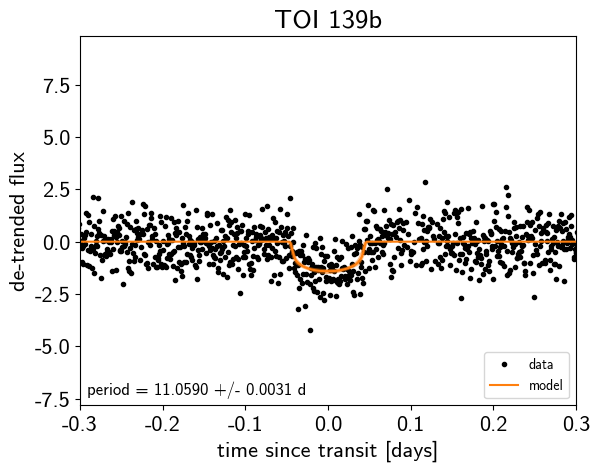

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

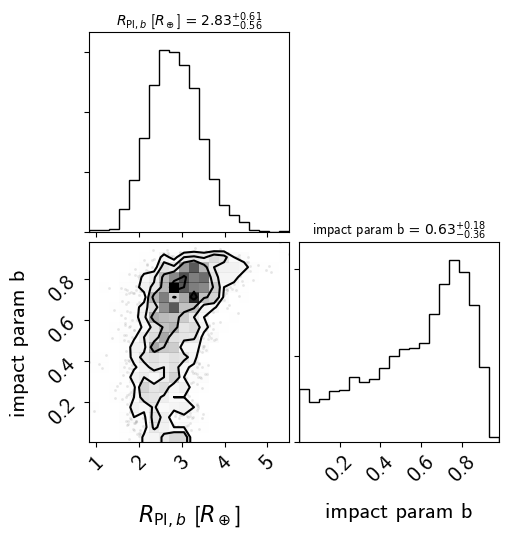

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

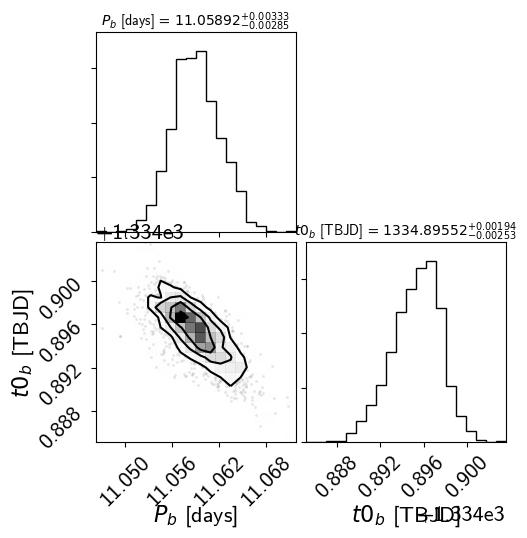

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

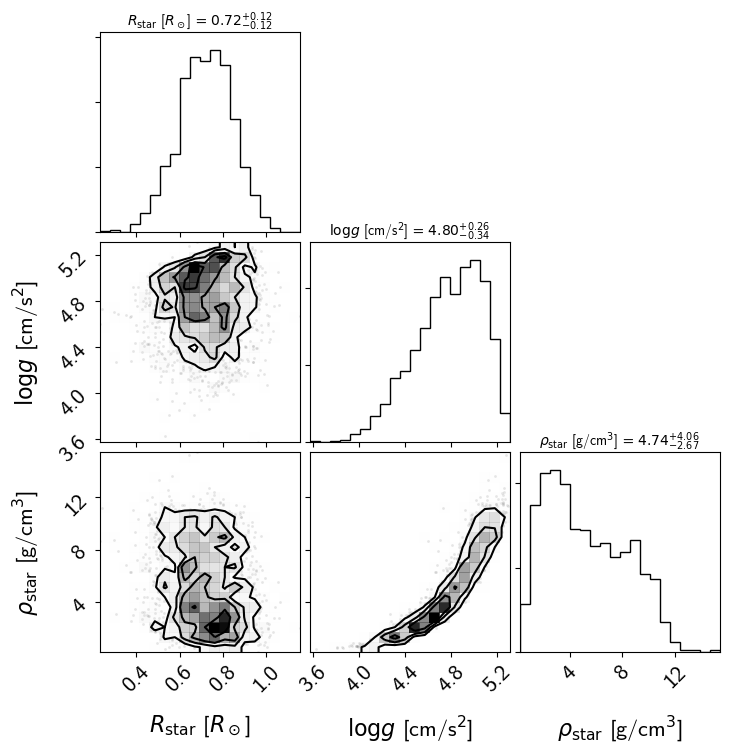

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3